# Solve cartpole with REINFORCE

> By Jonas Busk ([jbusk@dtu.dk](mailto:jbusk@dtu.dk))

In this part, we will create an agent that can learn to solve the [cartpole problem](https://gym.openai.com/envs/CartPole-v0/) from OpenAI Gym by applying a simple policy gradient method called REINFORCE.
In the cartpole problem, we need to balance a pole on a cart that moves along a track by applying left and right forces to the cart.

We will implement a probabilistic policy, that given a state of the environment, $s$, outputs a probability distribution over available actions, $a$:

$$
p_\theta(a|s)
$$

The policy is a neural network with parameters $\theta$ that can be trained with gradient descent.
When the set of available actions is discrete, we can use a network with softmax output do describe the distribution.
The core idea of training the policy network is quite simple: *we want to maximize the expected total reward by increasing the probability of good actions and decreasing the probability of bad actions*. 

To achieve this, we apply the gradient of the expected discounted total reward (return):

$$
\begin{align}
\nabla_\theta \mathbb{E}[R|\theta] &= \nabla_\theta \int p_\theta(a|s) R({a}) \, da \\
&= \int \nabla_\theta p_\theta(a|s) R(a)  \, da \\
&= \int p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) R(a) \, da \\
&= \mathbb{E}[\nabla_\theta \log p_\theta(a|s) R(a)]
\end{align}
$$

by definition of expectation and using the identity 

$$
\nabla_\theta p_\theta(a|s) = p_\theta(a|s) \nabla_\theta \log p_\theta(a|s) \ .
$$

The expectation cannot be evaluated analytically, but we have an environment simulator that when supplied with our current policy $p_\theta(a|s)$ can return a sequence of *actions*, *states* and *rewards*. This allows us to replace the integral with a Monte Carlo average:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) R_t \ ,
$$

which is our final gradient estimator, also known as REINFORCE. In the Monte Carlo estimator we run the environment simulator for a predefined number of steps with actions chosen stochastically according to the current stochastic action network $p_\theta(a|s)$.

*Note: For simple reinforcement learning problems (like the one we will address in this exercise) there are simpler methods that work just fine. However, the Policy Gradient method (with some extensions) has been shown to also work well for complex problems with high dimensional inputs and many parameters, where simple methods become inadequate.*

## Policy gradient

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from viewer import Viewer

In [3]:
# create gym environment
env = gym.make('CartPole-v0')

A state in this environment is four numbers describing the position of the cart along with the angle and speed of the pole.
There are two available actions: push the cart *left* or *right* encoded as 0 and 1.

In [4]:
s = env.reset()
a = env.action_space.sample()
print('sample state:', s)
print('sample action:', a )

sample state: [ 0.04753398  0.02272844  0.01794809 -0.00434197]
sample action: 0


Let us see how the environment looks when we just take random actions.

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



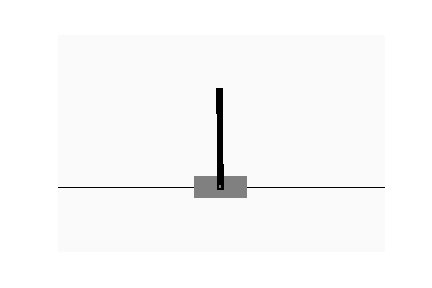
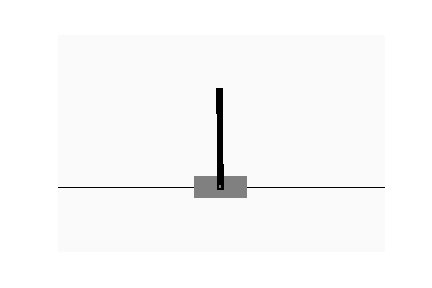
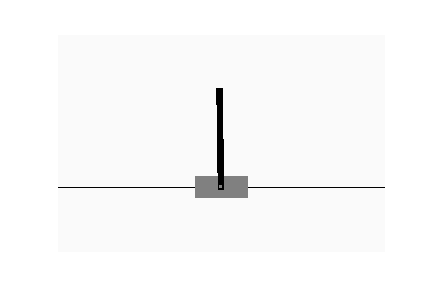
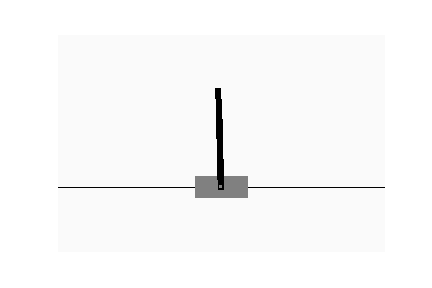
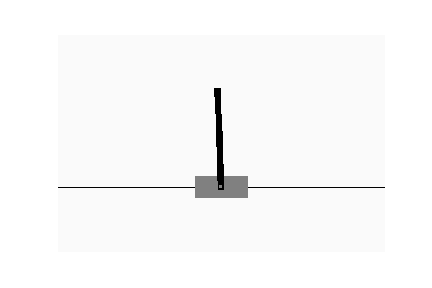
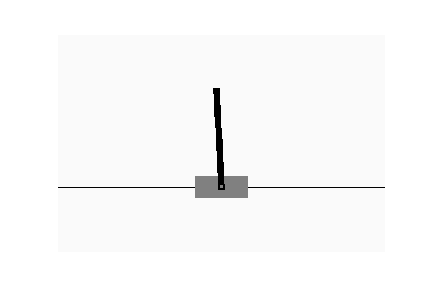
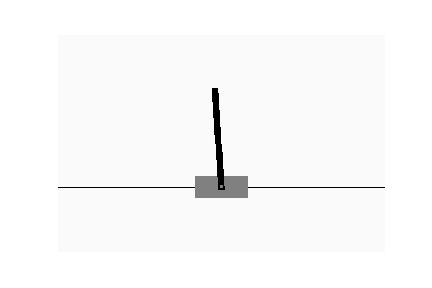
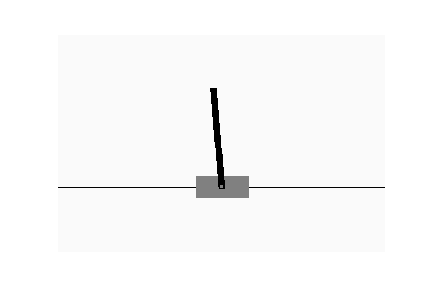
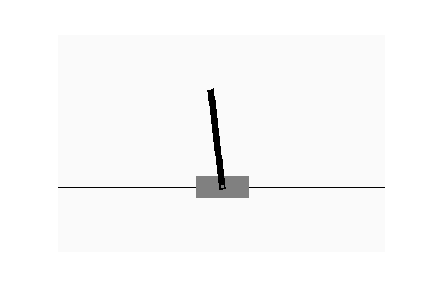
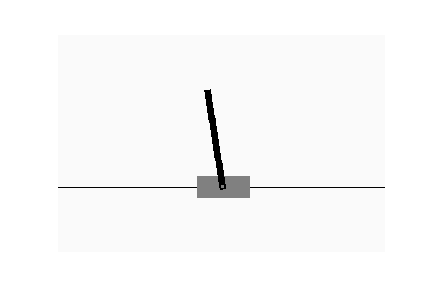
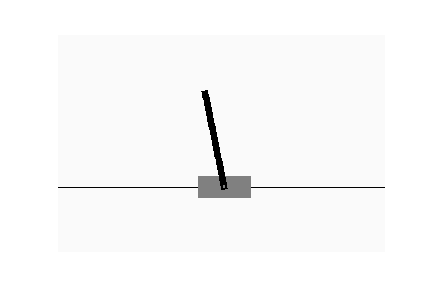
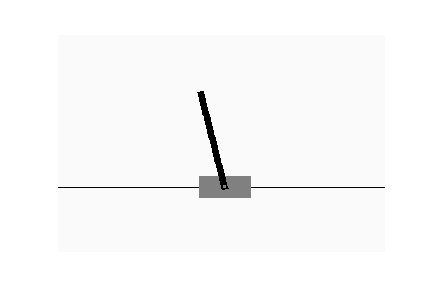
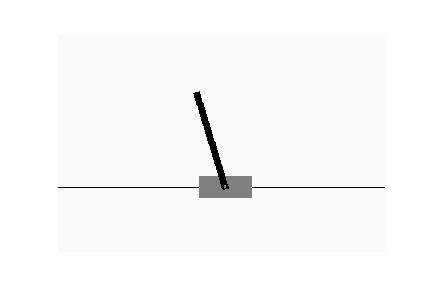
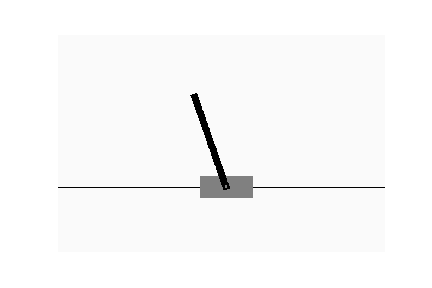
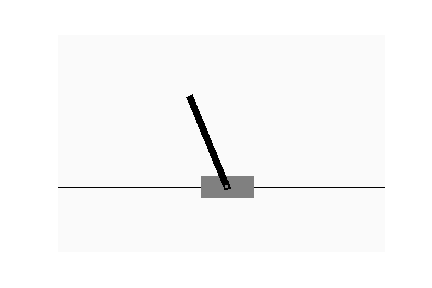
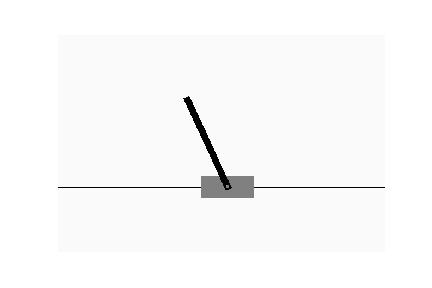
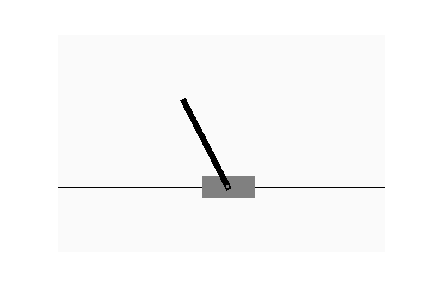
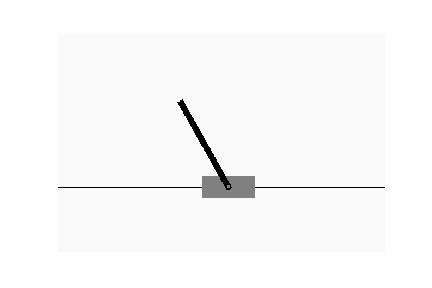
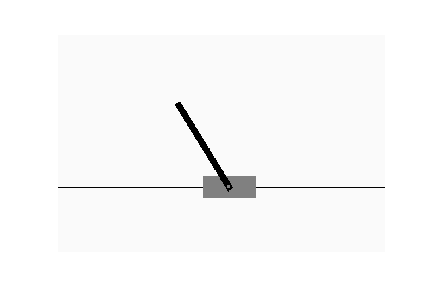
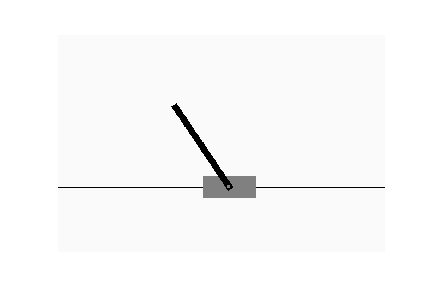
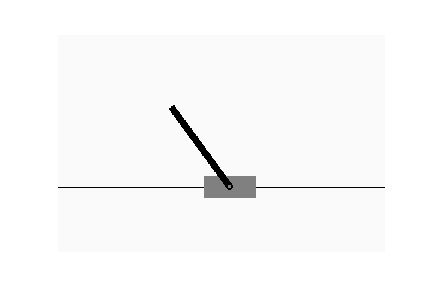
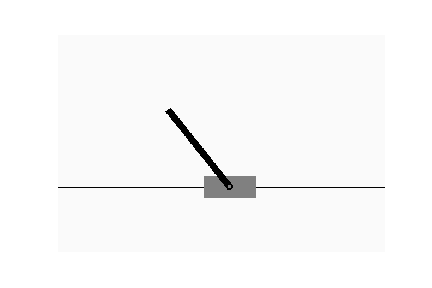
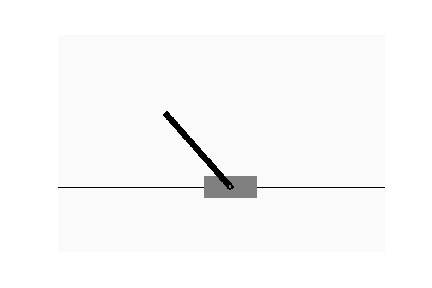
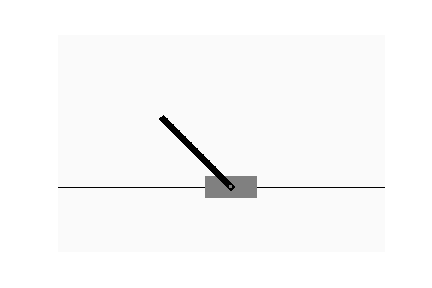
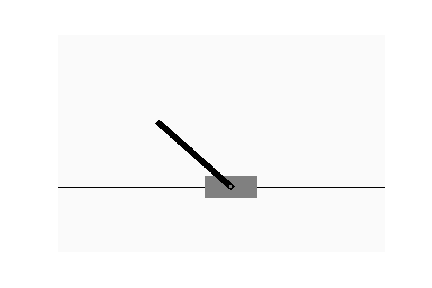
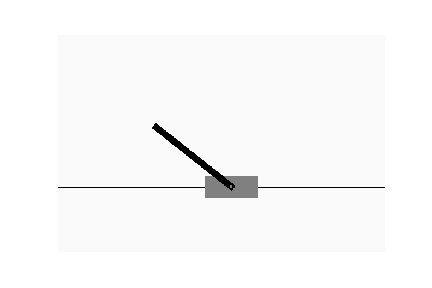
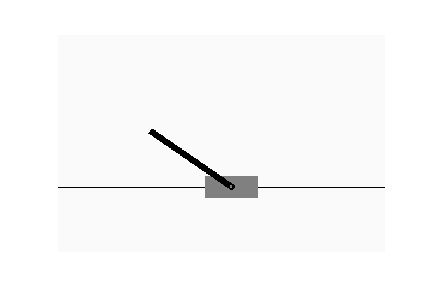
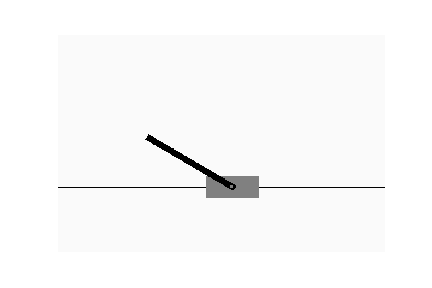
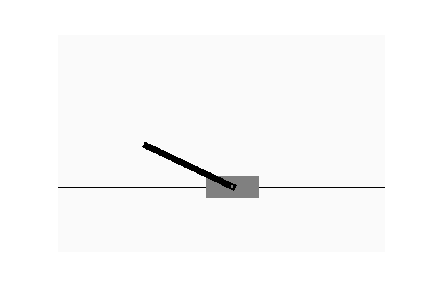
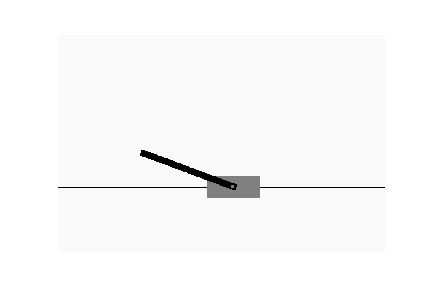
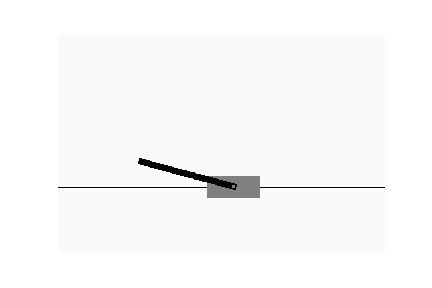
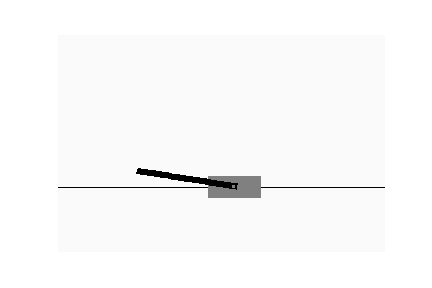
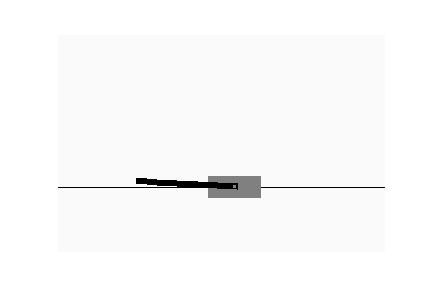
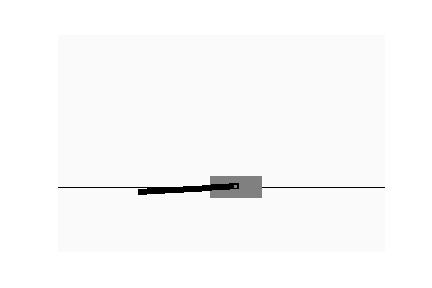
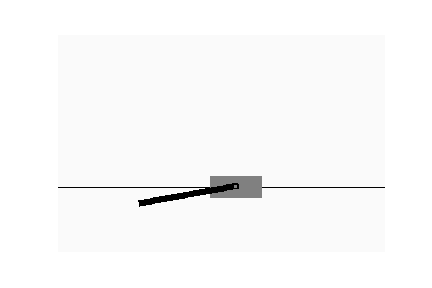
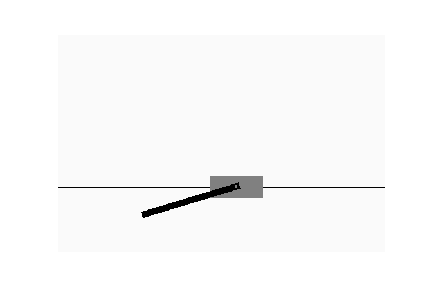
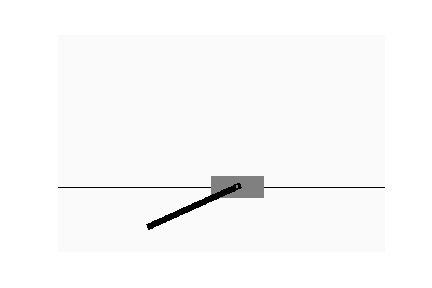
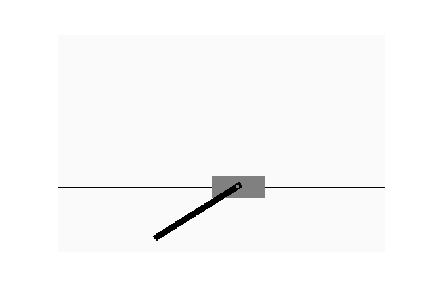
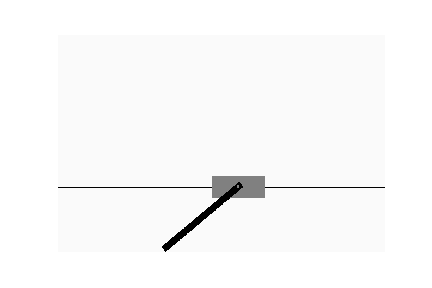
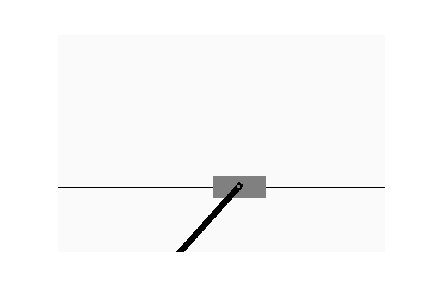
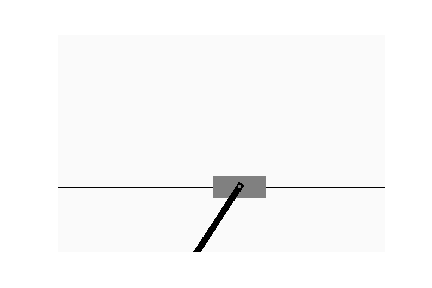
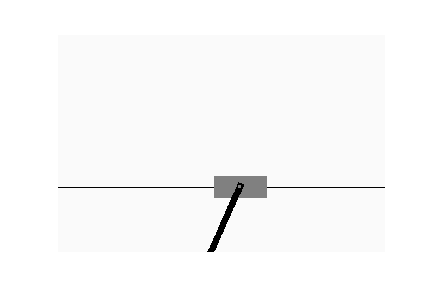
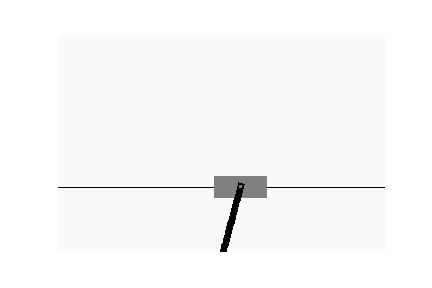
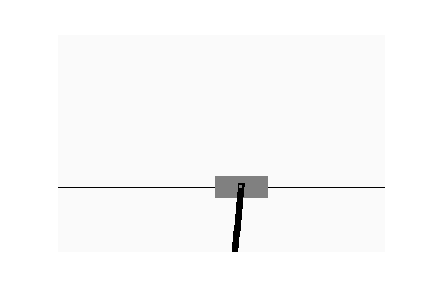
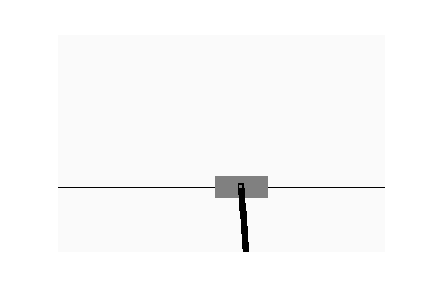
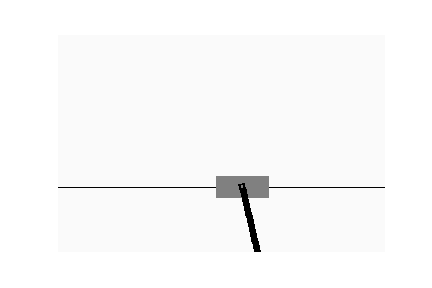
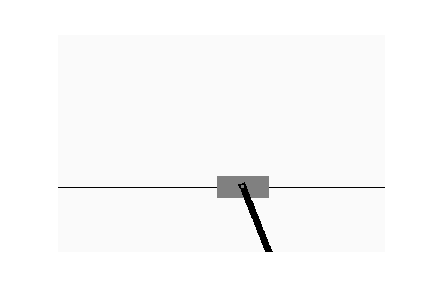
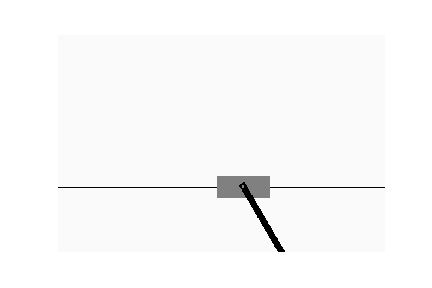
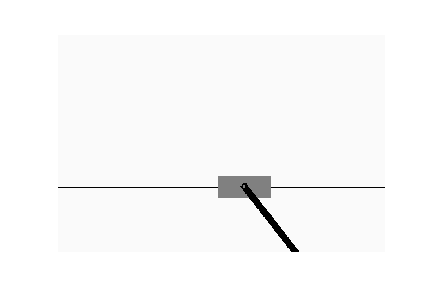
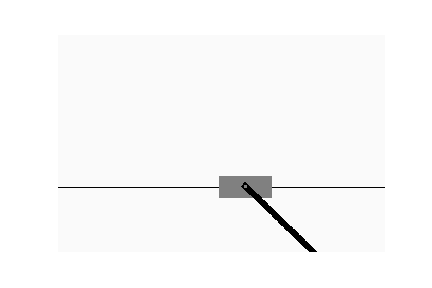
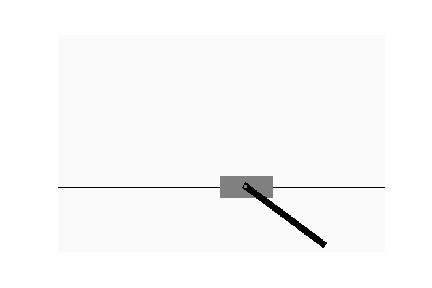
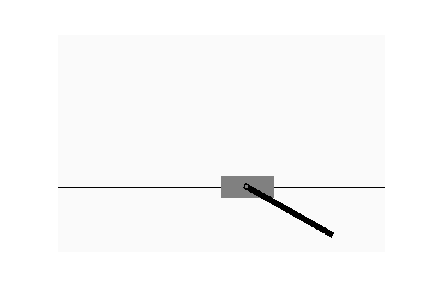
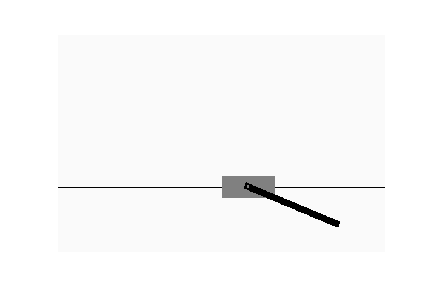
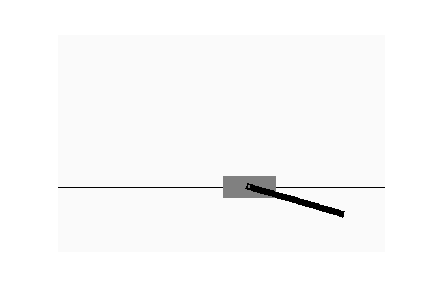
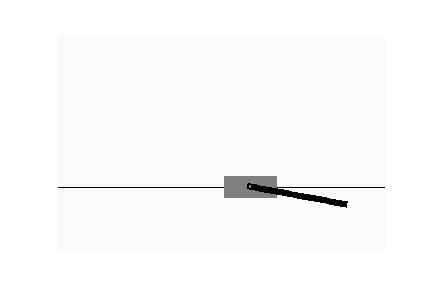
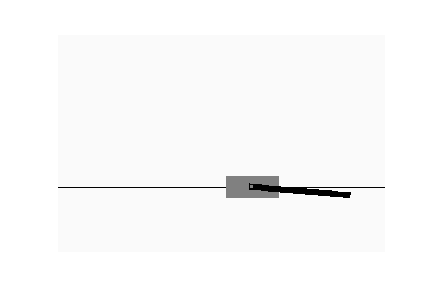
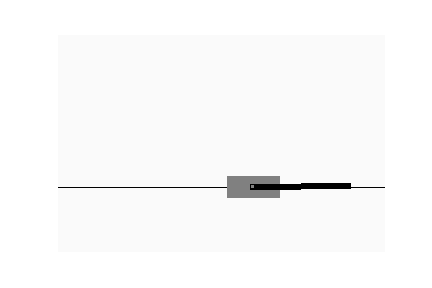
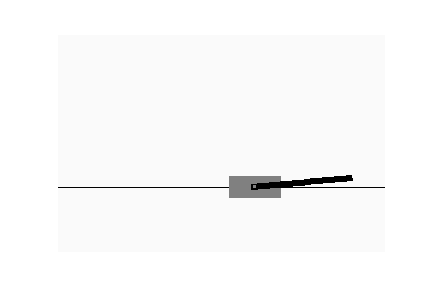
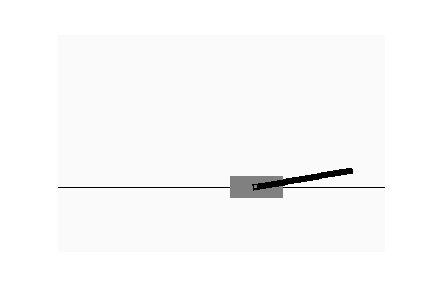
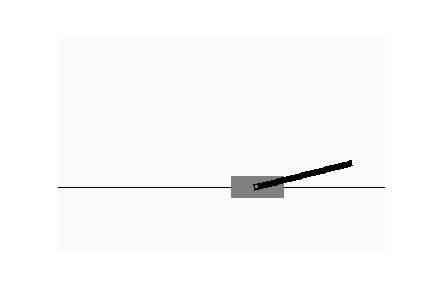
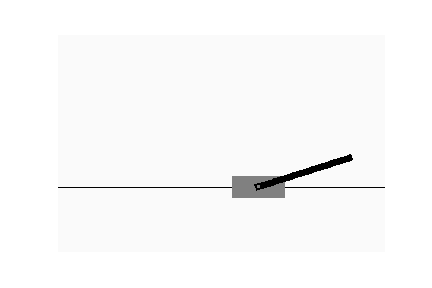
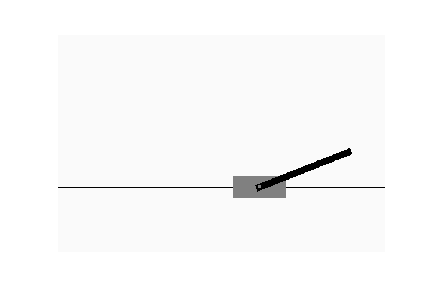
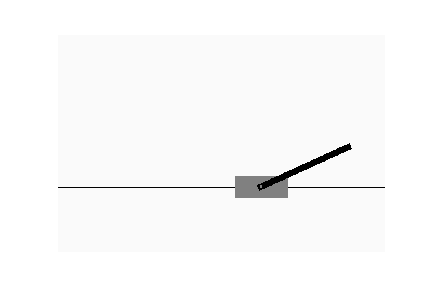
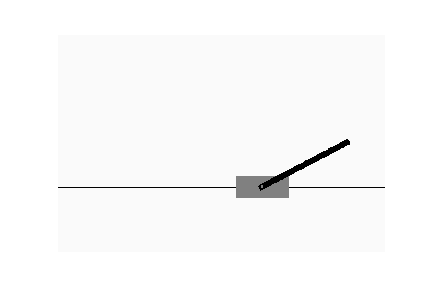
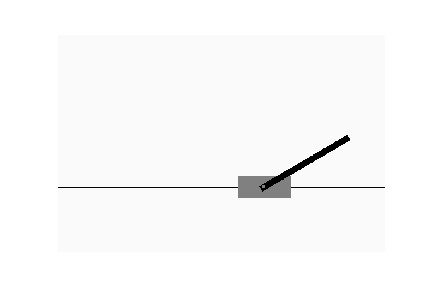
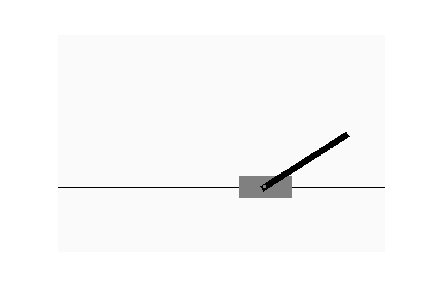
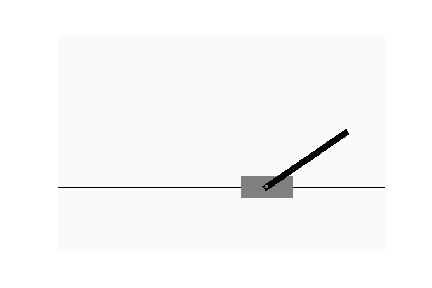
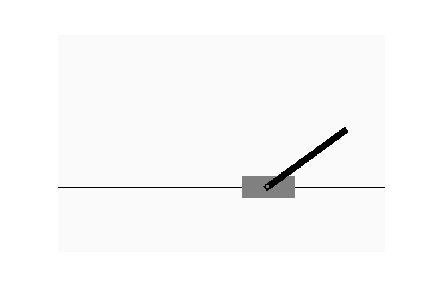
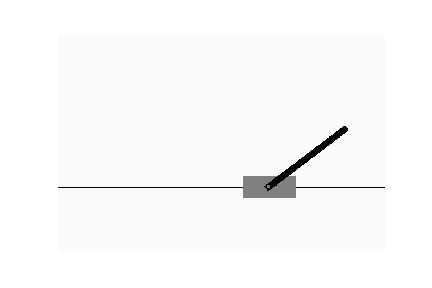
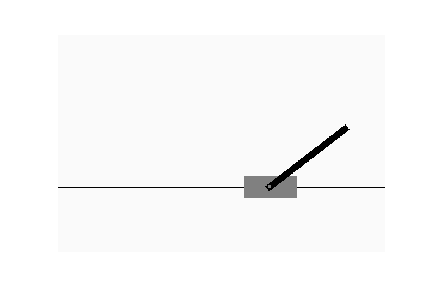
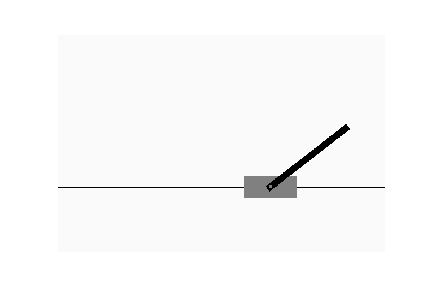
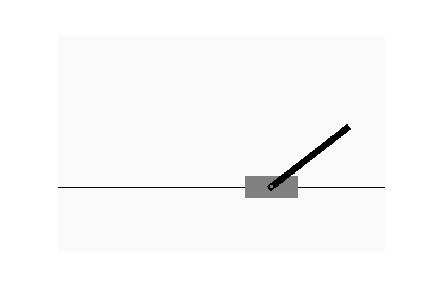
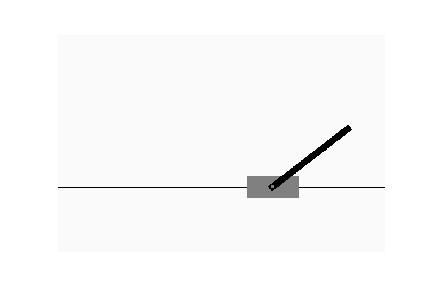
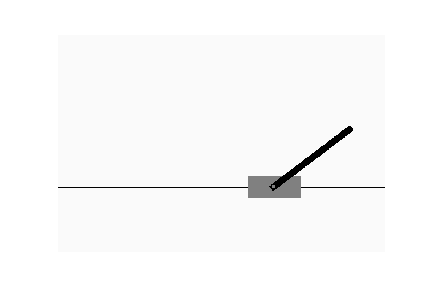
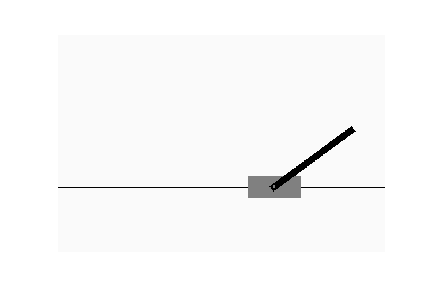
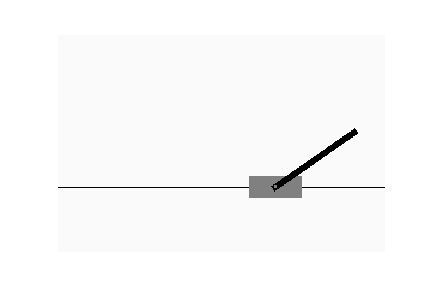
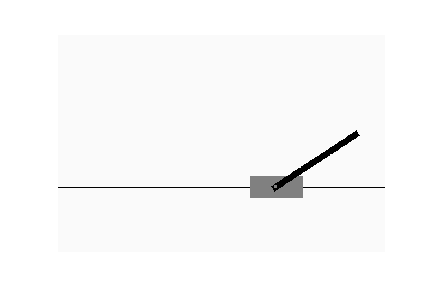
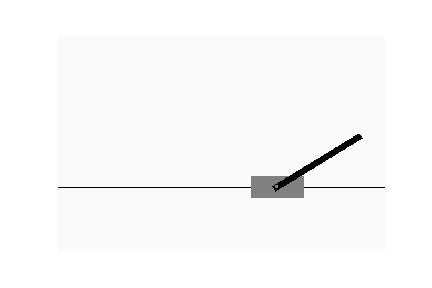
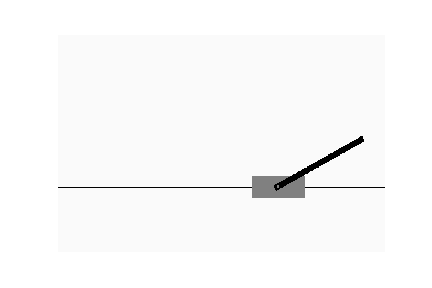
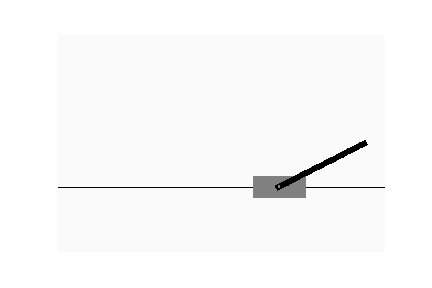
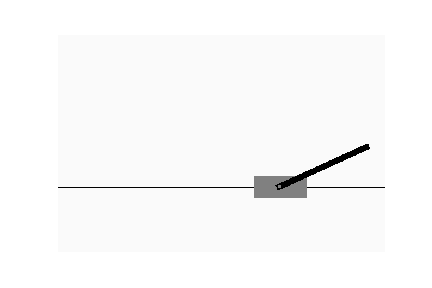
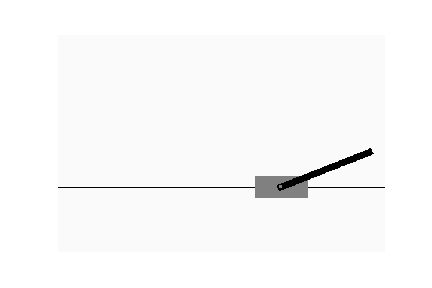
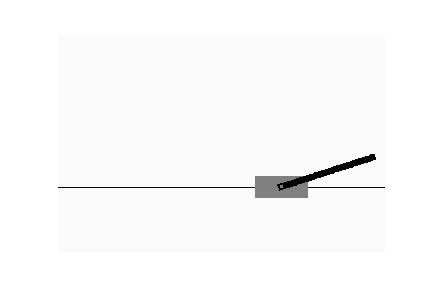
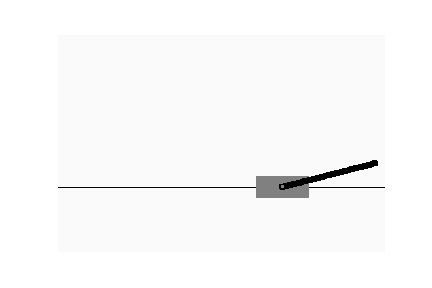
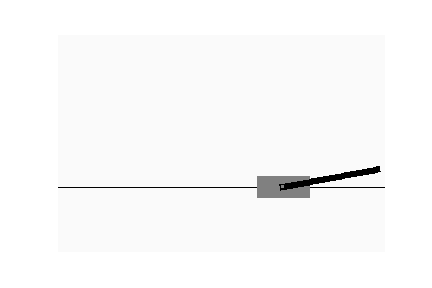
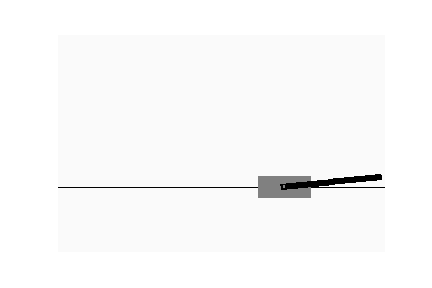
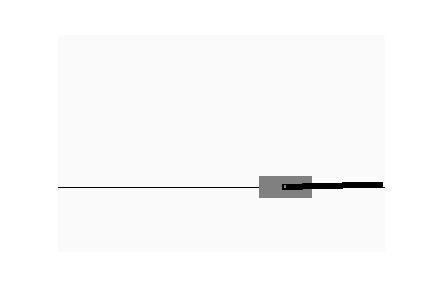
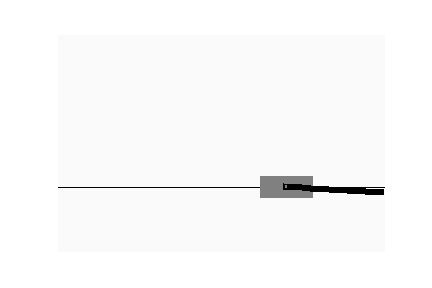
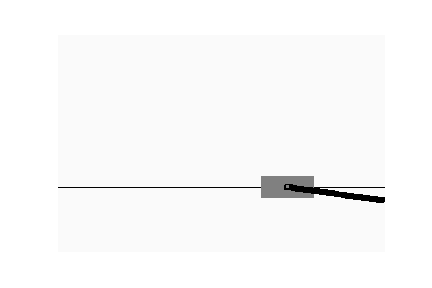
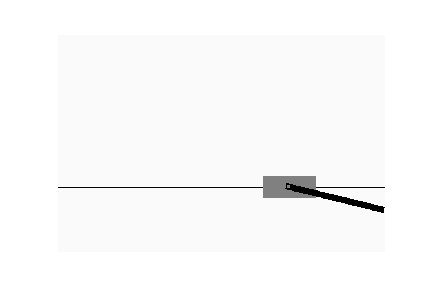
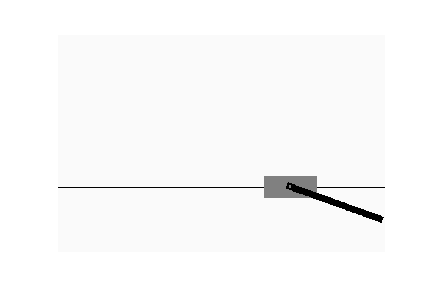
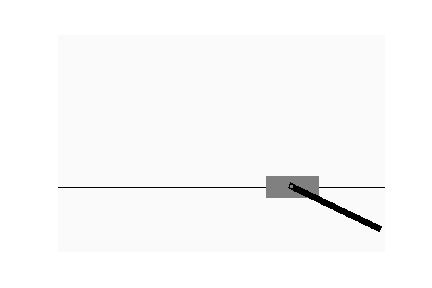
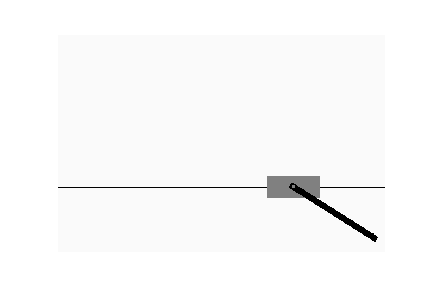
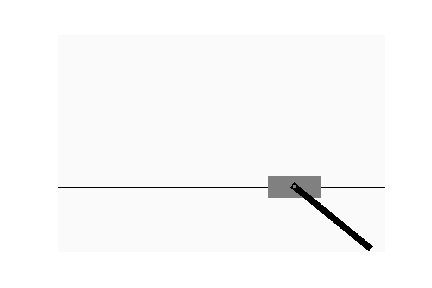
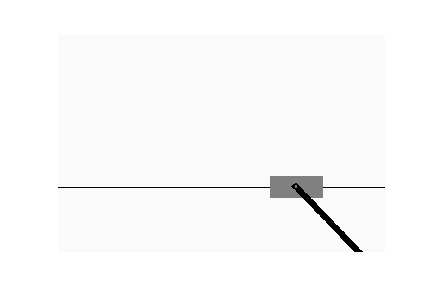
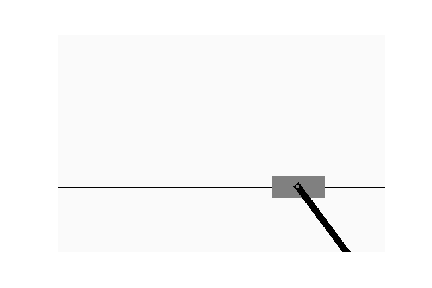
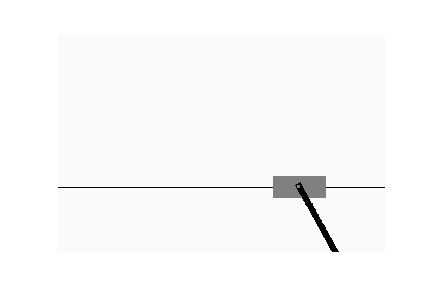
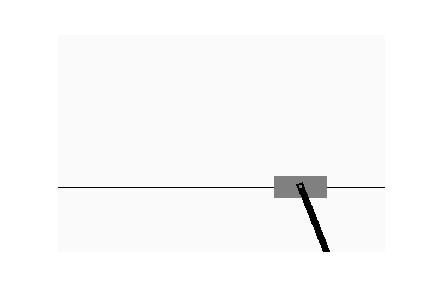
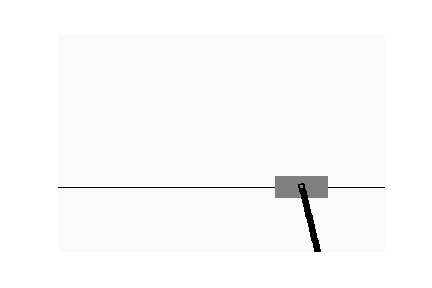
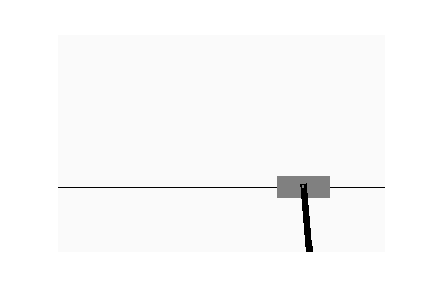
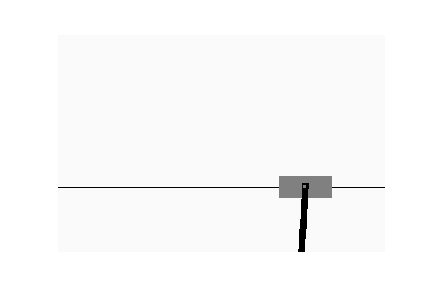
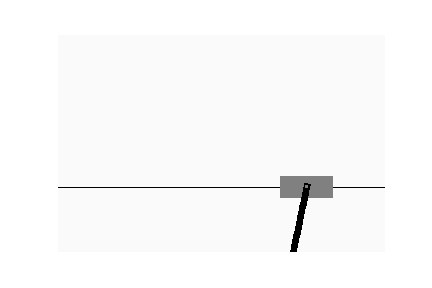
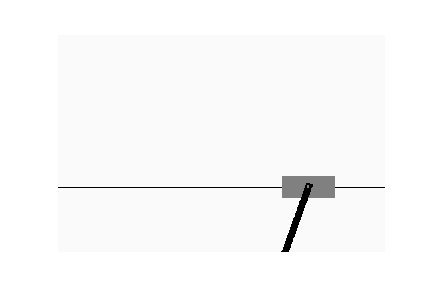
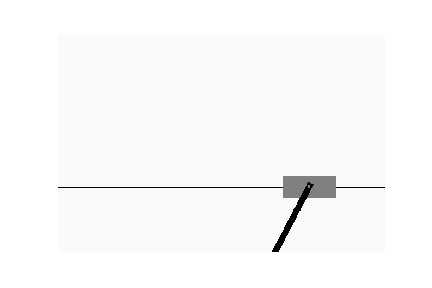
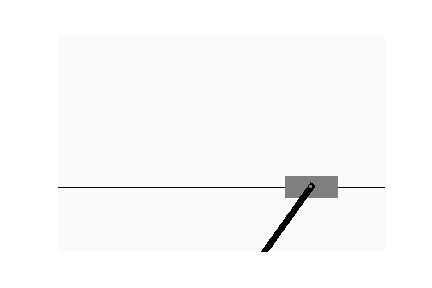
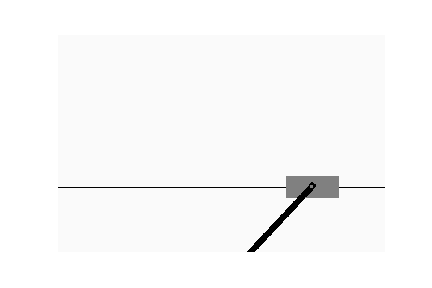
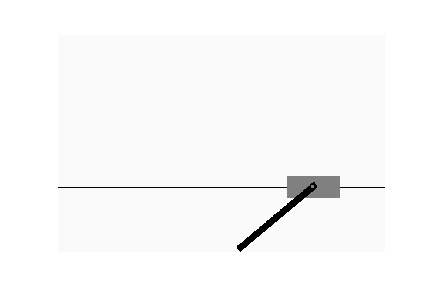
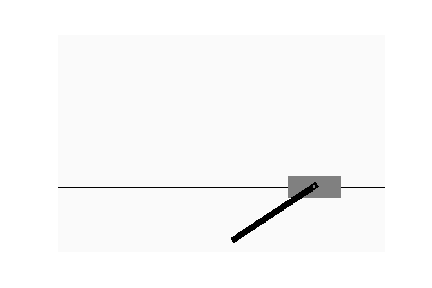
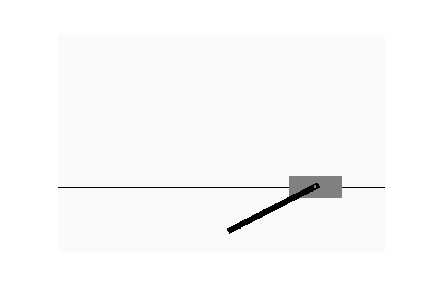
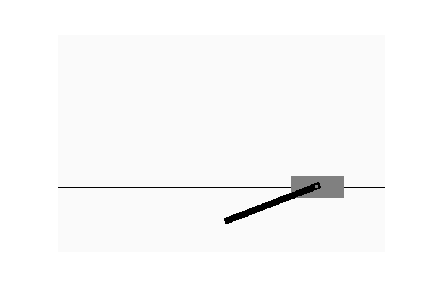
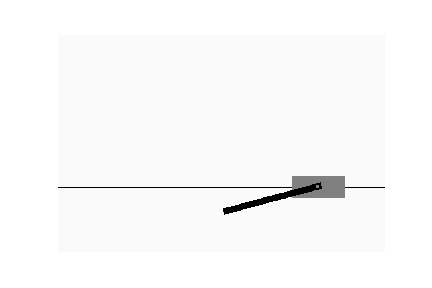
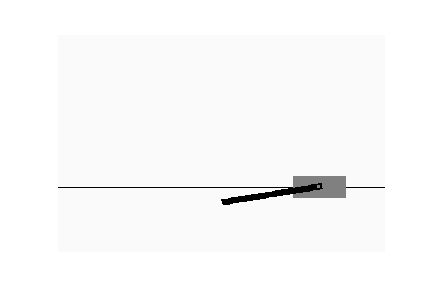
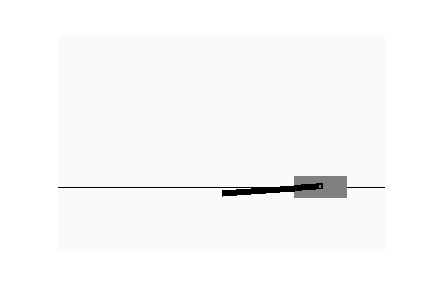
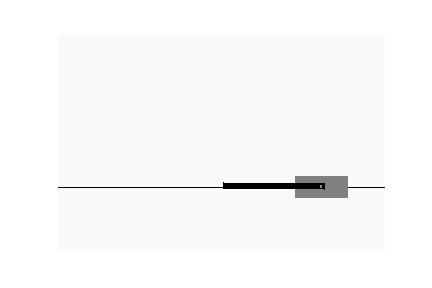
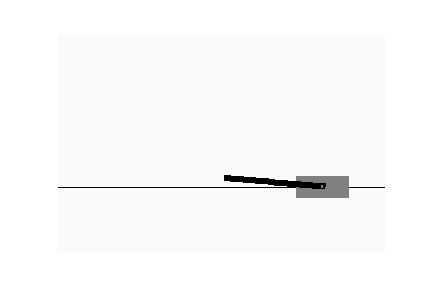
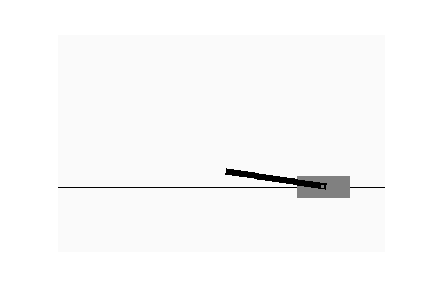
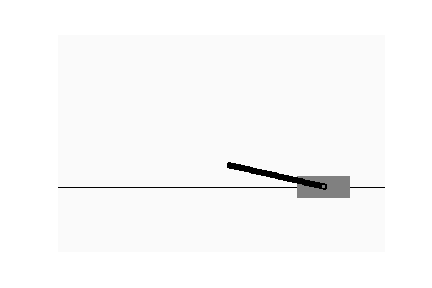
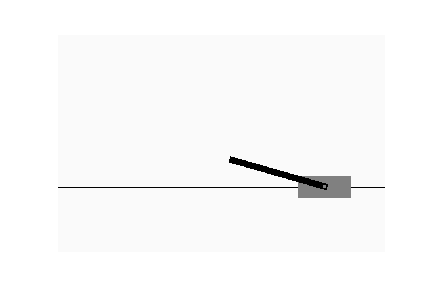
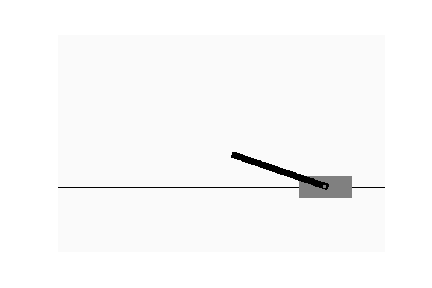
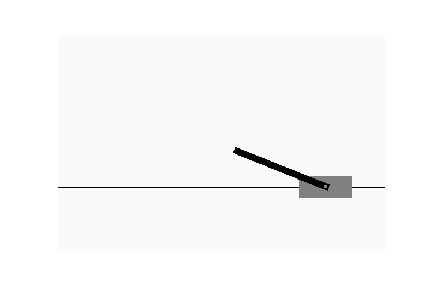
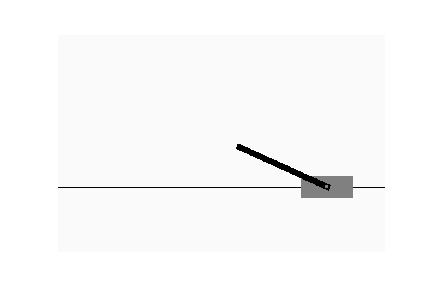
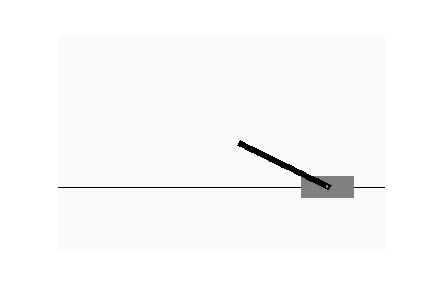
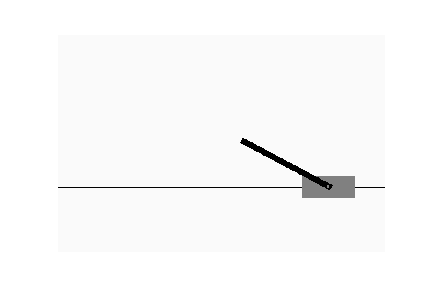
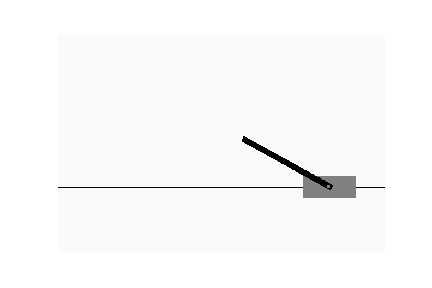
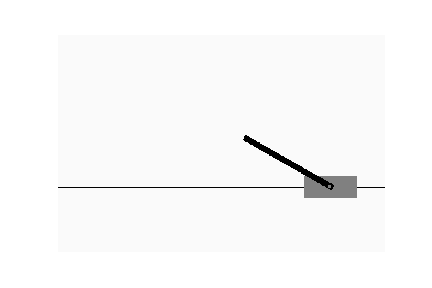
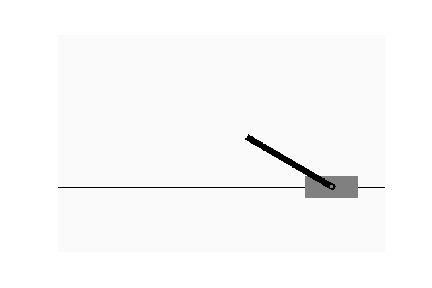
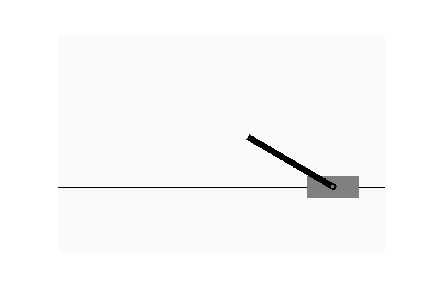
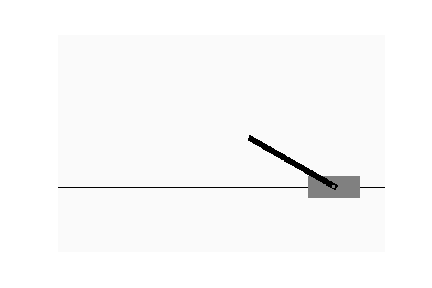
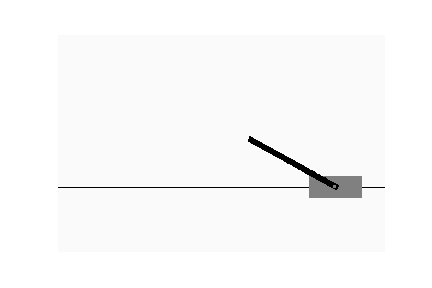
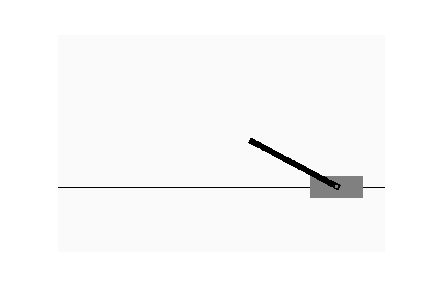
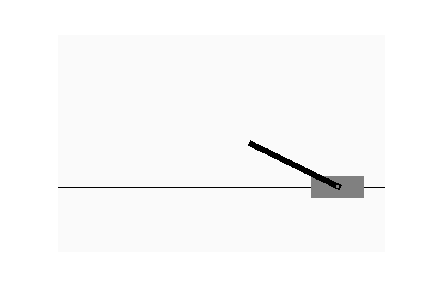
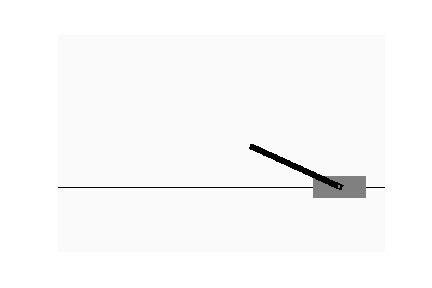
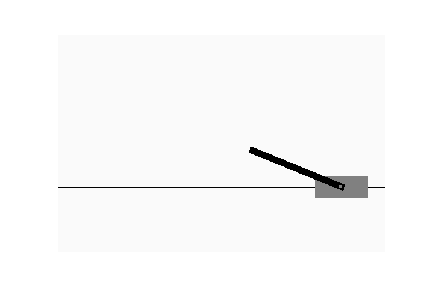
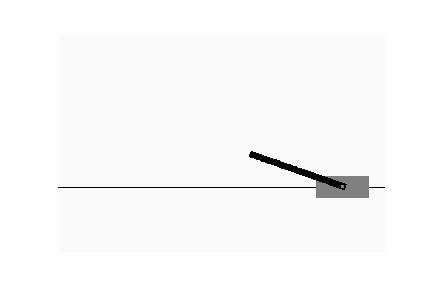
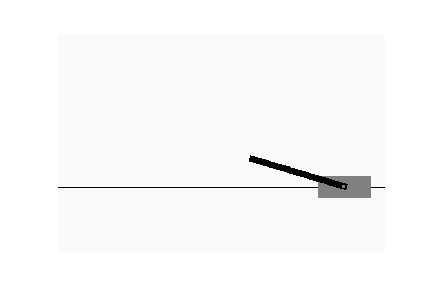
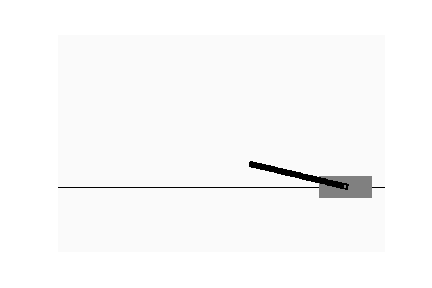
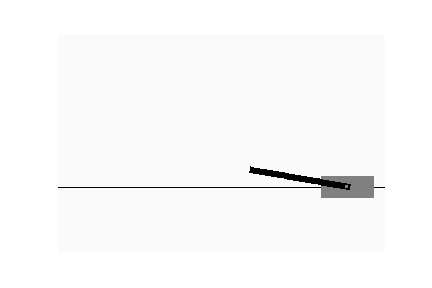
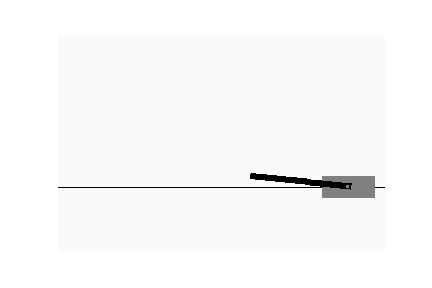
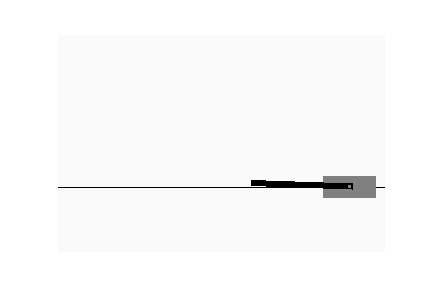
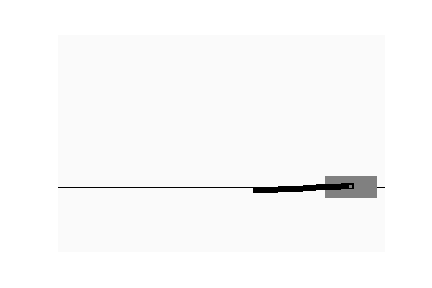
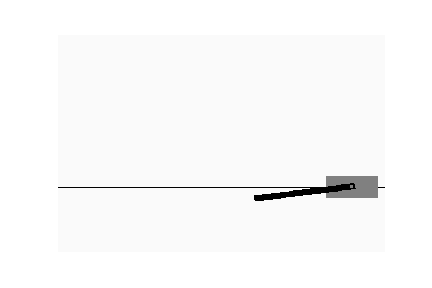
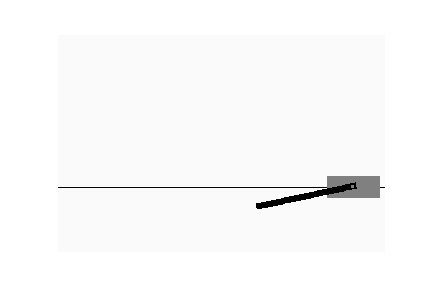
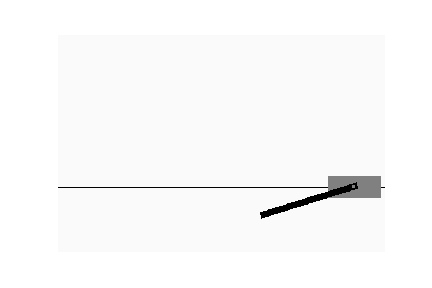
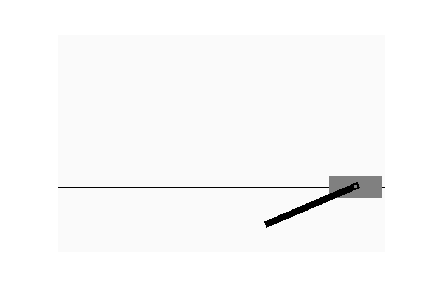
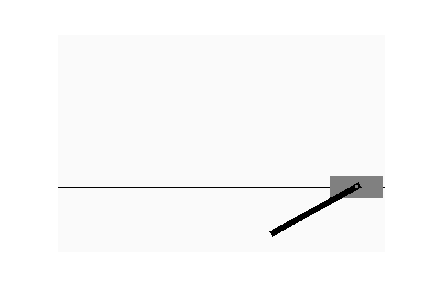
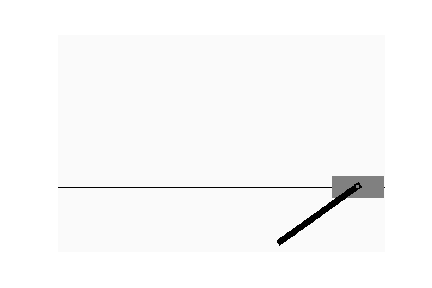
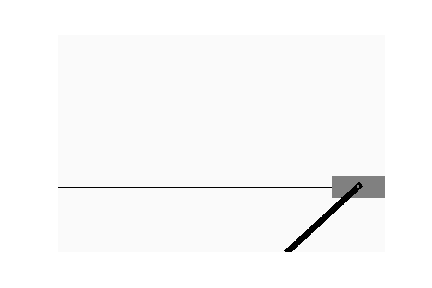
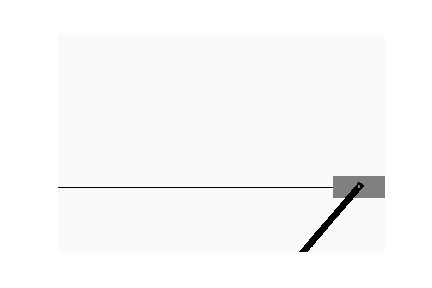
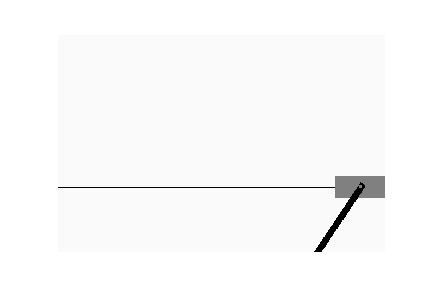
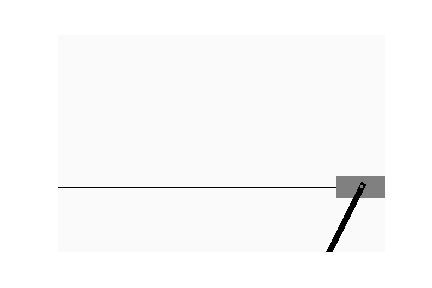
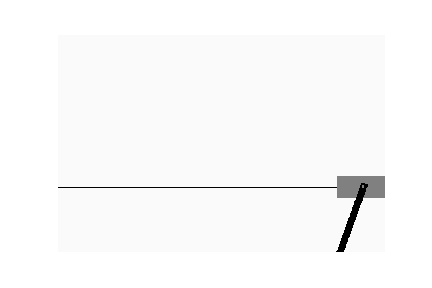
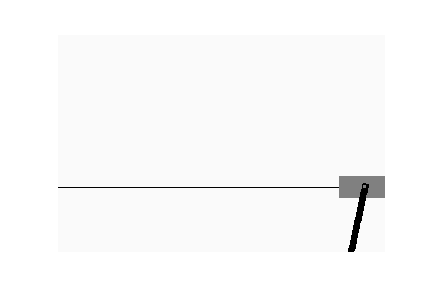
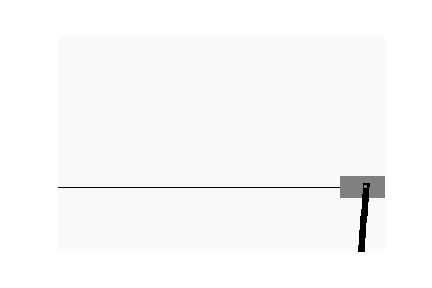
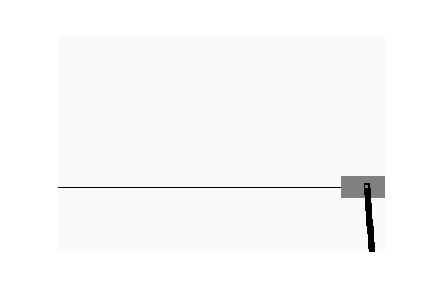
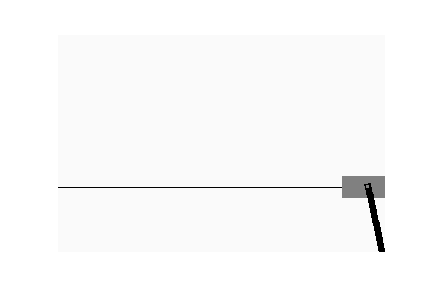
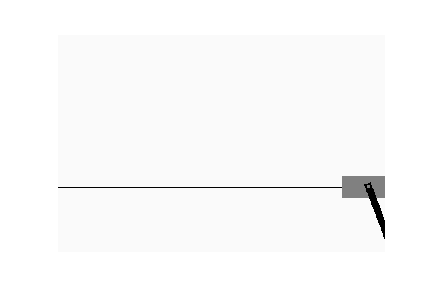
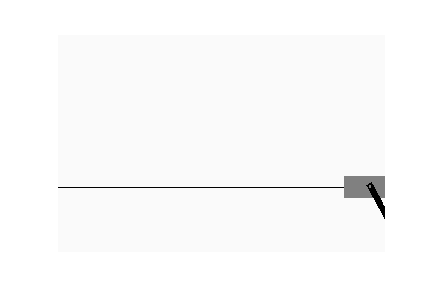
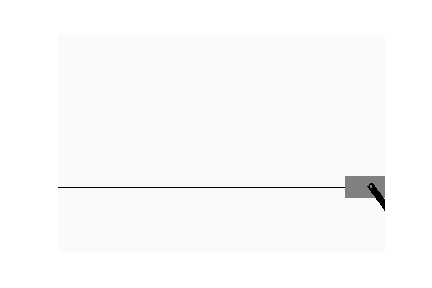
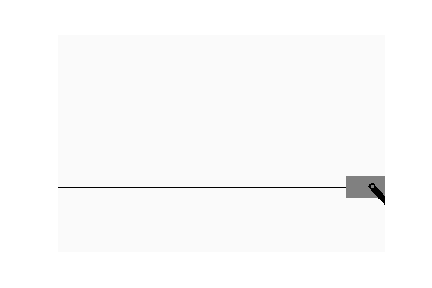
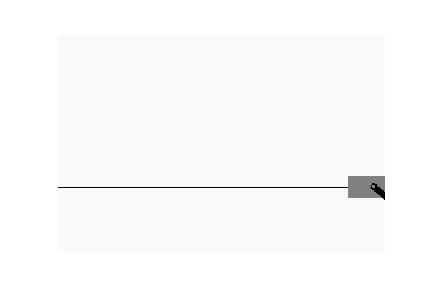
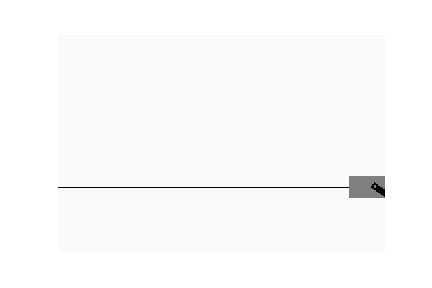
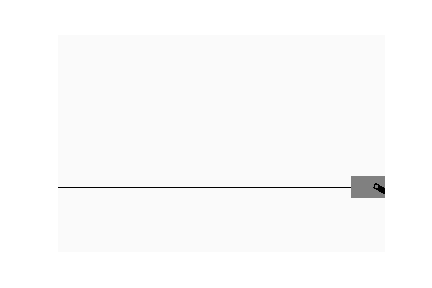
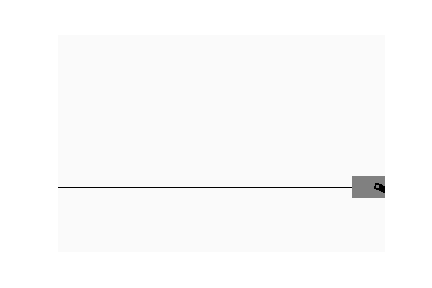
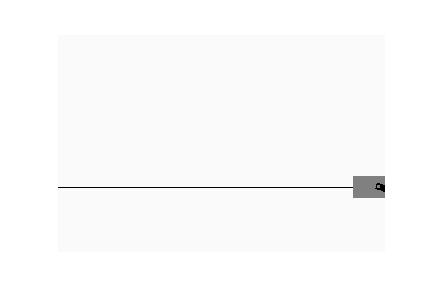
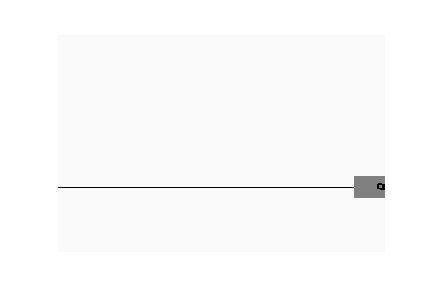
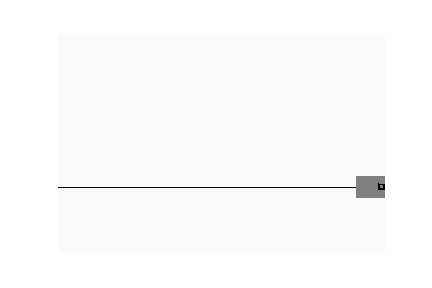
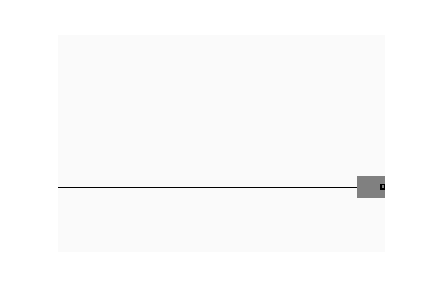
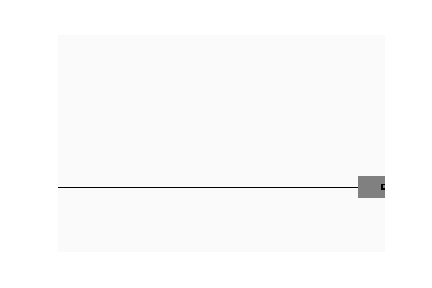
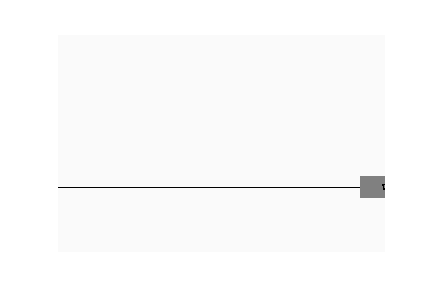
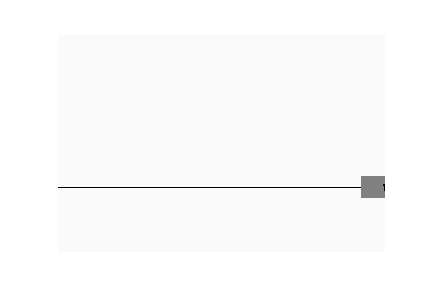
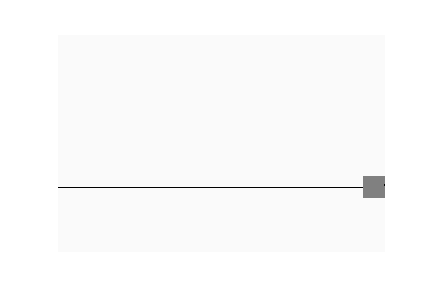
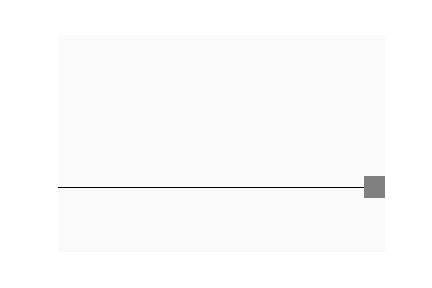
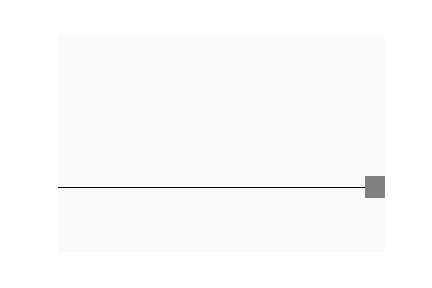
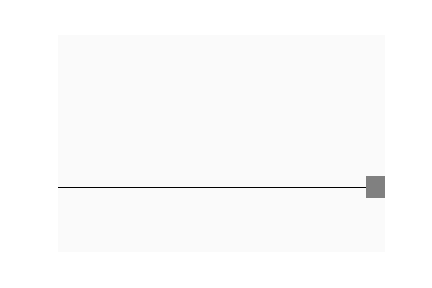
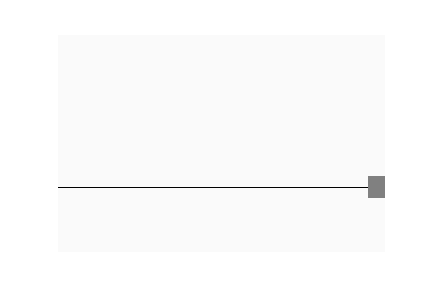
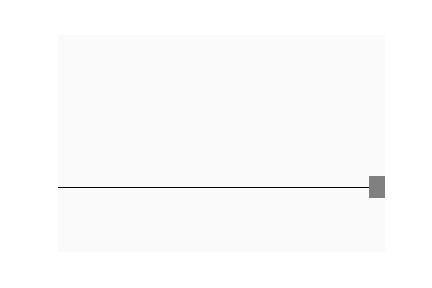
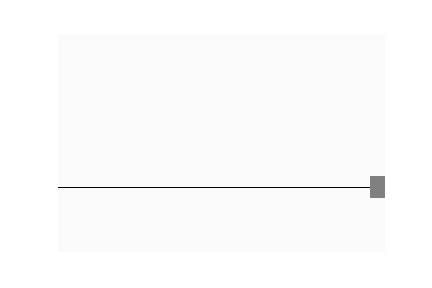
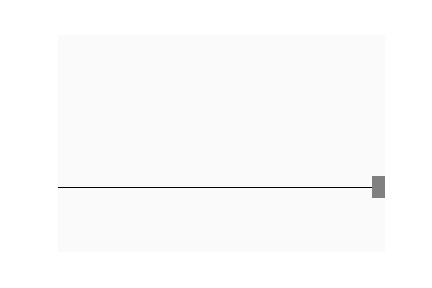
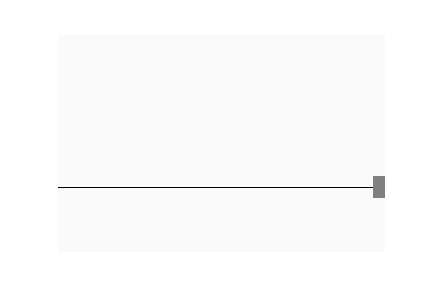
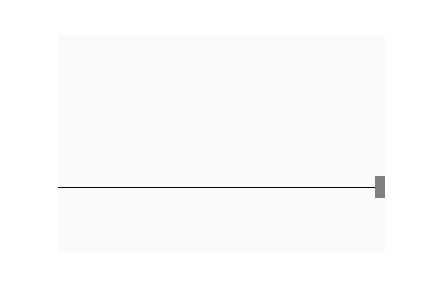
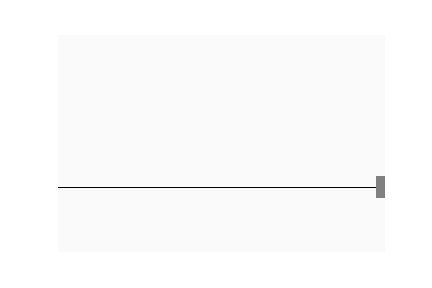
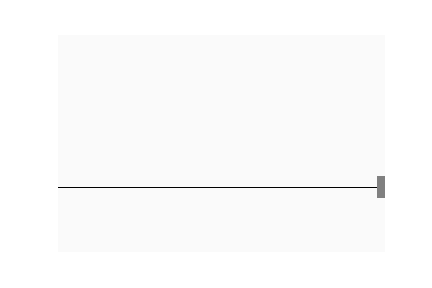
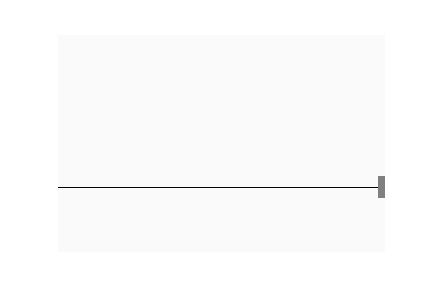
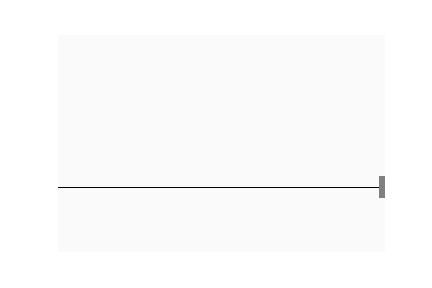
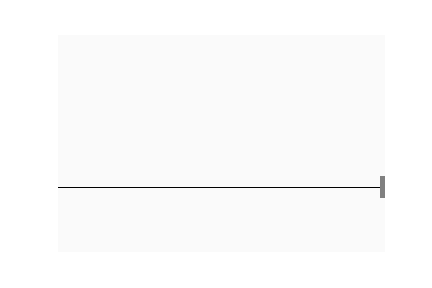
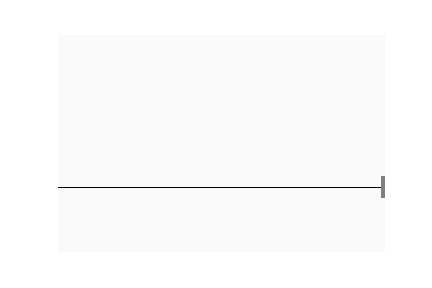
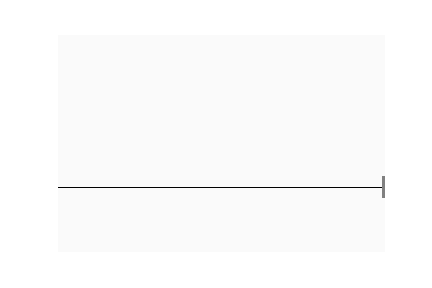
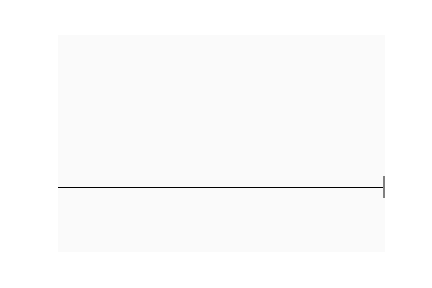
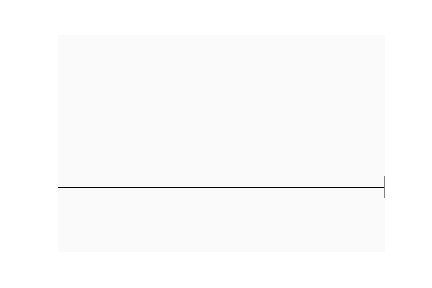
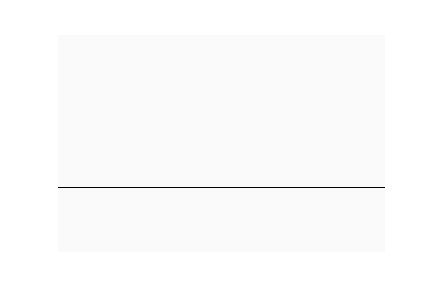
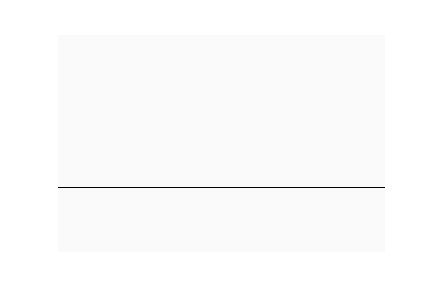
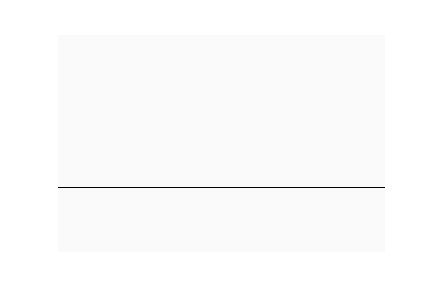
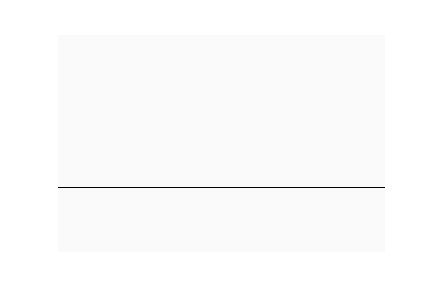
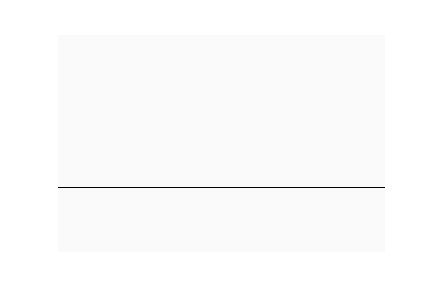
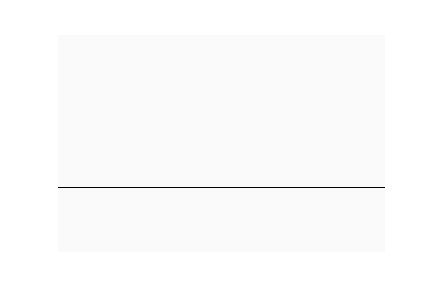
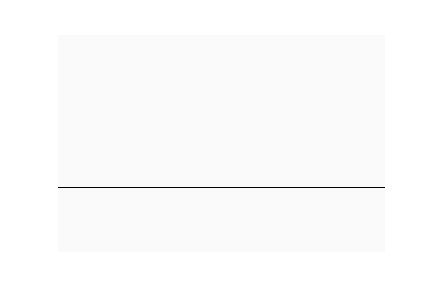
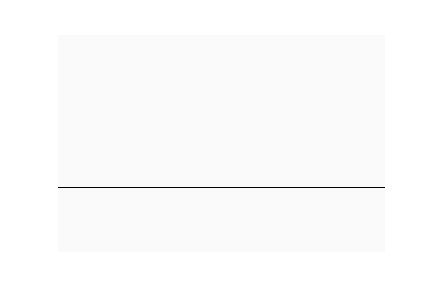
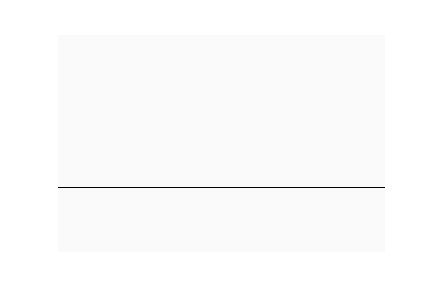
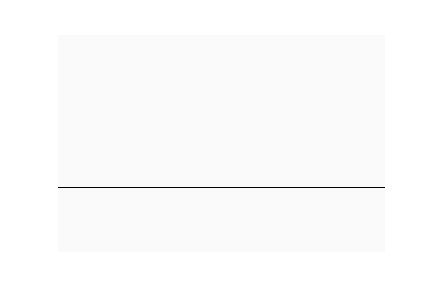
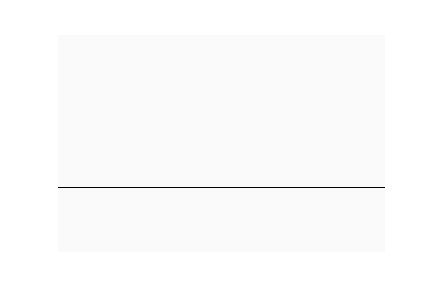

In [5]:
# demo the environment
env.reset() # reset the environment
view = Viewer(env, custom_render=True) # we use this custom viewer to render the environment inline in the notebook
for _ in range(200):
    view.render() # display the environment inline in the notebook
    # env.render() # uncomment this to use gym's own render function
    env.step(env.action_space.sample()) # take a random action
view.render(close=True, display_gif=True) # display the environment inline in the notebook
# env.render(close=True) # uncomment this to use gym'm own render function

Taking random actions does not do a very good job at balancing the pole. Let us now apply the Policy Gradient method described above to solve this task!

Let's first define our network and helper functions.

In [6]:
class PolicyNet(nn.Module):
    """Policy network"""

    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_outputs, learning_rate):
        super(PolicyNet, self).__init__()
        # network
        self.hidden_1 = nn.Linear(n_inputs, n_hidden_1)
        self.hidden_2 = nn.Linear(n_hidden_1, n_hidden_2) # This was added, along with the new network input n_hidden_2
        self.out = nn.Linear(n_hidden_2, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.hidden_1(x)
        x = F.relu(x)
        x = self.hidden_2(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, action_probabilities, returns):
        return -torch.mean(torch.mul(torch.log(action_probabilities), returns))

In [7]:
def compute_returns(rewards, discount_factor):
    """Compute discounted returns."""
    returns = np.zeros(len(rewards))
    returns[-1] = rewards[-1]
    for t in reversed(range(len(rewards)-1)):
        returns[t] = rewards[t] + discount_factor * returns[t+1]
    return returns

To start with, our policy will be a rather simple neural network with one hidden layer. We can retrieve the shape of the state space (input) and action space (output) from the environment.

In [8]:
n_inputs = env.observation_space.shape[0]
n_hidden_1 = 20
n_hidden_2 = 40
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)

state shape: 4
action shape: 2


In [48]:
# training settings

num_episodes = 2000 #Original 800
rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.95 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden_1, n_hidden_2, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  21.30, mean validation reward:   9.70, mean loss:  5.2807
 200. mean training reward:  24.02, mean validation reward:  14.40, mean loss:  5.7108
 300. mean training reward:  23.95, mean validation reward:  13.00, mean loss:  5.6736
 400. mean training reward:  24.48, mean validation reward:   9.70, mean loss:  5.4542
 500. mean training reward:  22.52, mean validation reward:  10.30, mean loss:  5.2624
 600. mean training reward:  20.95, mean validation reward:  12.70, mean loss:  4.9532
 700. mean training reward:  17.86, mean validation reward:  14.90, mean loss:  4.4222
 800. mean training reward:  24.57, mean validation reward:  37.70, mean loss:  5.2074
 900. mean training reward:  54.60, mean validation reward: 157.50, mean loss:  7.8677
1000. mean training reward:  54.50, mean validation reward: 117.30, mean loss:  7.7288
1100. mean training reward:  39.25, mean validation reward: 148.20, mean loss:  6.4650
1200. mean training reward: 

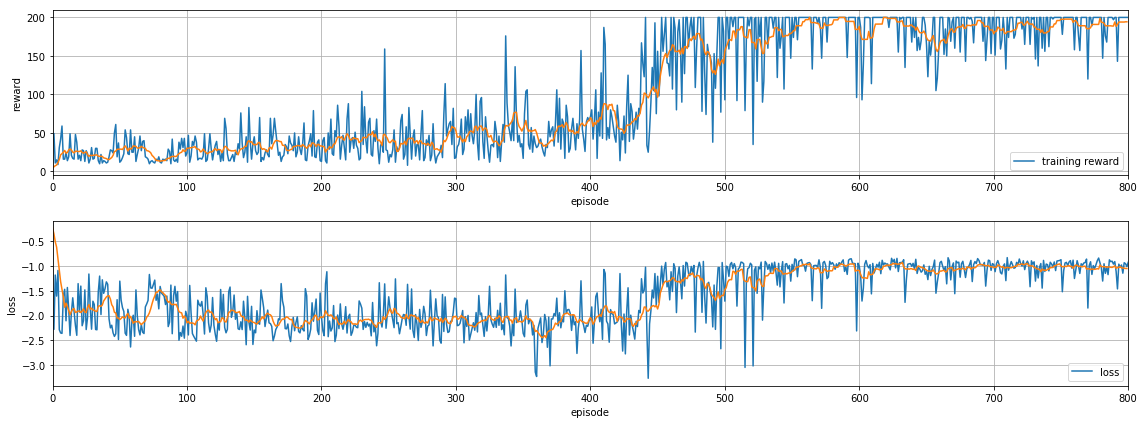

In [18]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()

Now let's review the solution!

WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.



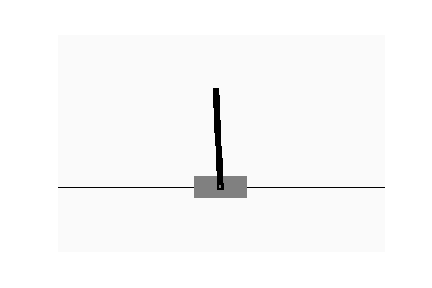
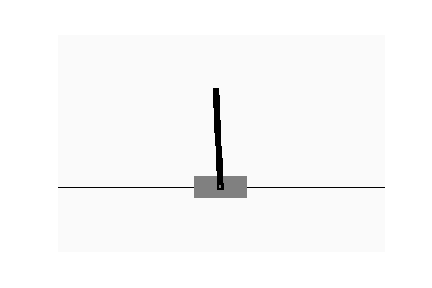
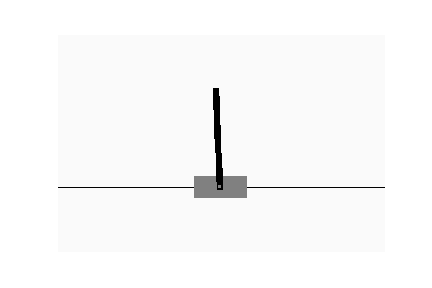
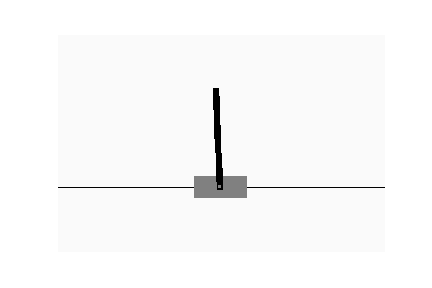
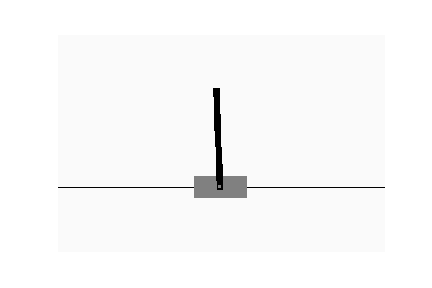
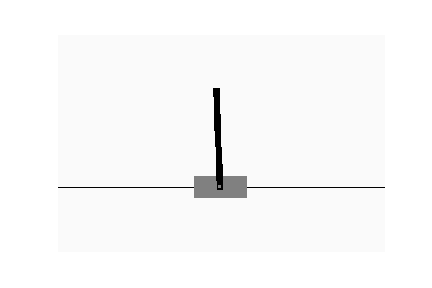
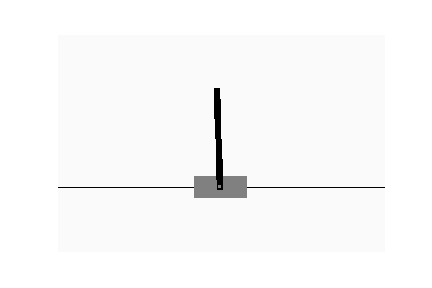
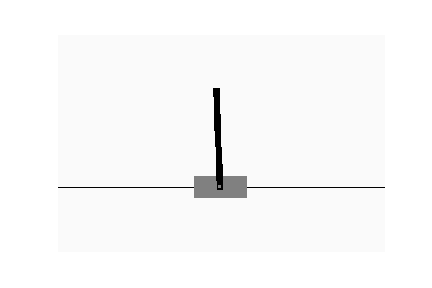
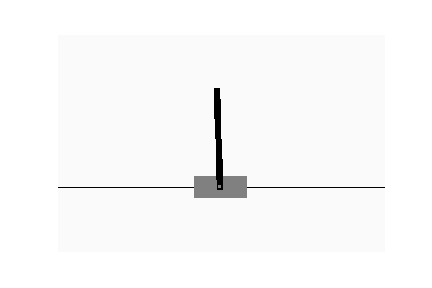
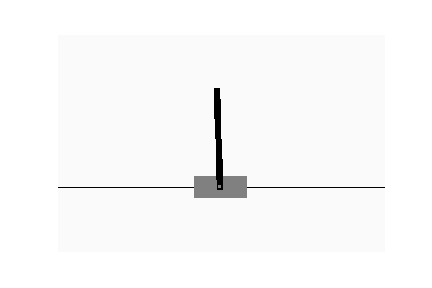
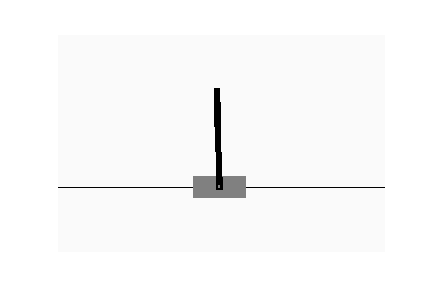
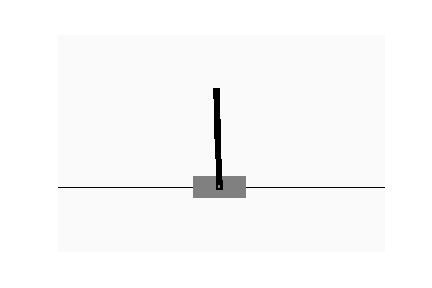
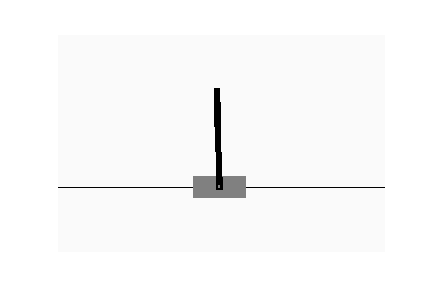
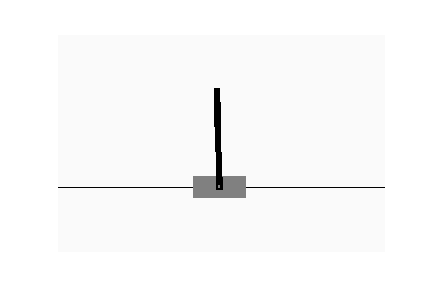
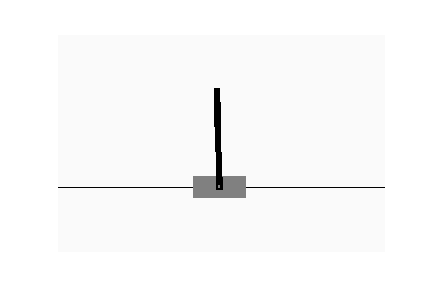
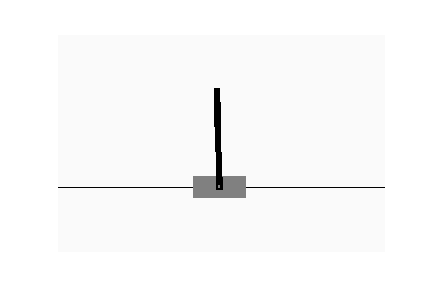
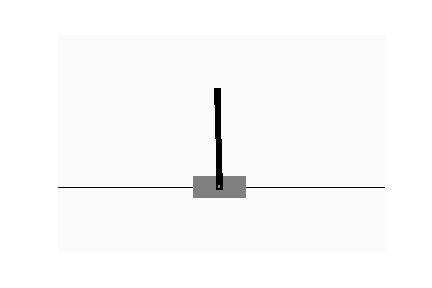
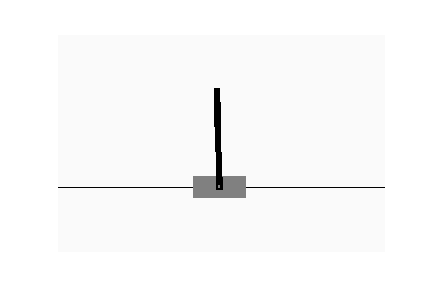
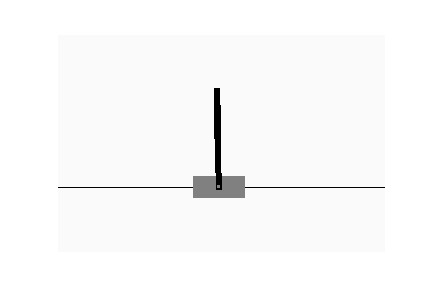
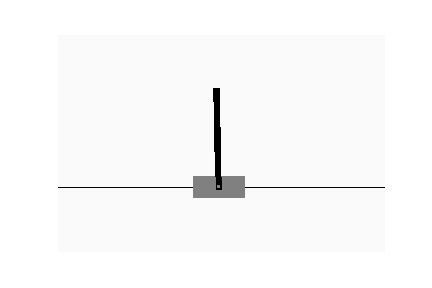
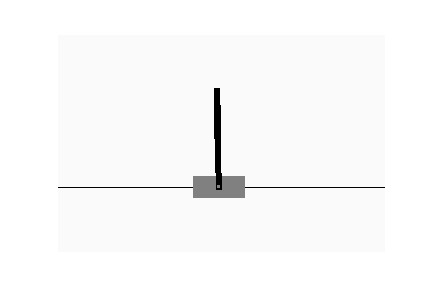
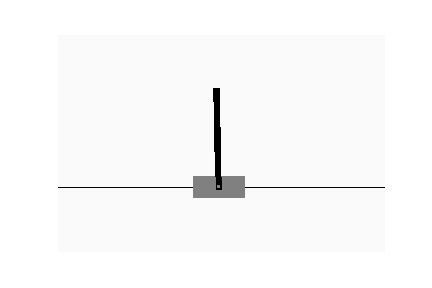
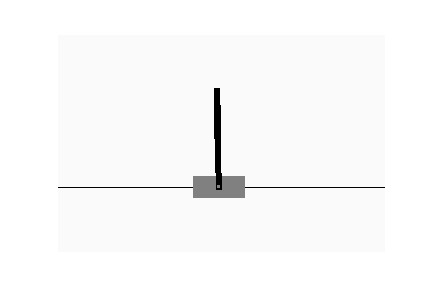
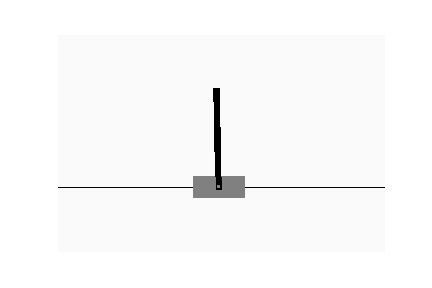
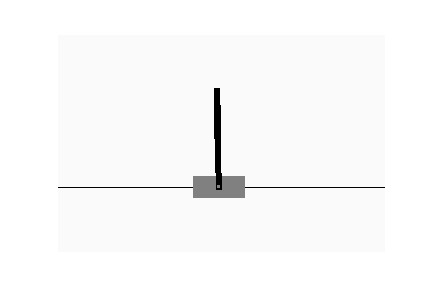
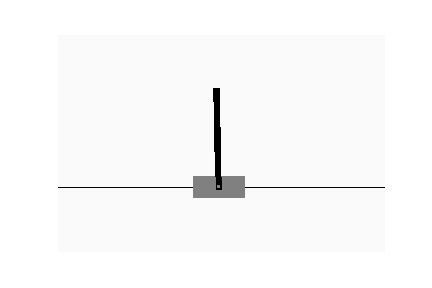
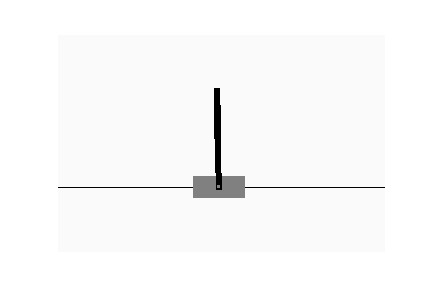
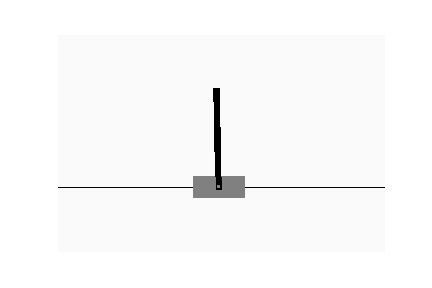
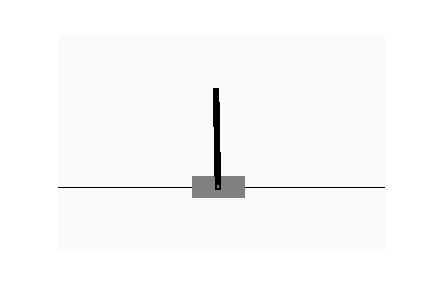
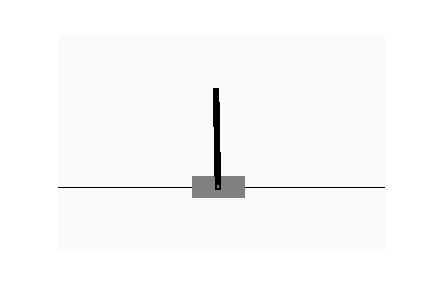
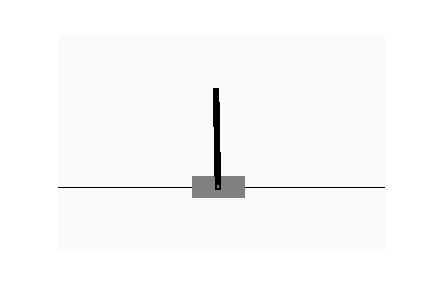
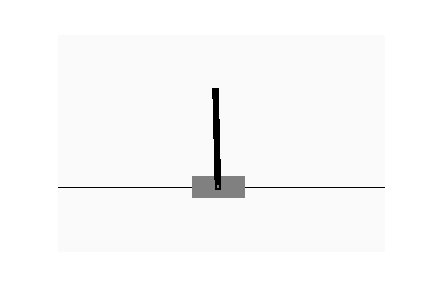
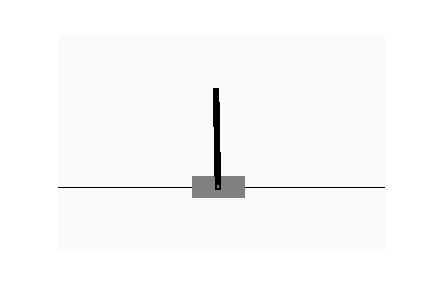
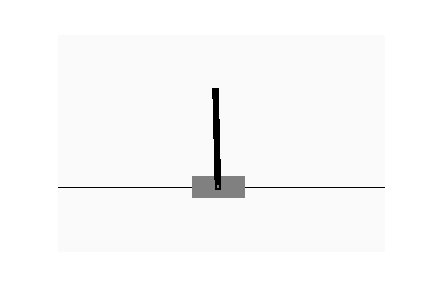
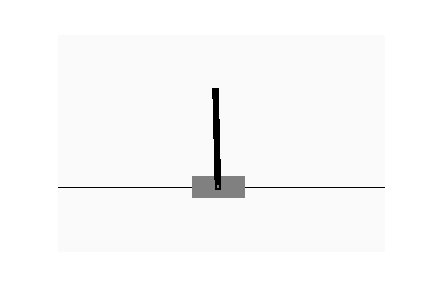
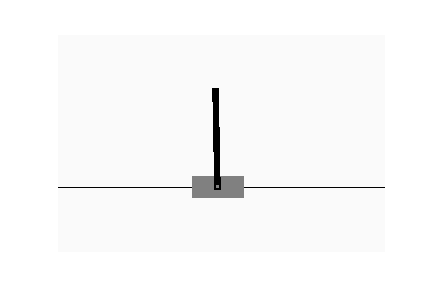
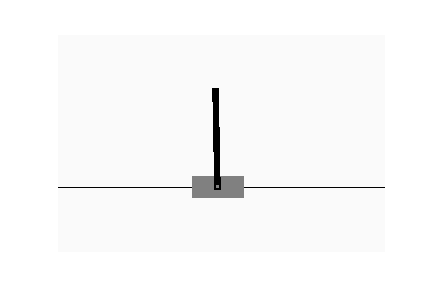
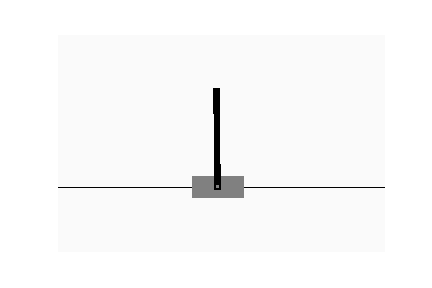
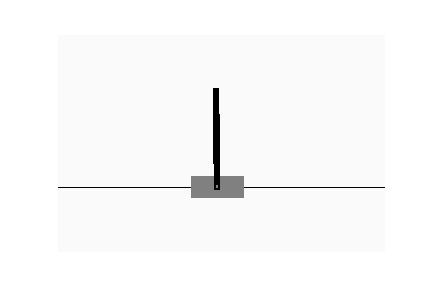
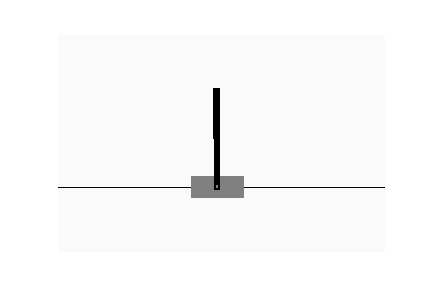
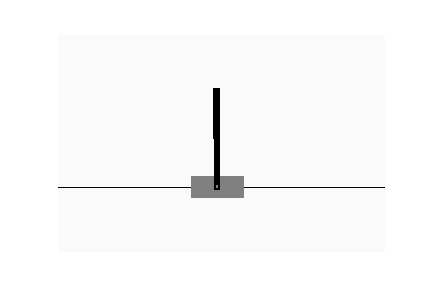
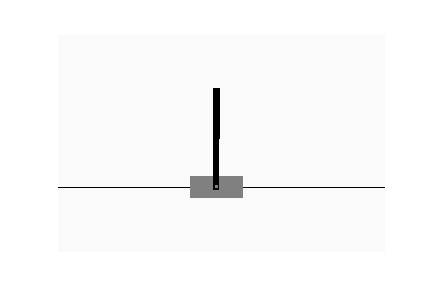
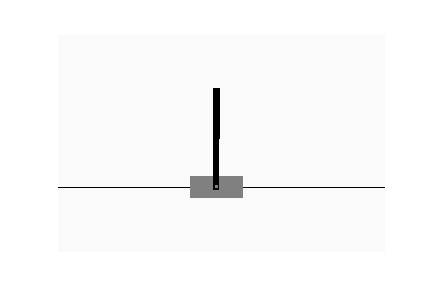
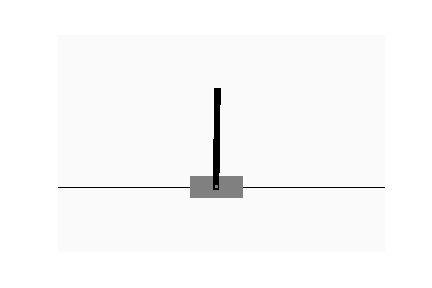
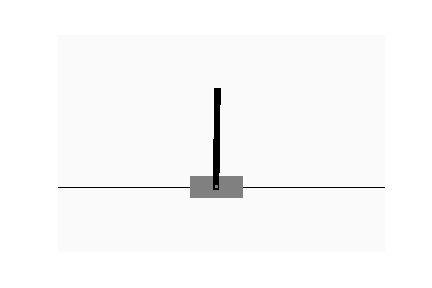
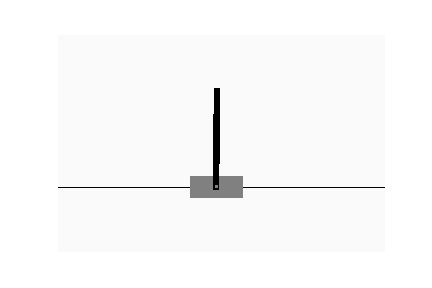
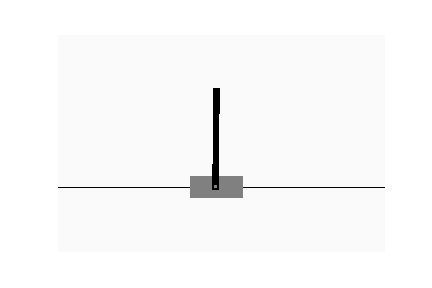
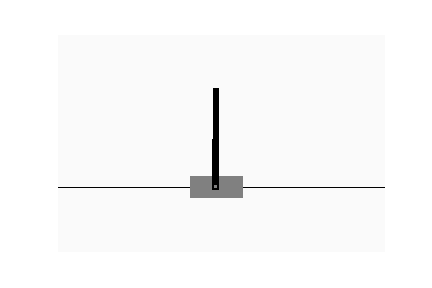
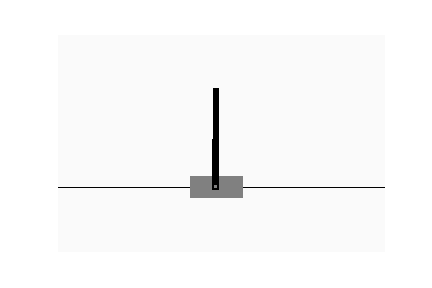
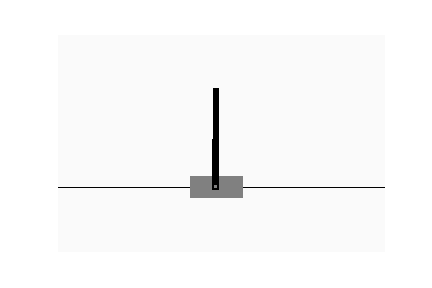
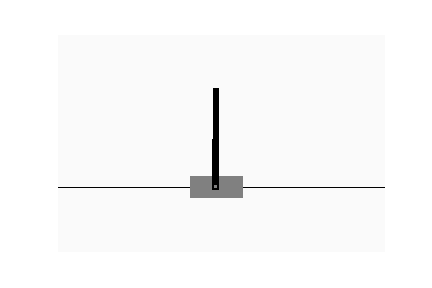
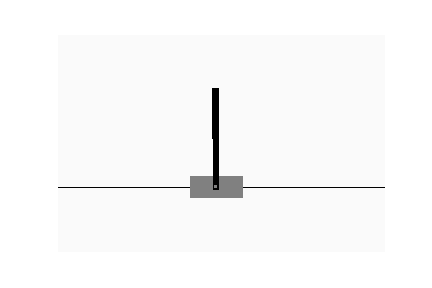
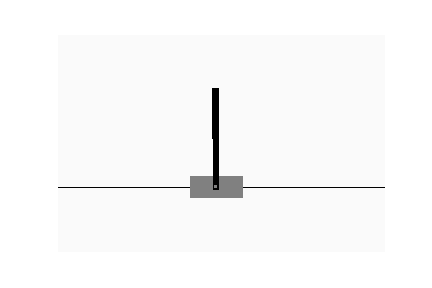
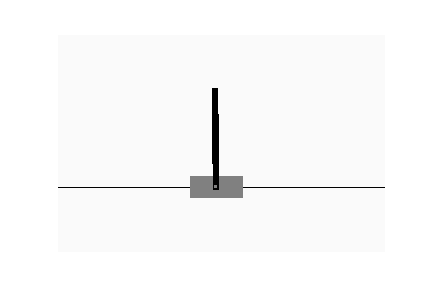
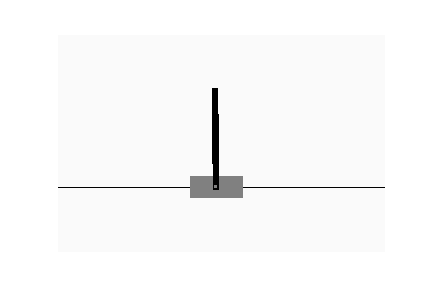
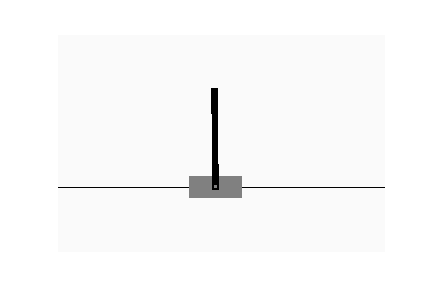
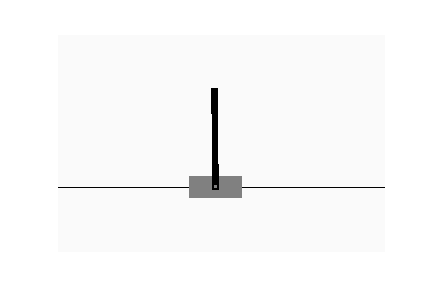
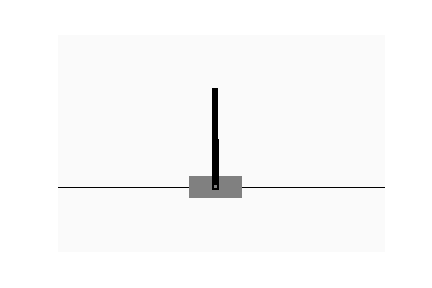
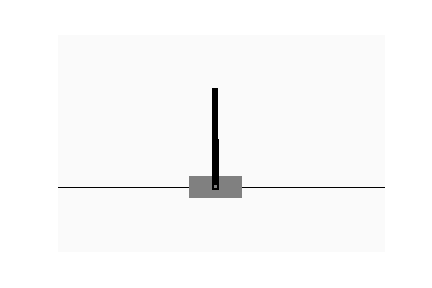
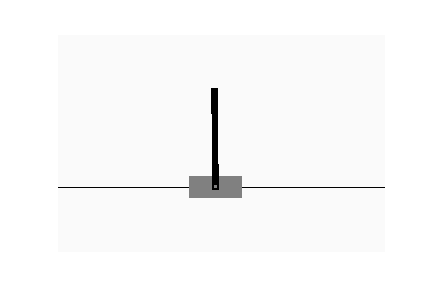
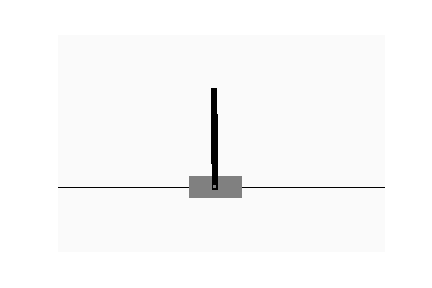
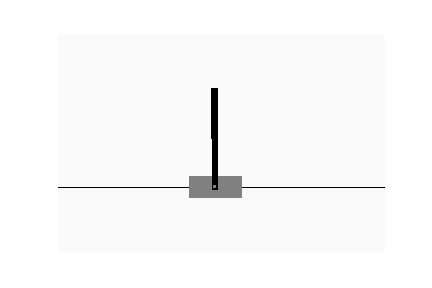
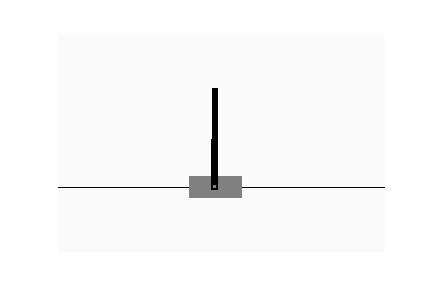
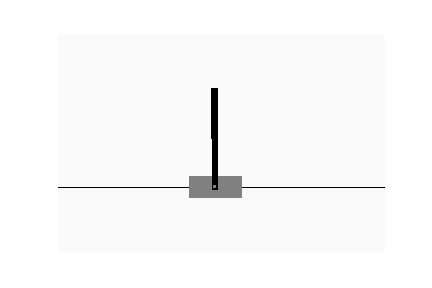
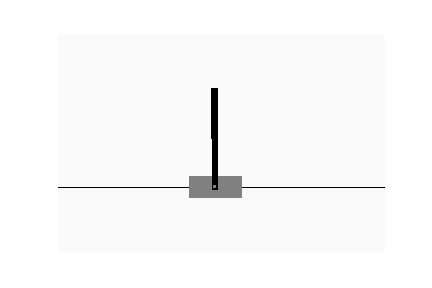
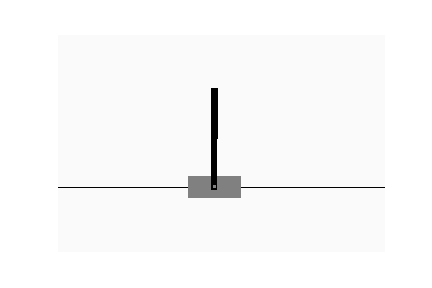
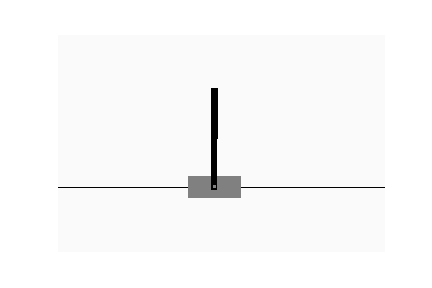
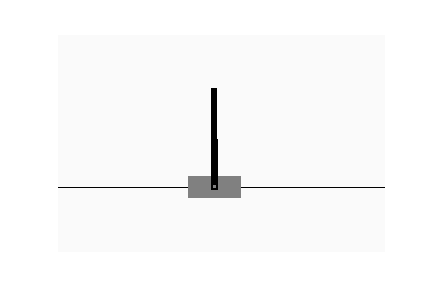
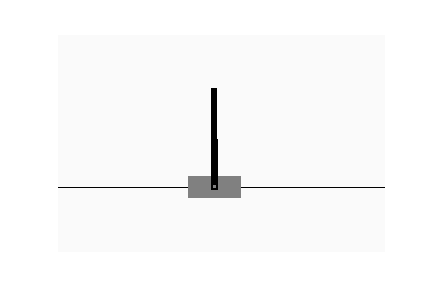
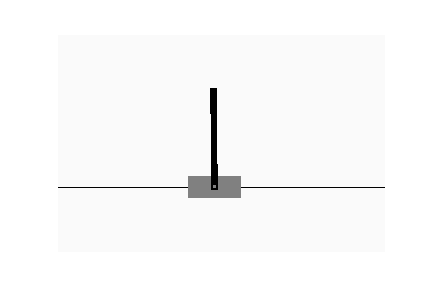
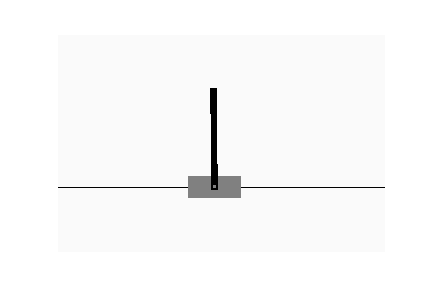
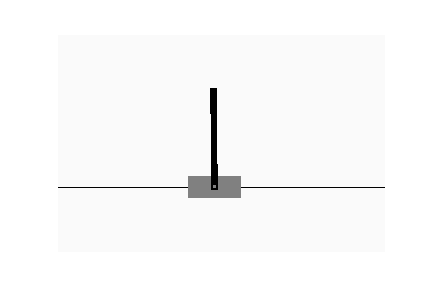
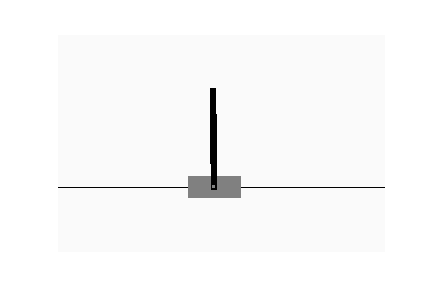
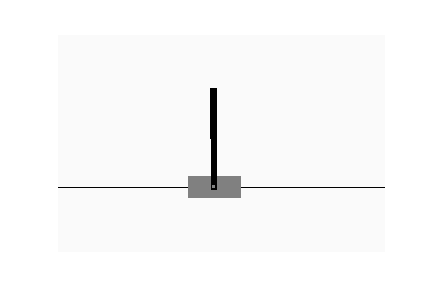
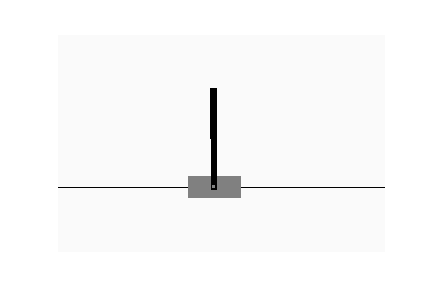
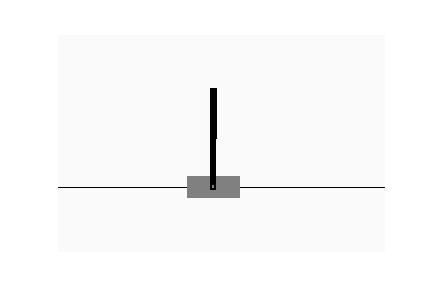
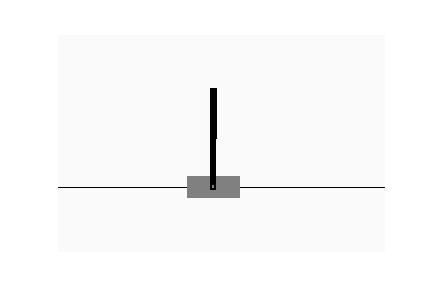
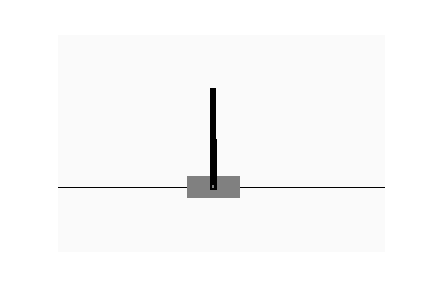
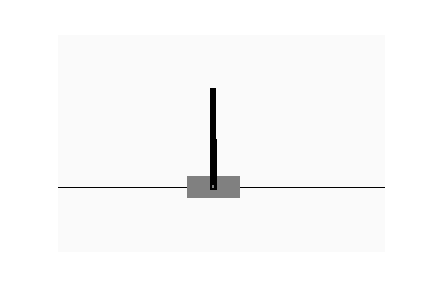
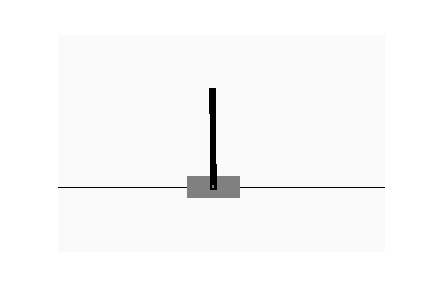
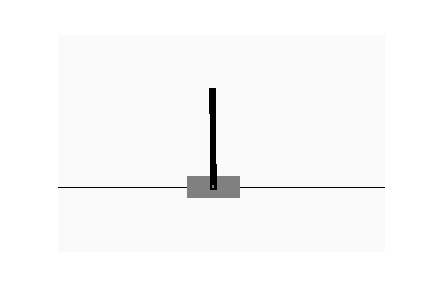
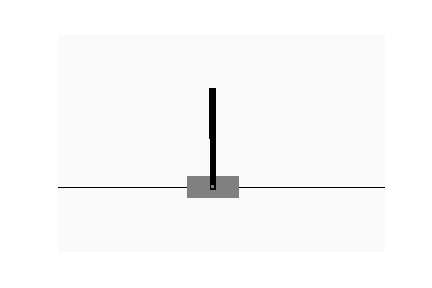
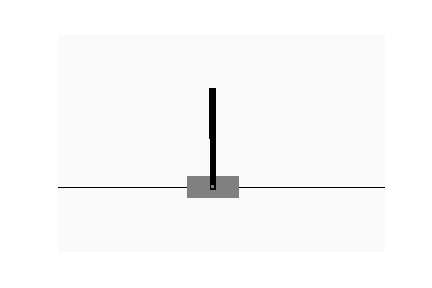
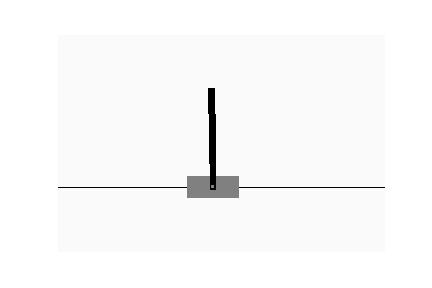
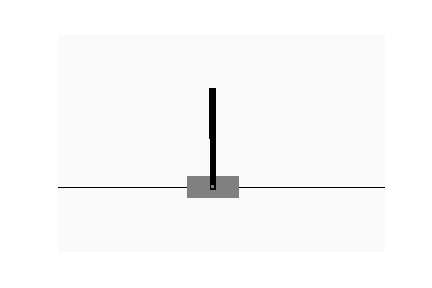
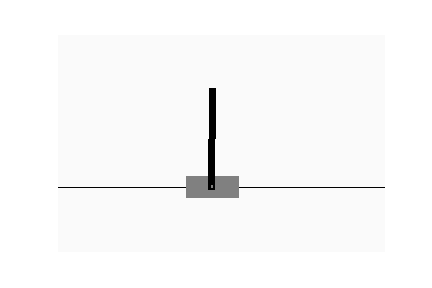
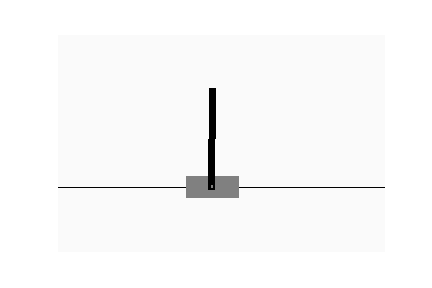
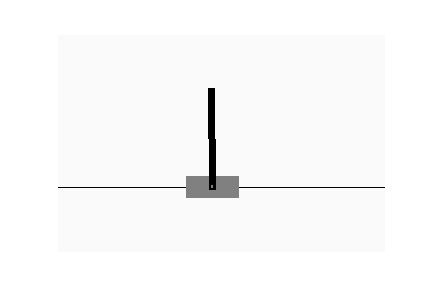
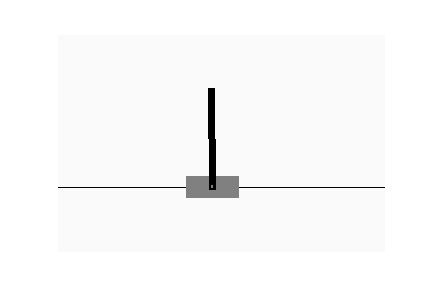
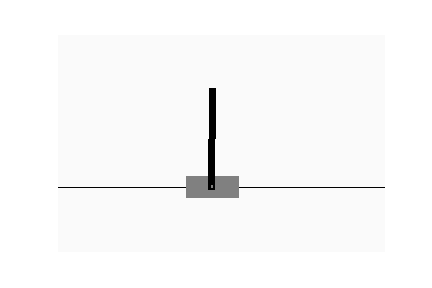
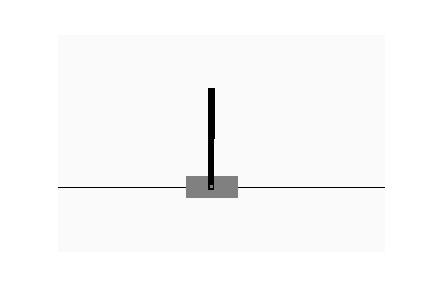
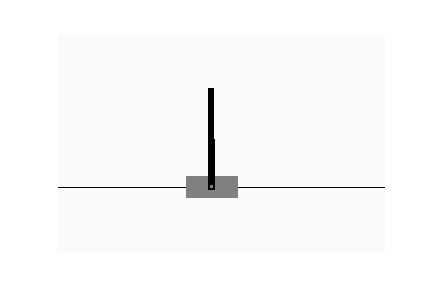
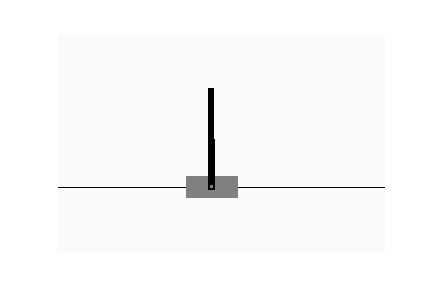
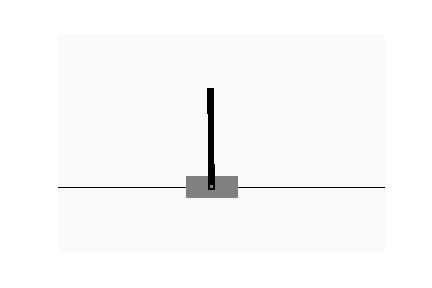
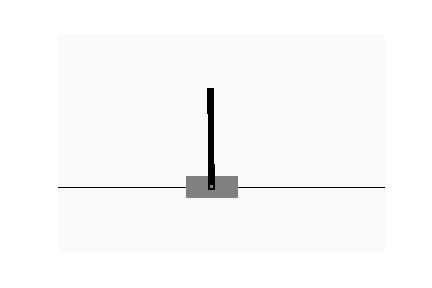
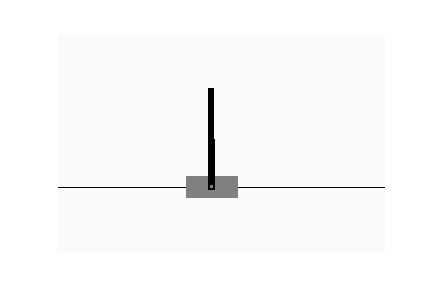
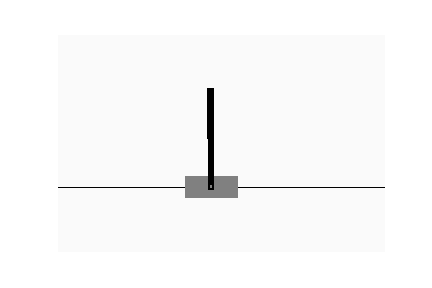
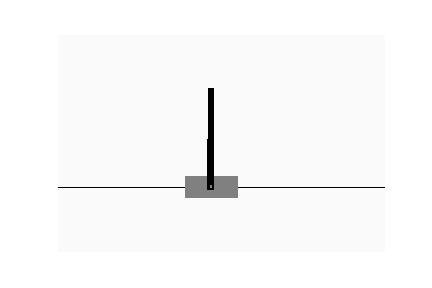
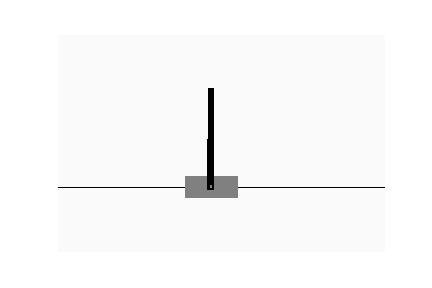
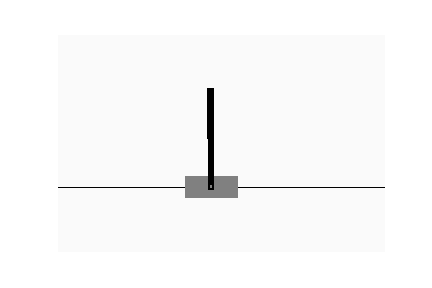
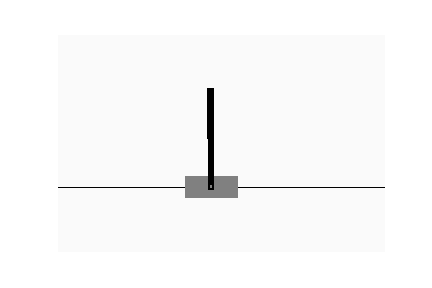
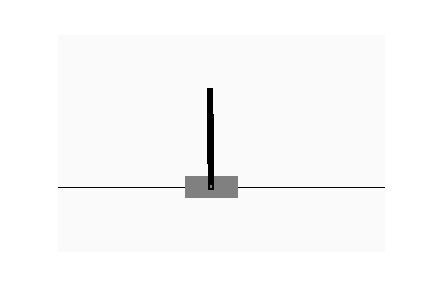
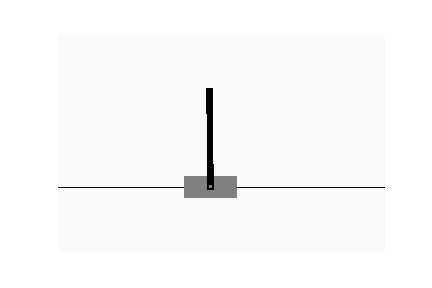
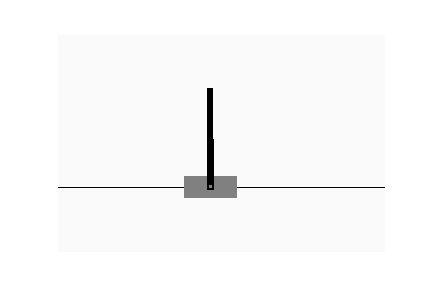
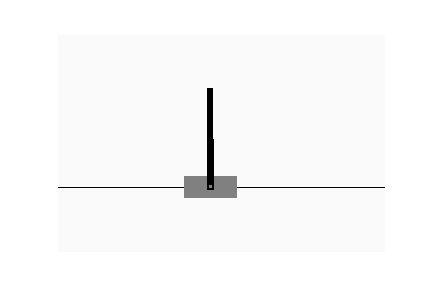
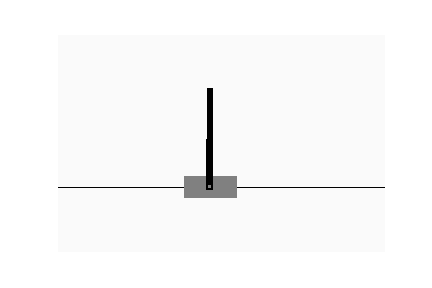
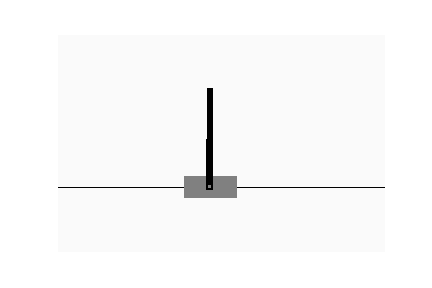
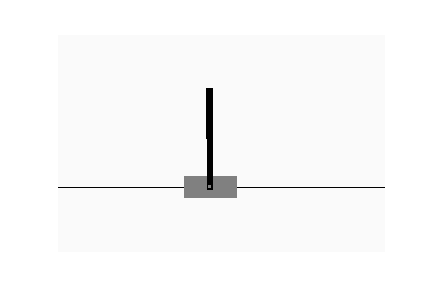
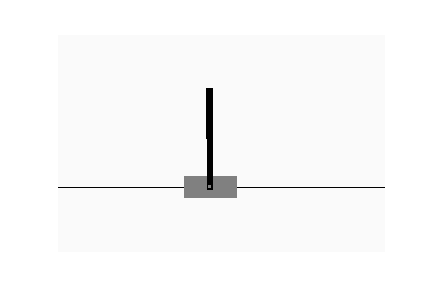
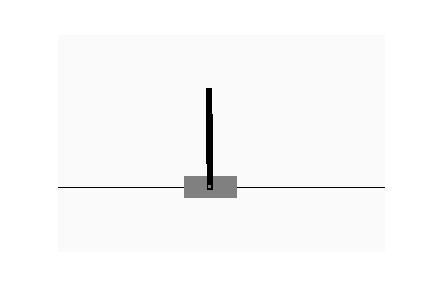
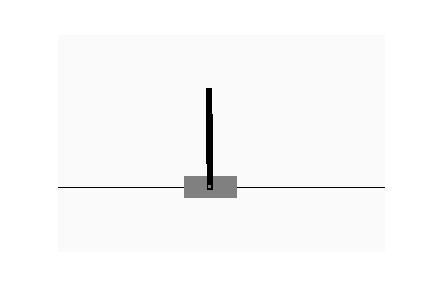
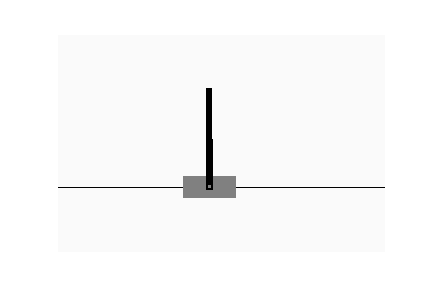
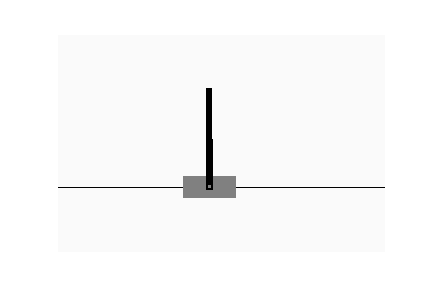
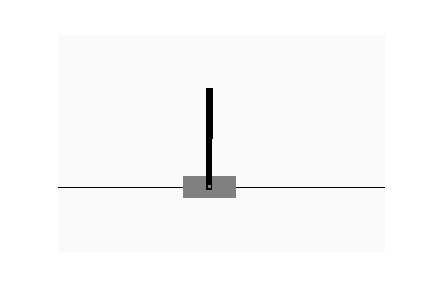
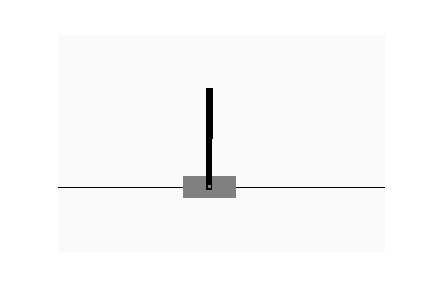
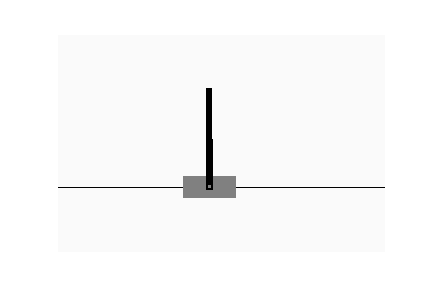
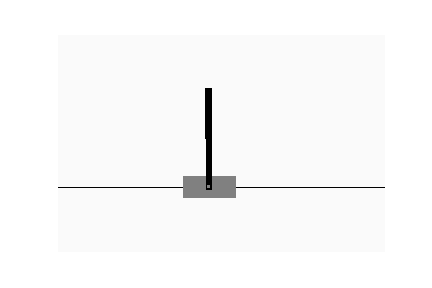
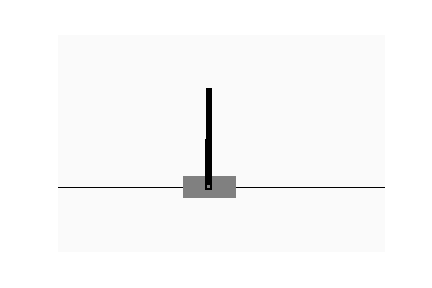
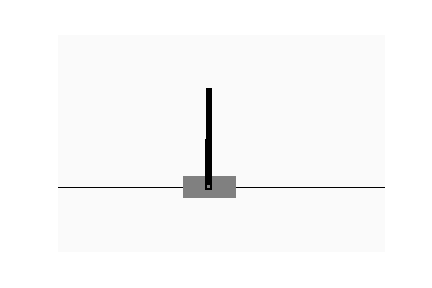
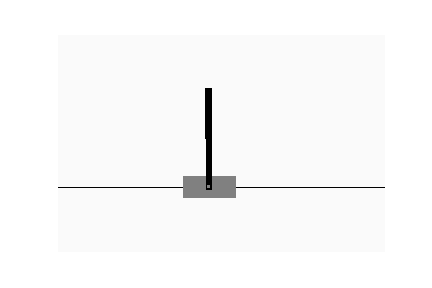
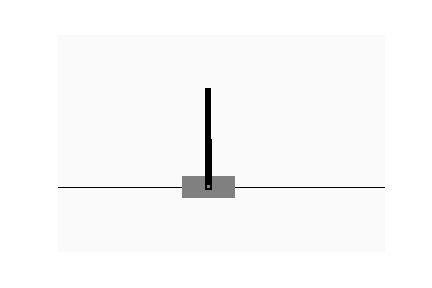
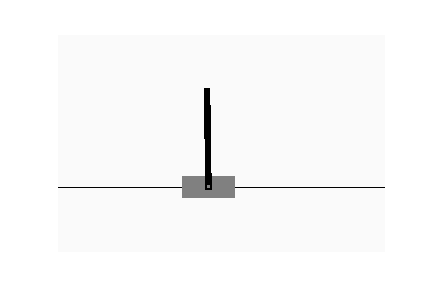
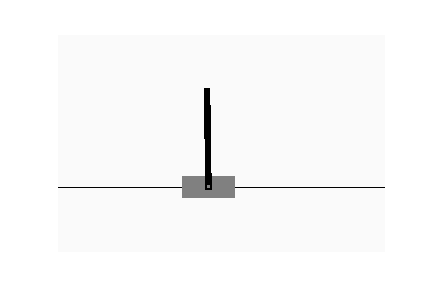
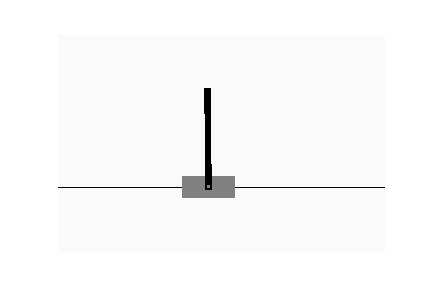
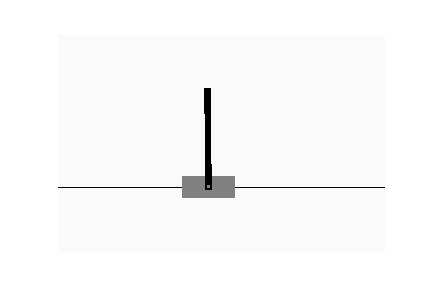
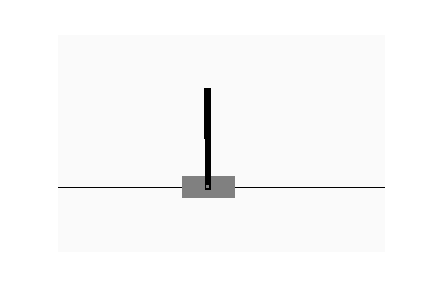
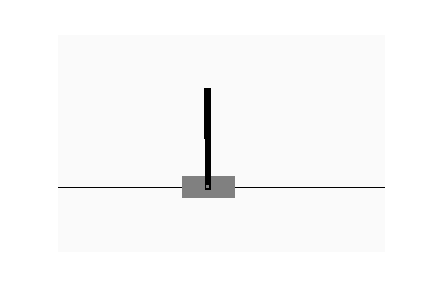
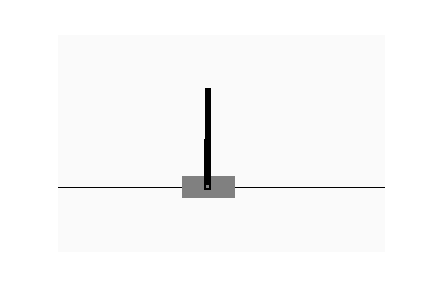
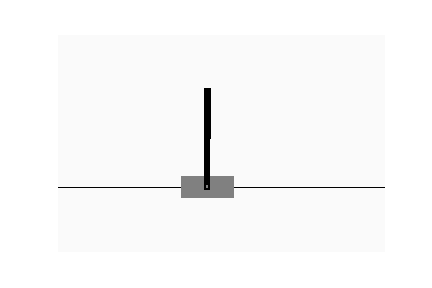
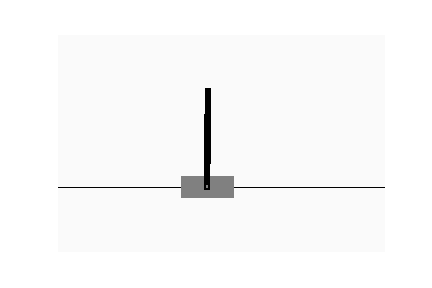
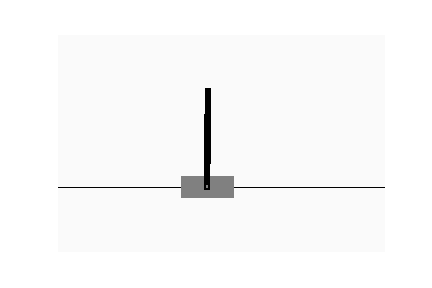
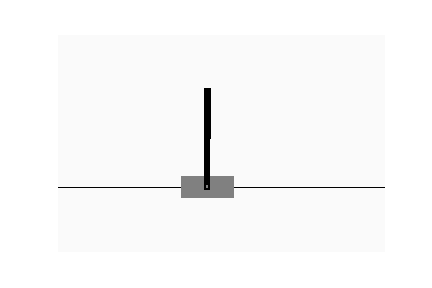
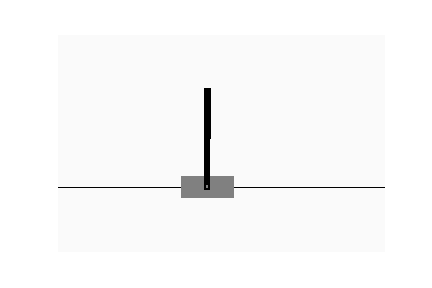
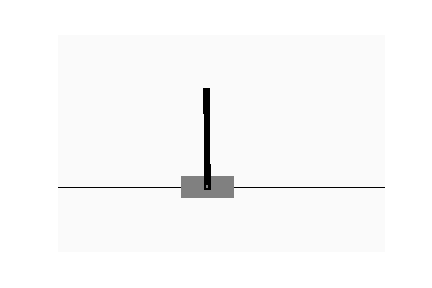
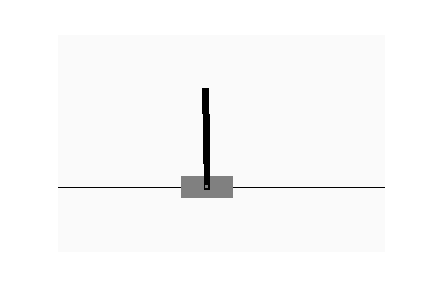
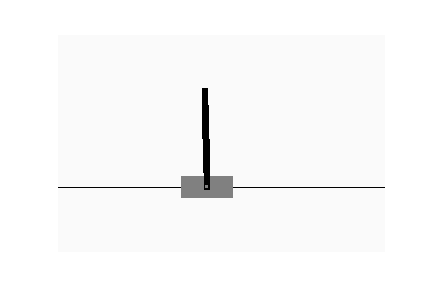
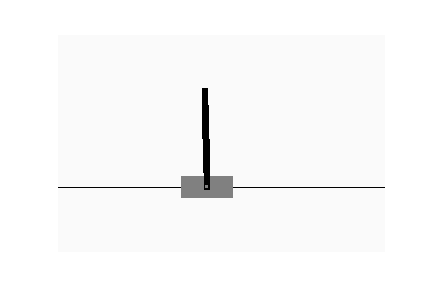
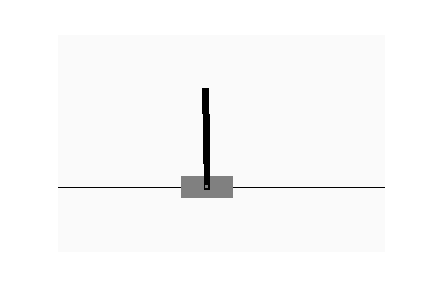
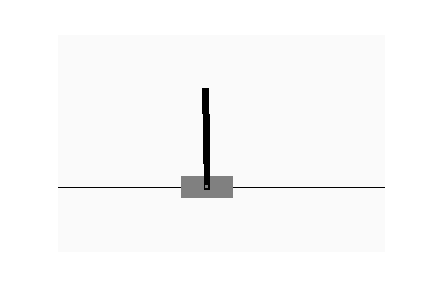
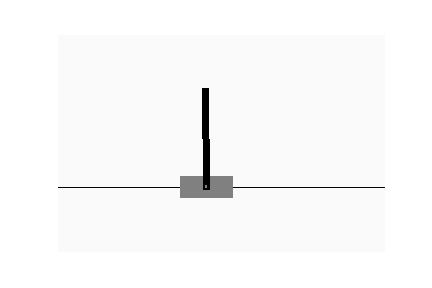
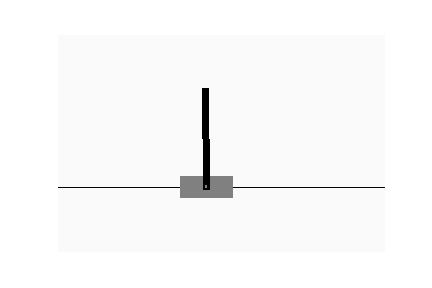
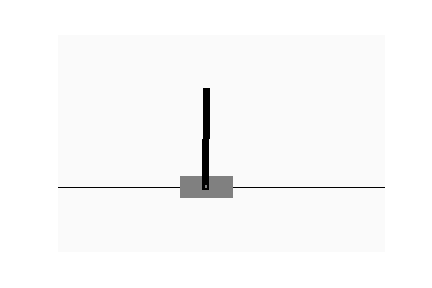
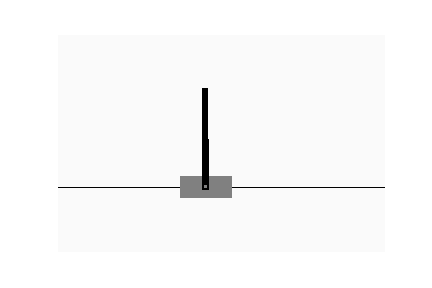
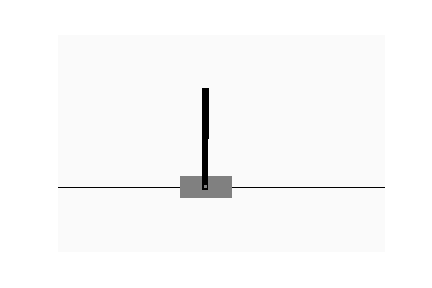
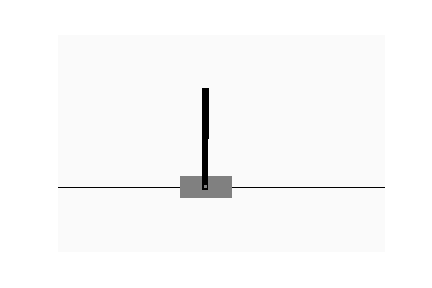
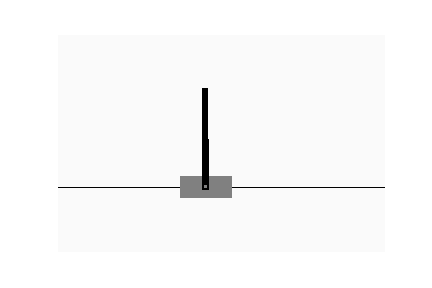
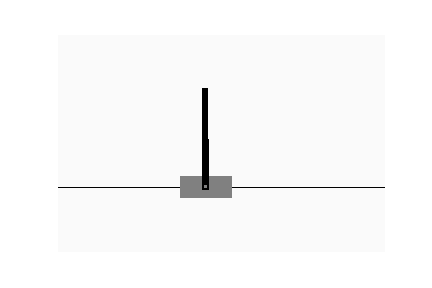
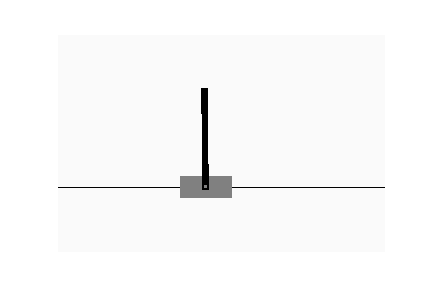
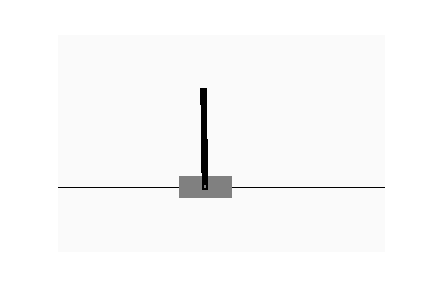
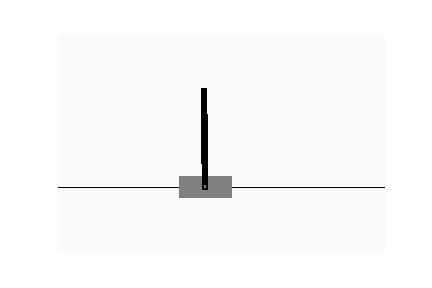
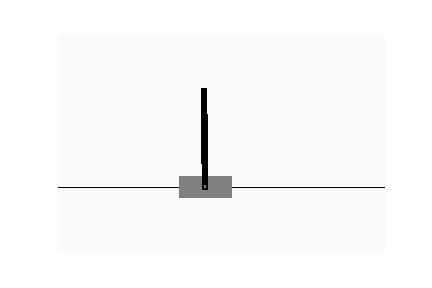
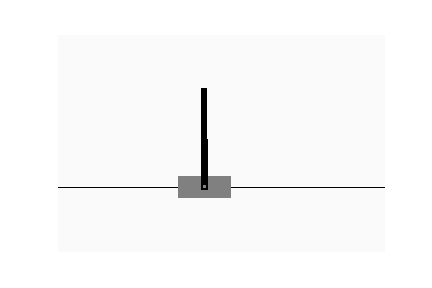
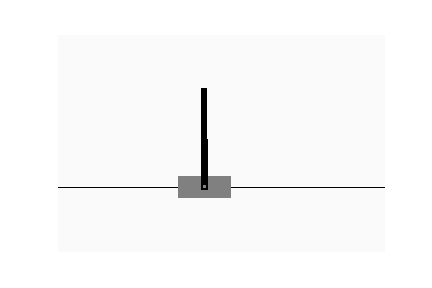
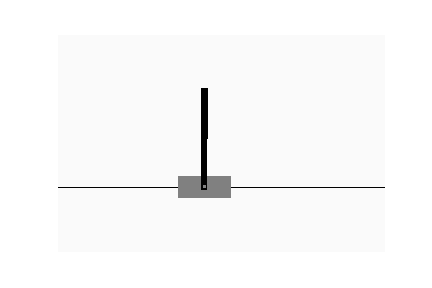
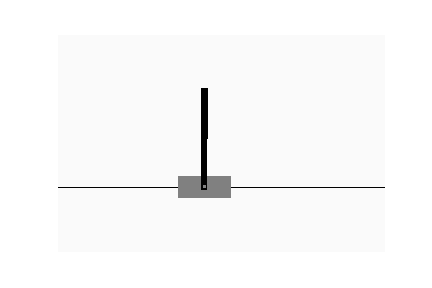
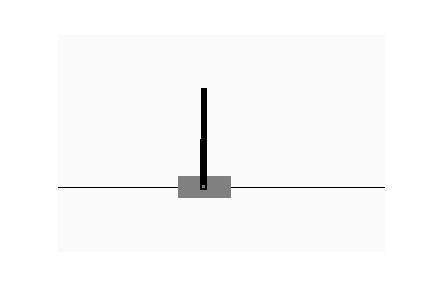
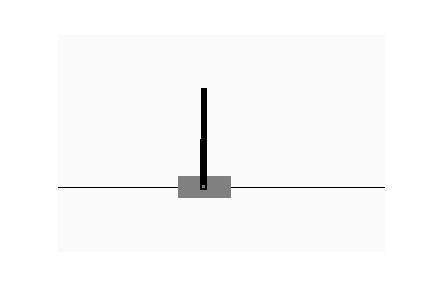
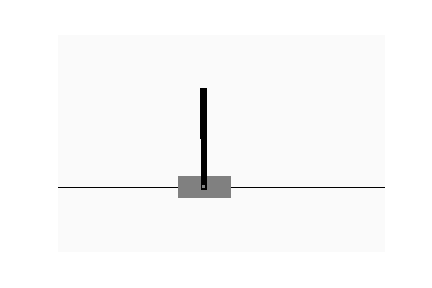
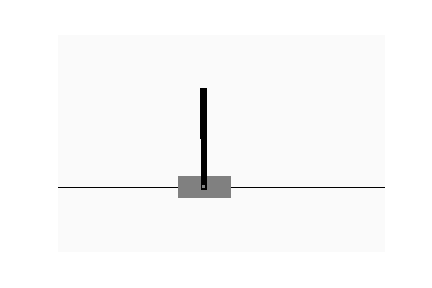
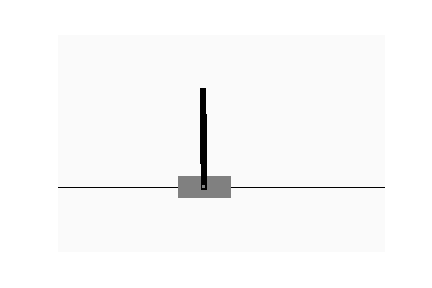
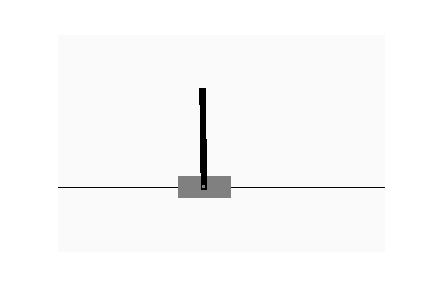
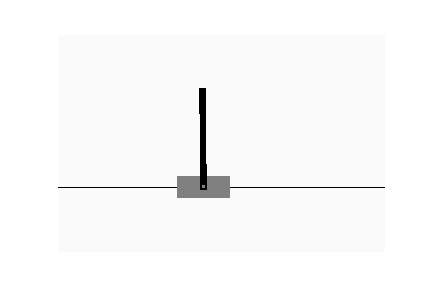
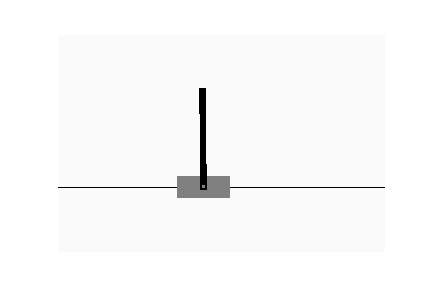
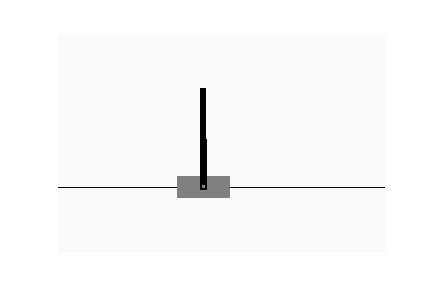
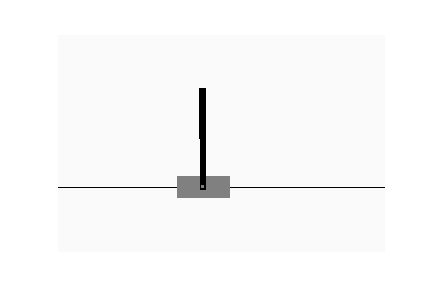
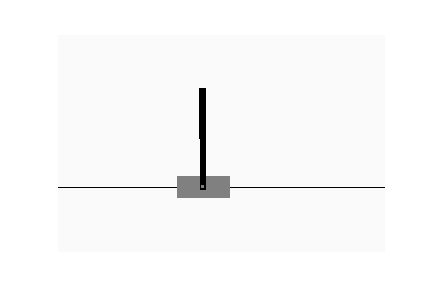
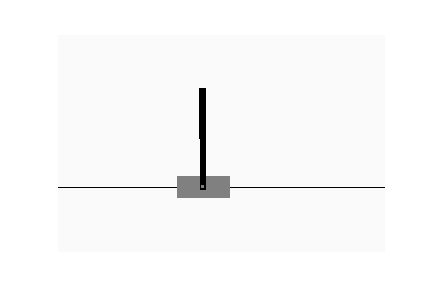
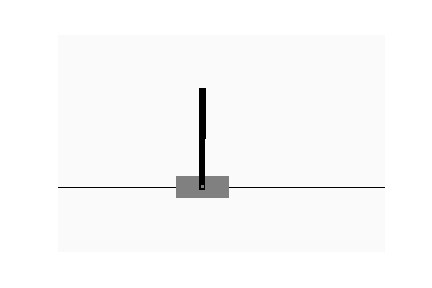
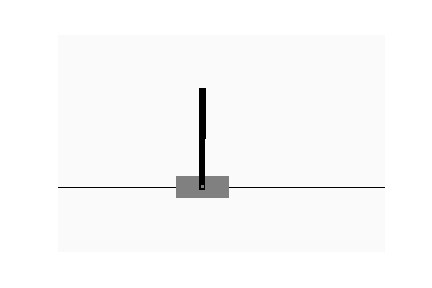
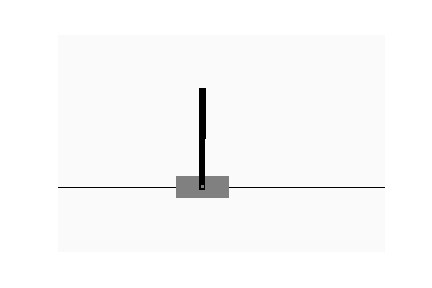
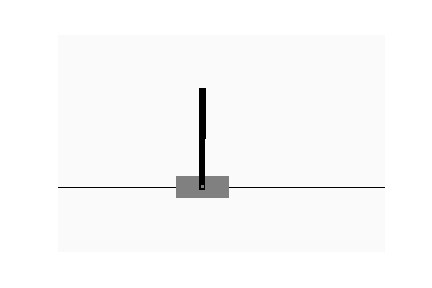
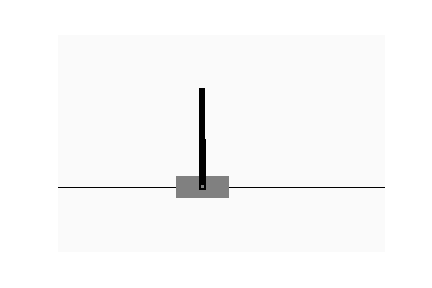
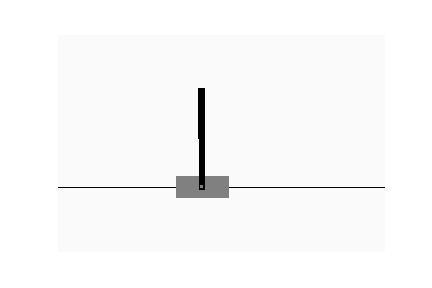
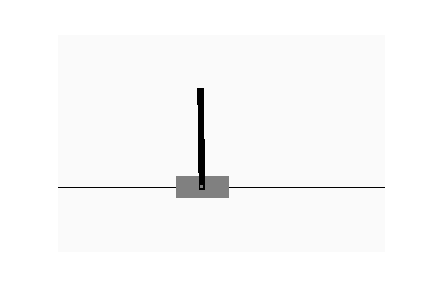
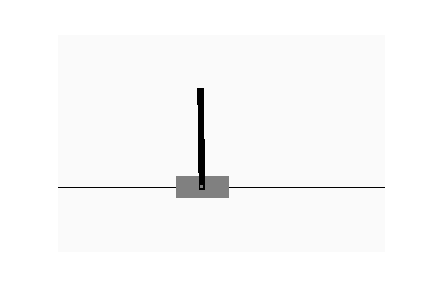
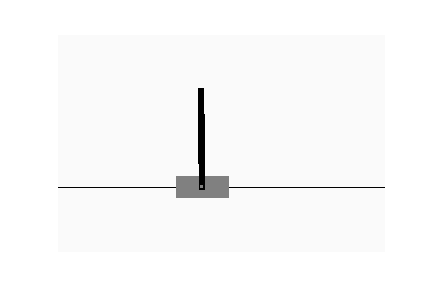
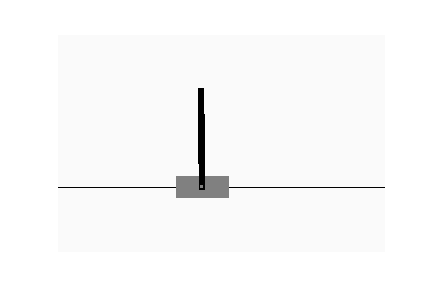
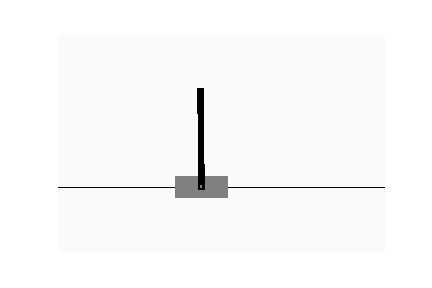
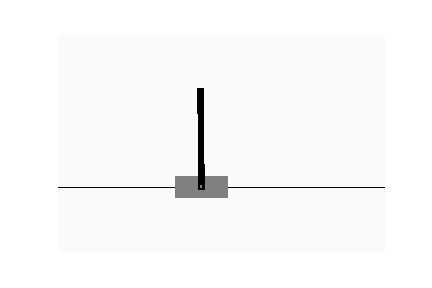
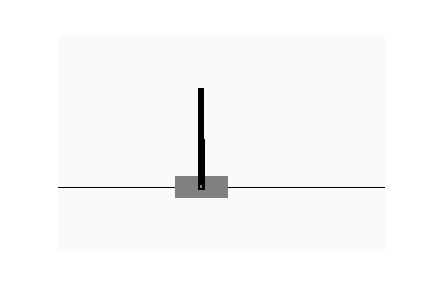
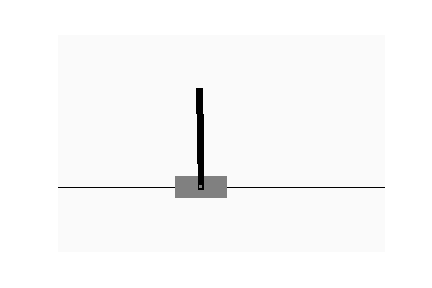
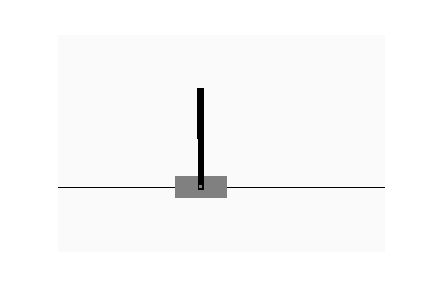
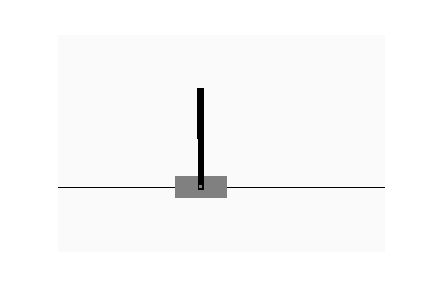
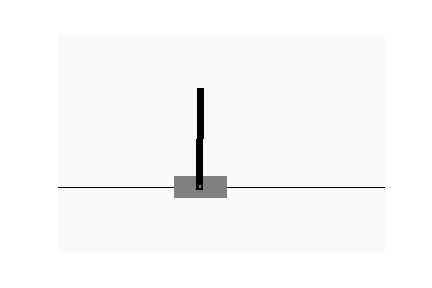
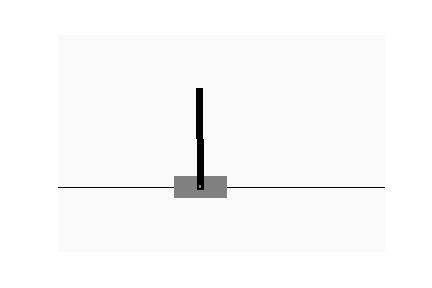
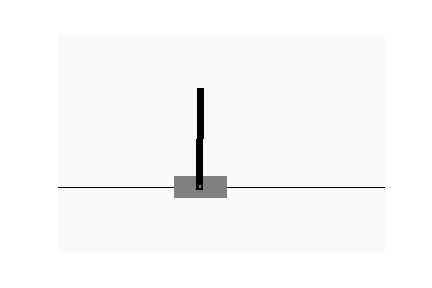
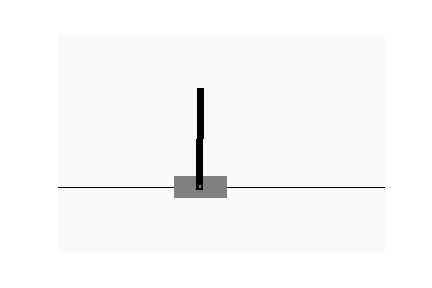
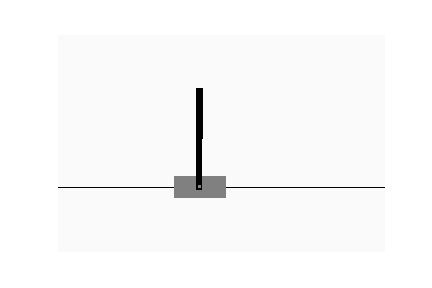
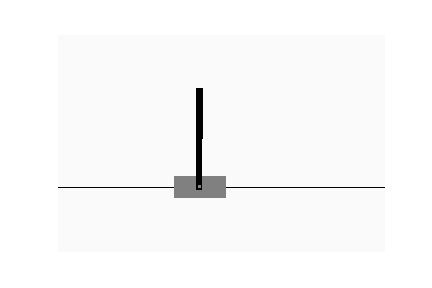
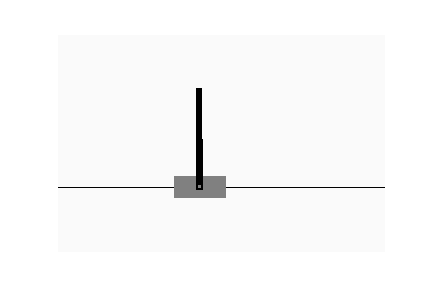
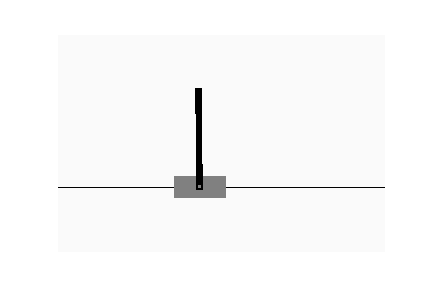
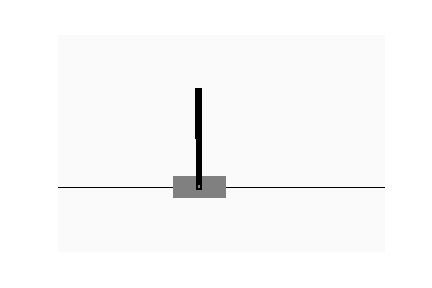
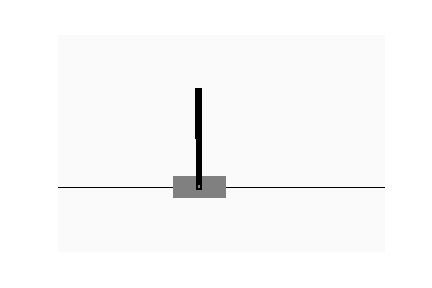
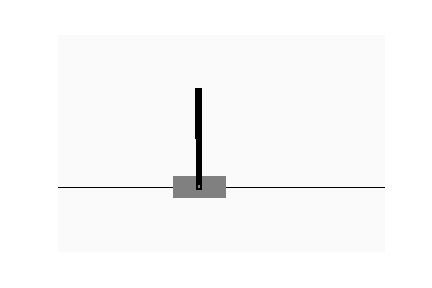
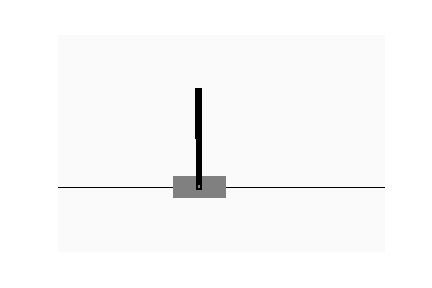
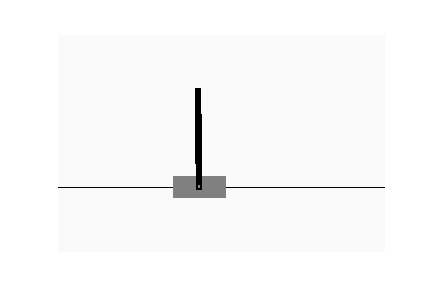
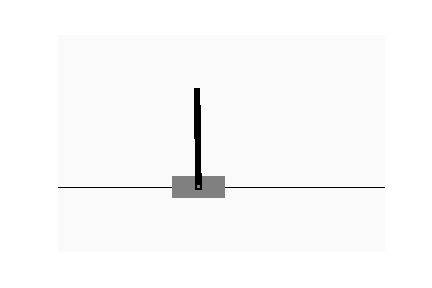
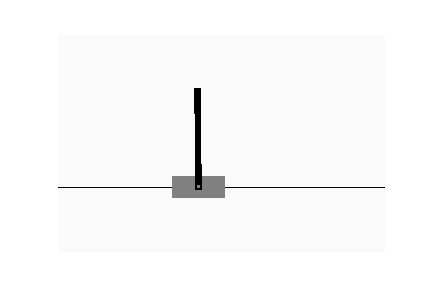
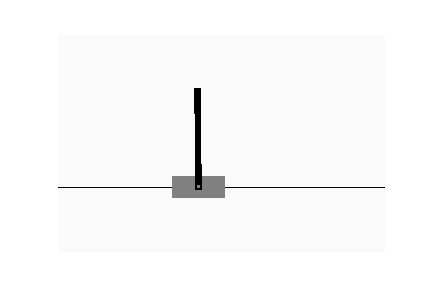
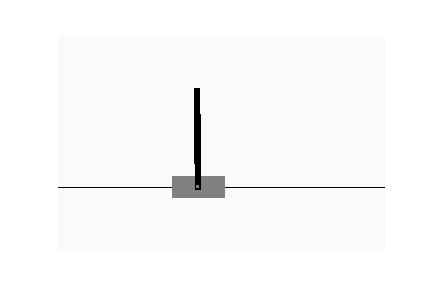
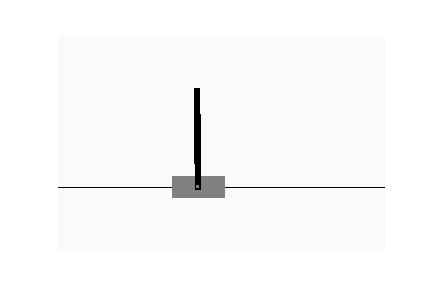
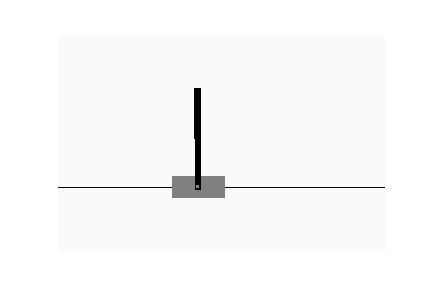
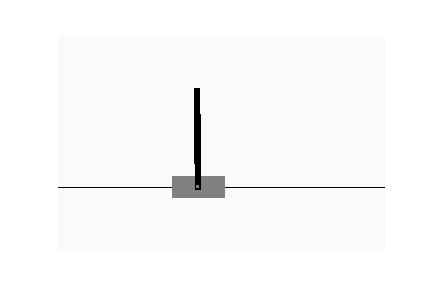
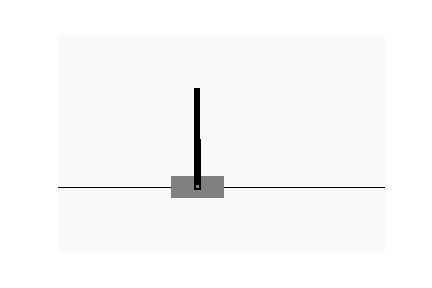
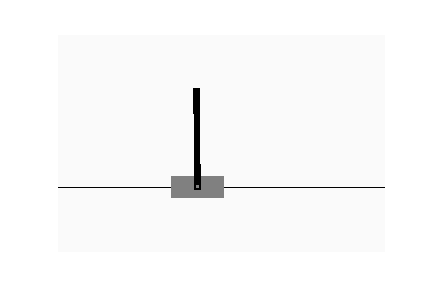
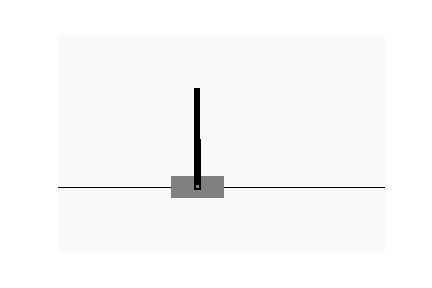
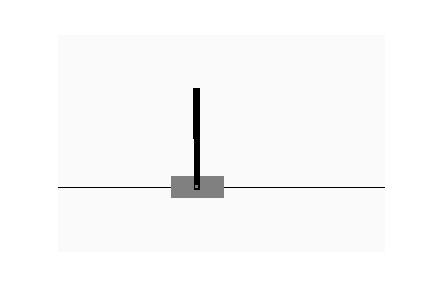
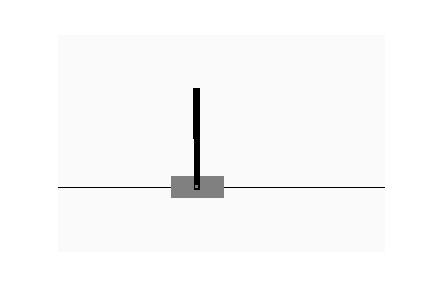
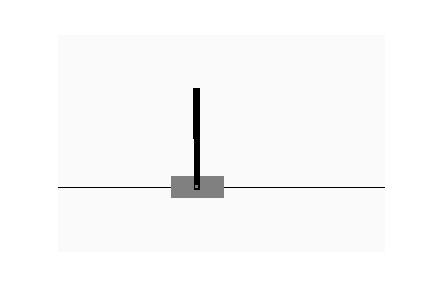
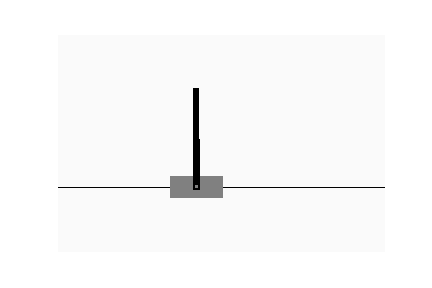
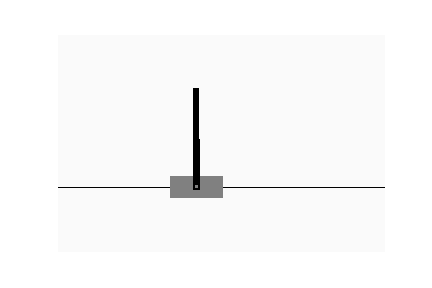
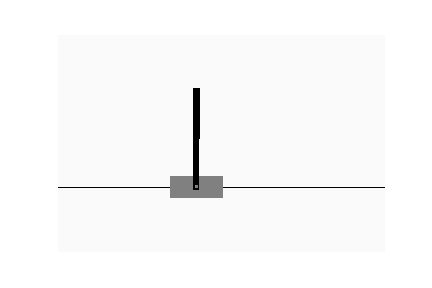
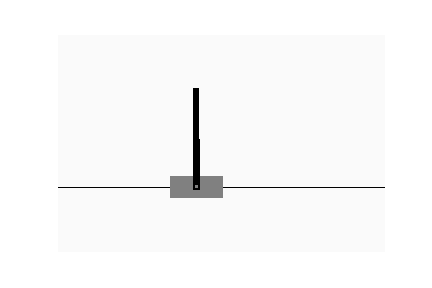
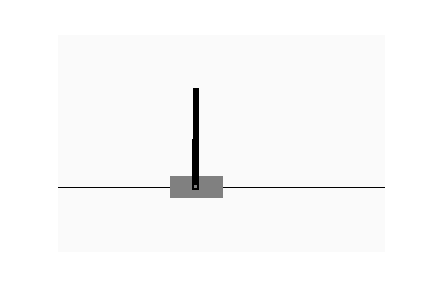
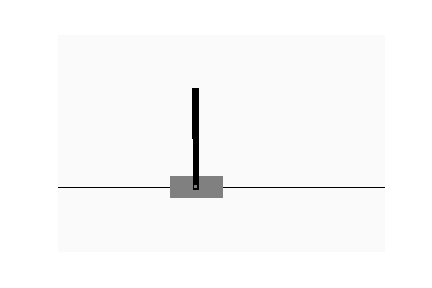
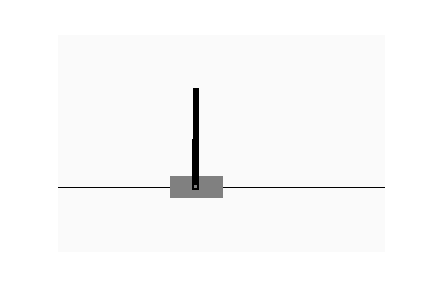
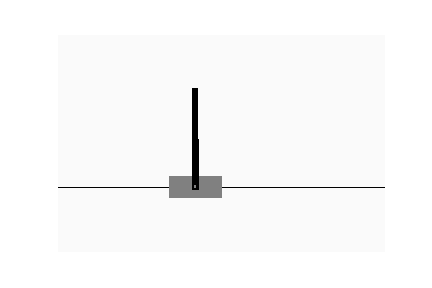
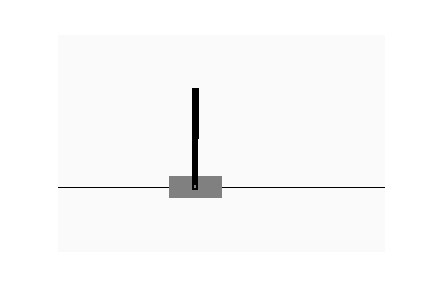
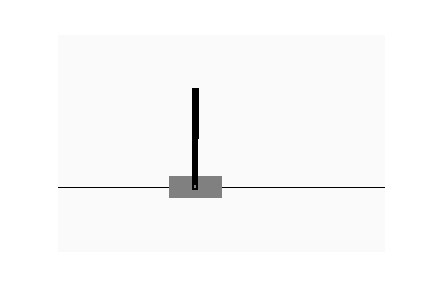
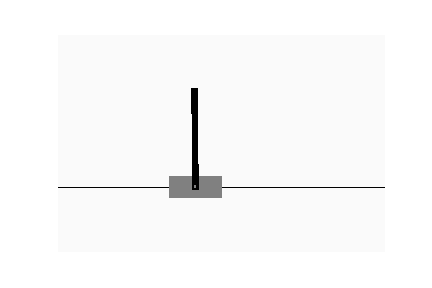
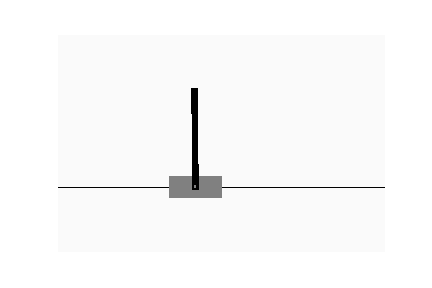
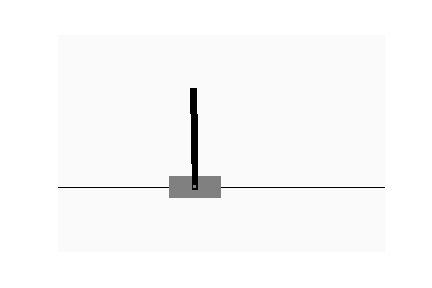
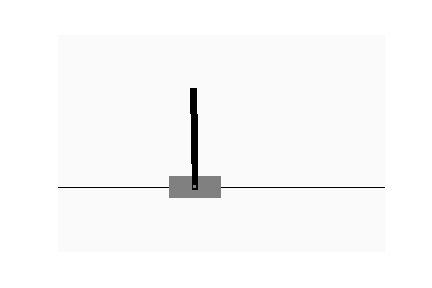
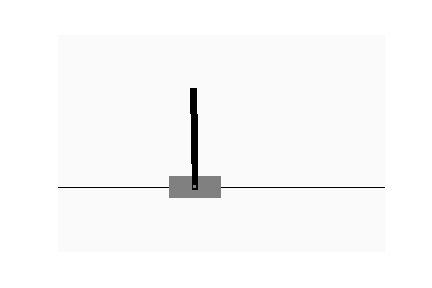
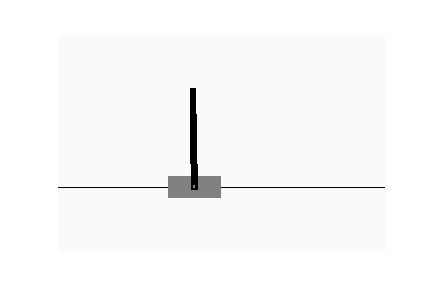
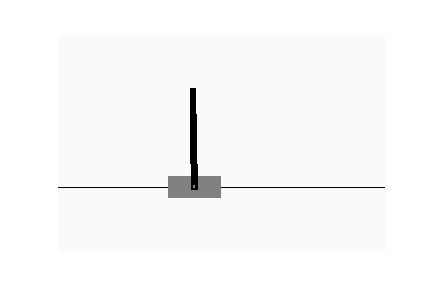
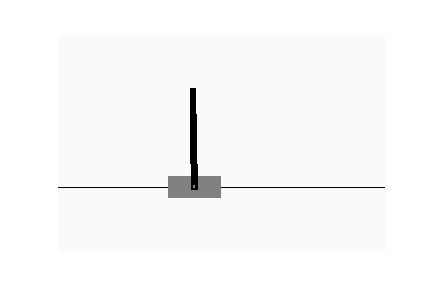
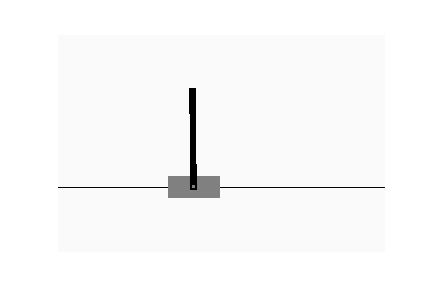
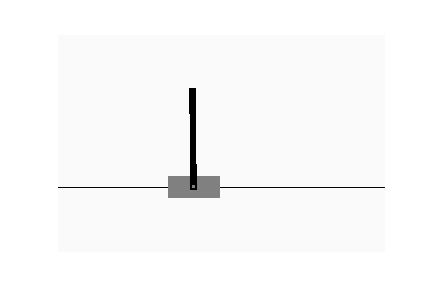
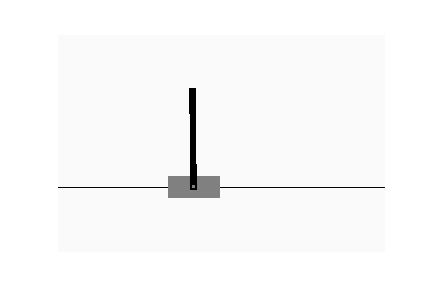
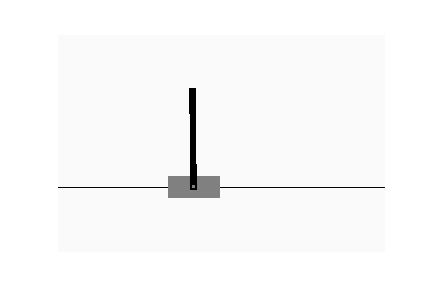
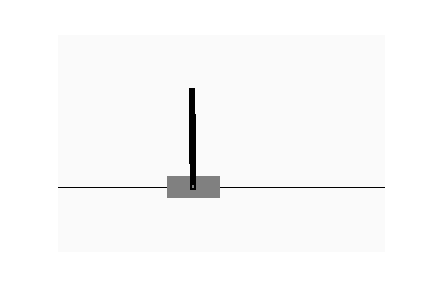
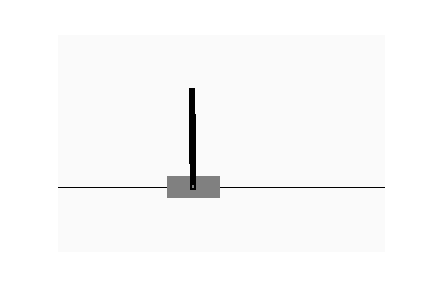
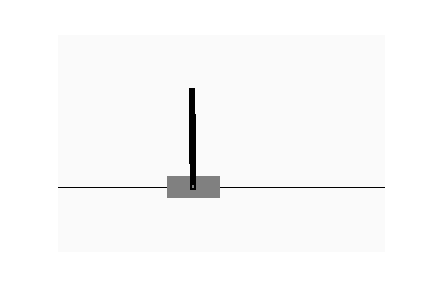
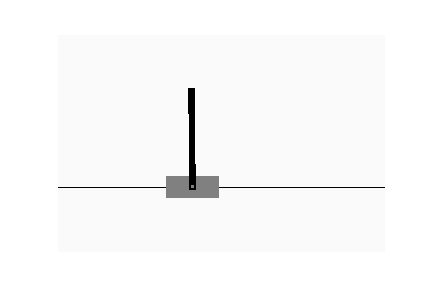
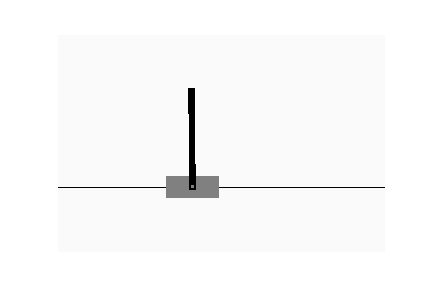
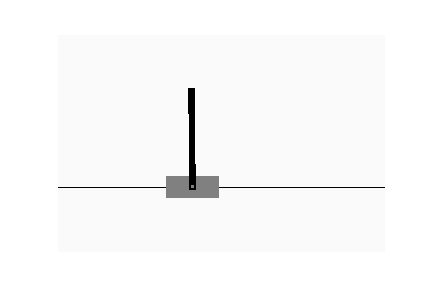
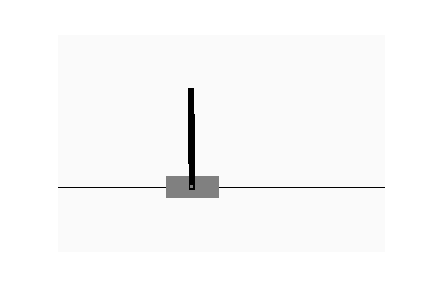
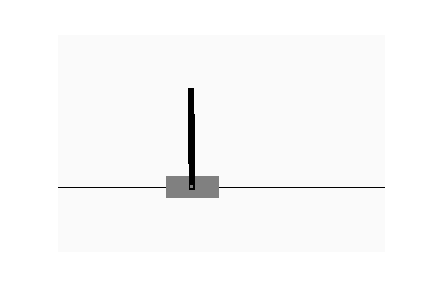
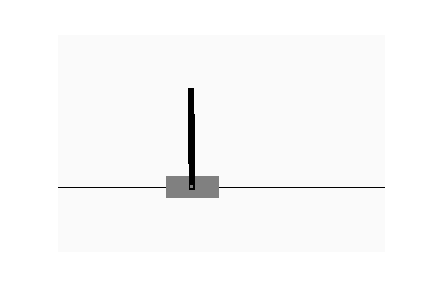
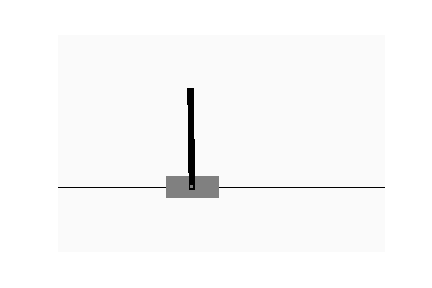
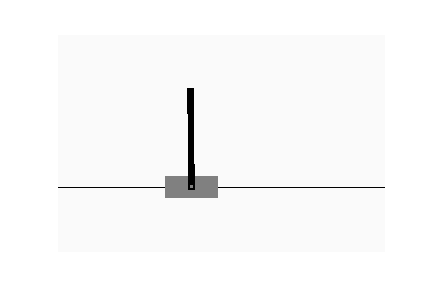
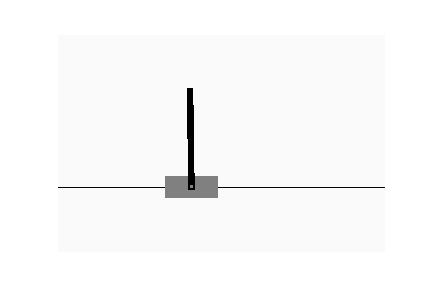
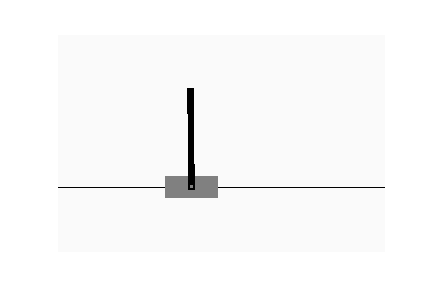
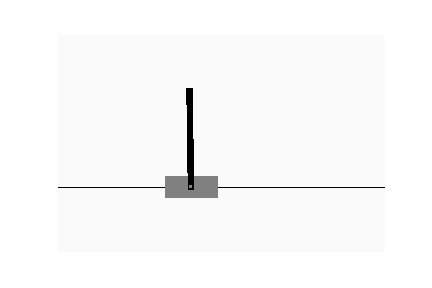
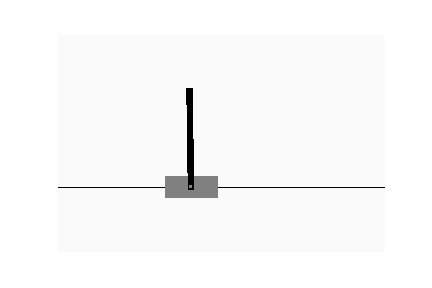
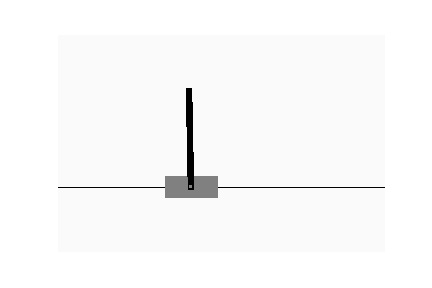
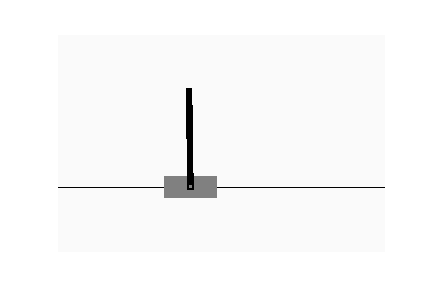
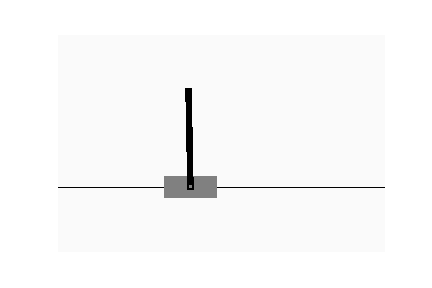
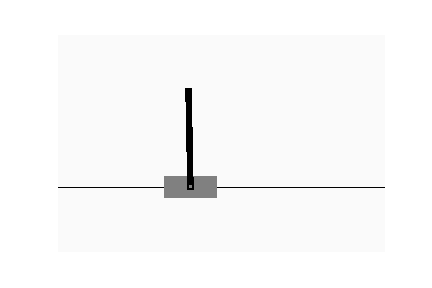
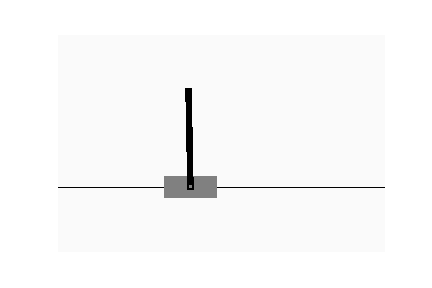
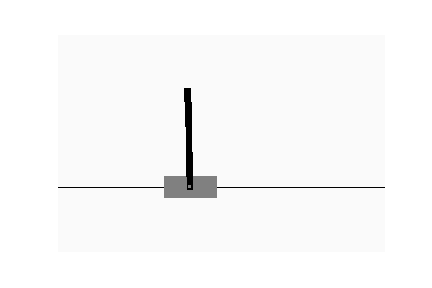
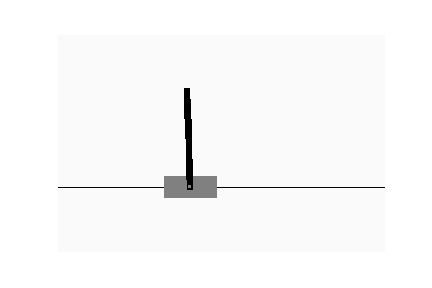
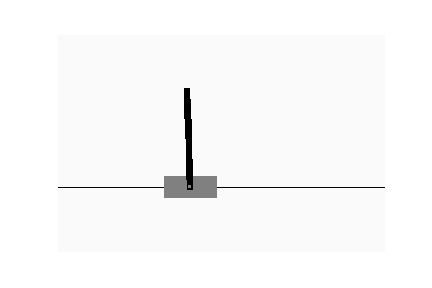
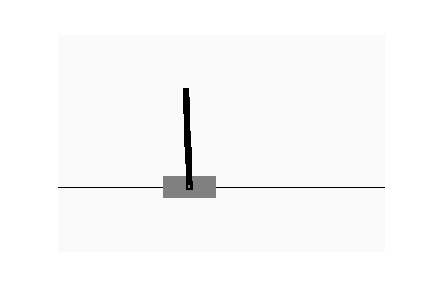
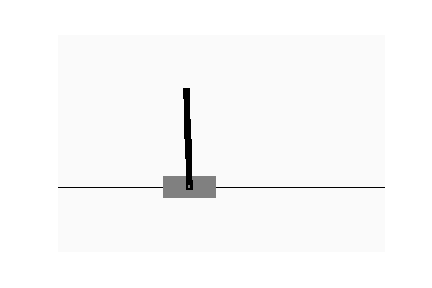
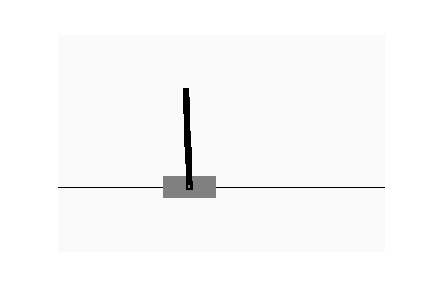
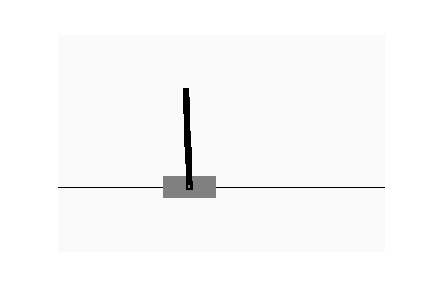
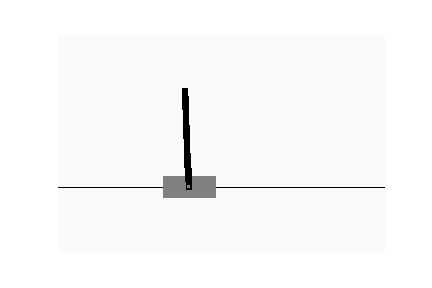
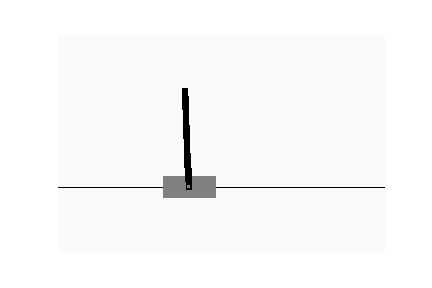
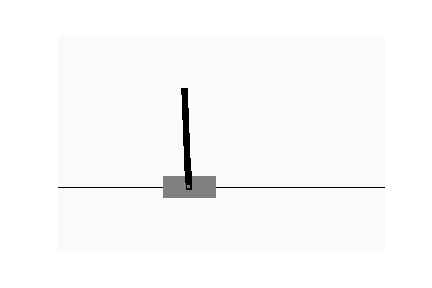
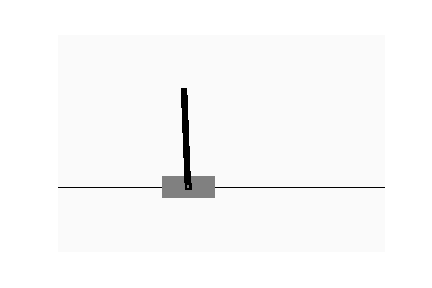
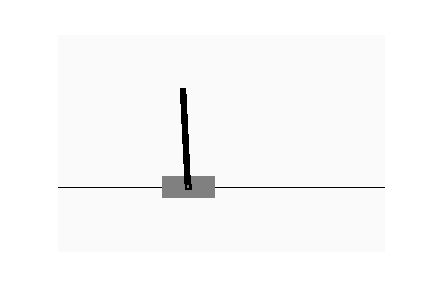
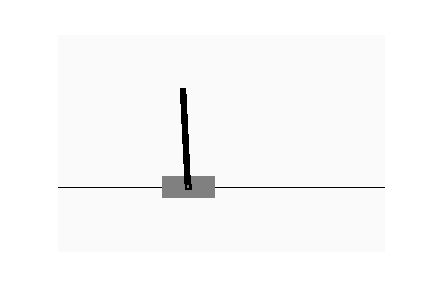
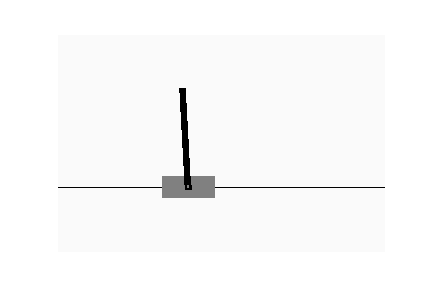
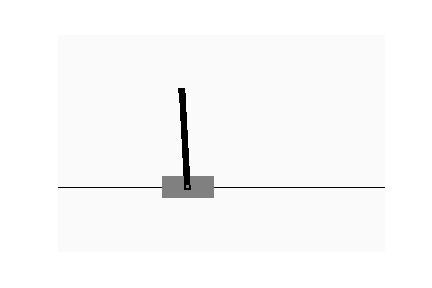
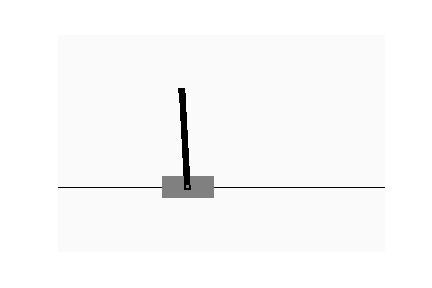
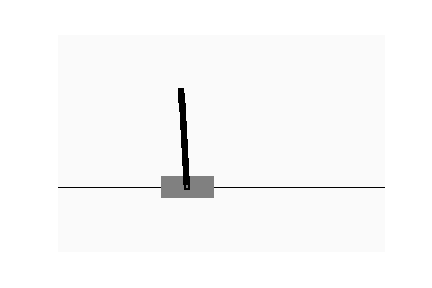
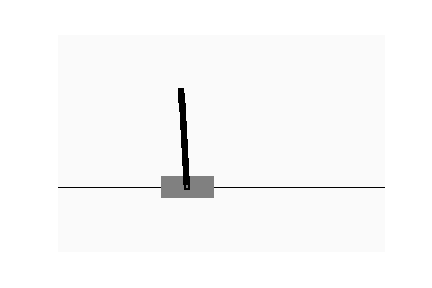
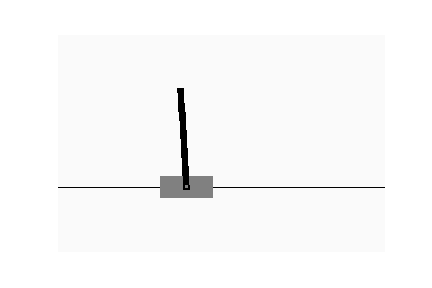
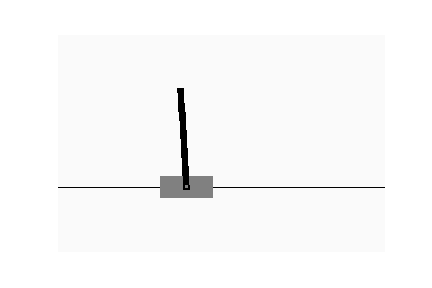
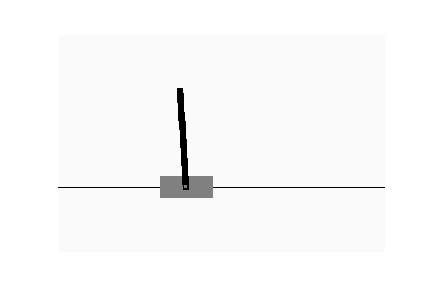
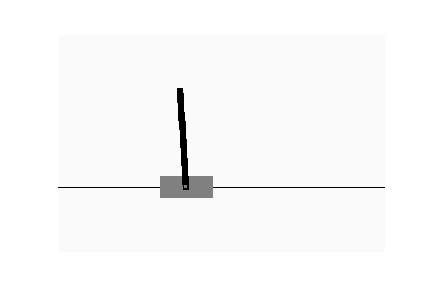
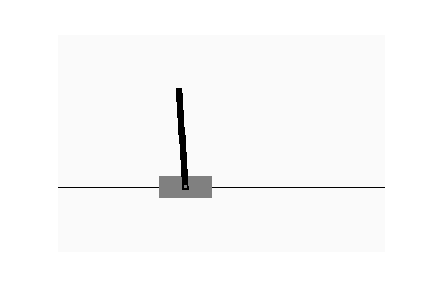
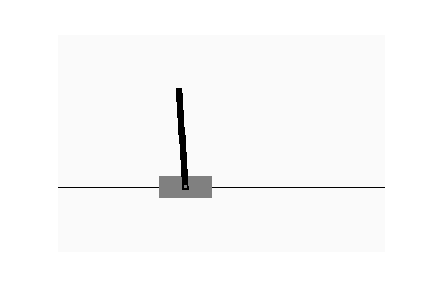
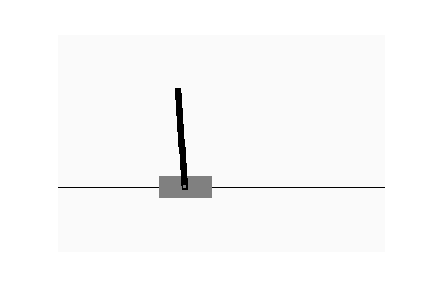
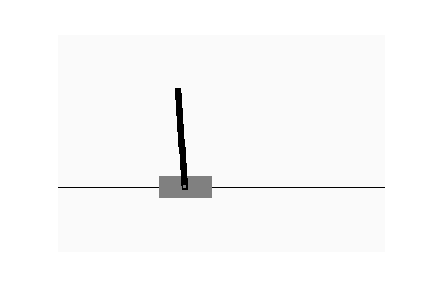
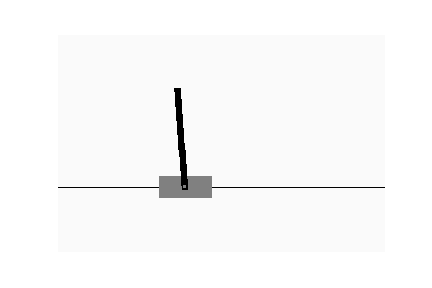
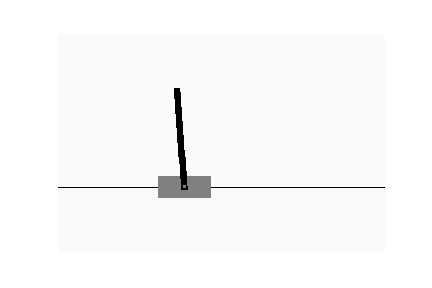
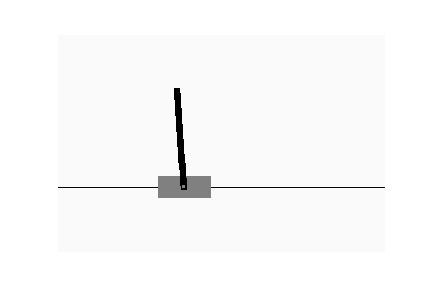
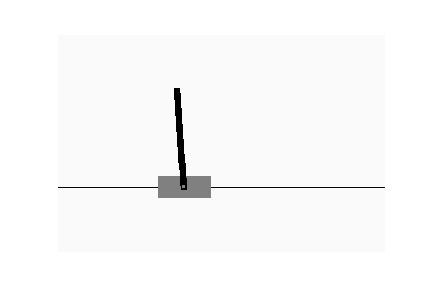
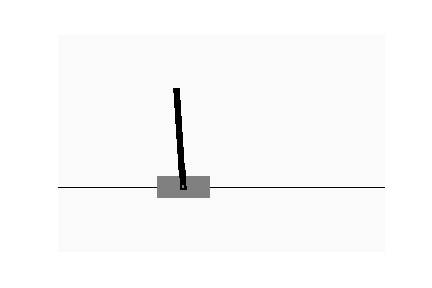
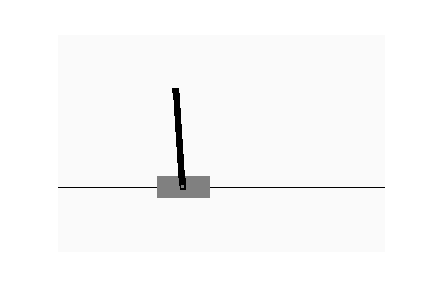
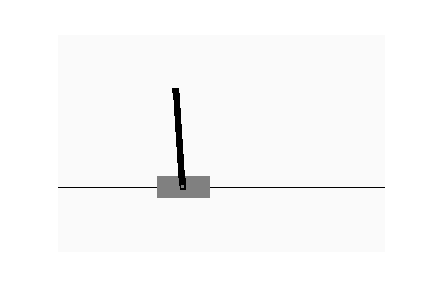
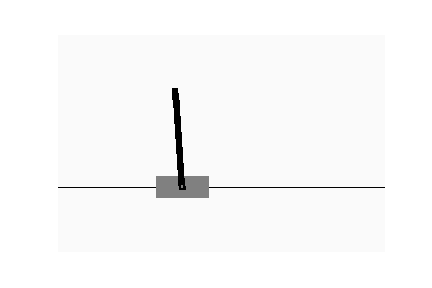
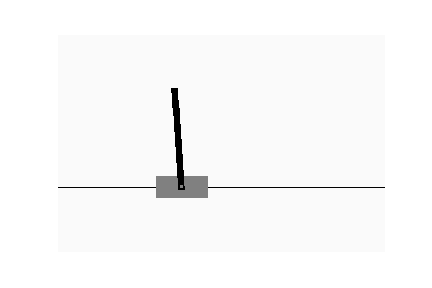
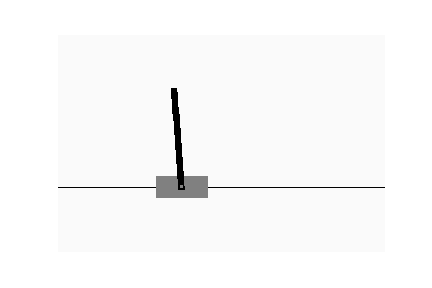
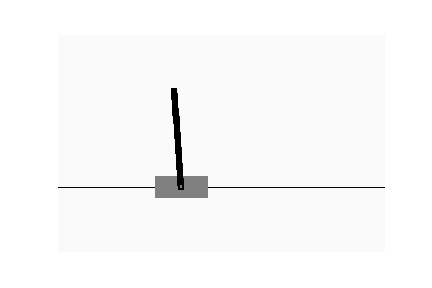
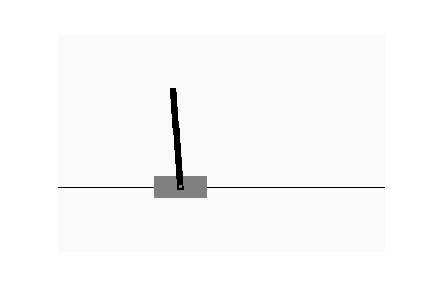
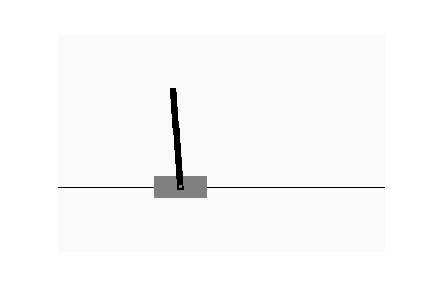
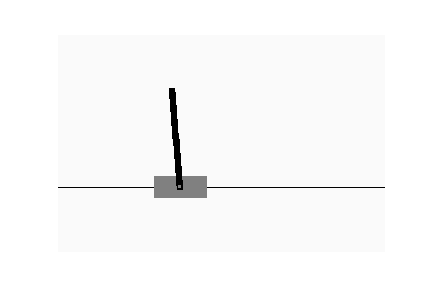
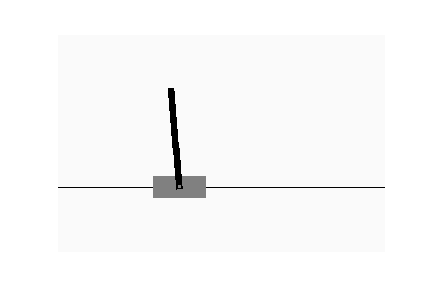
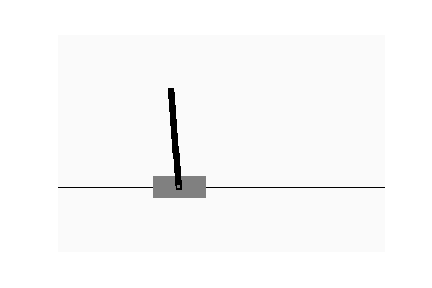
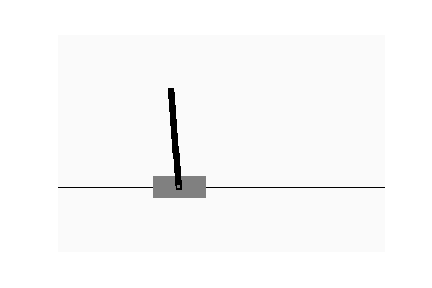
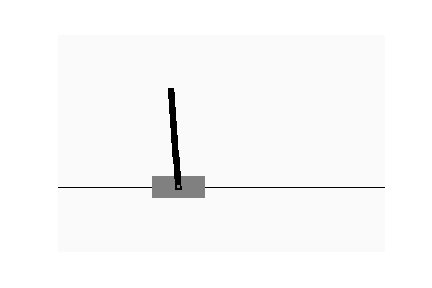
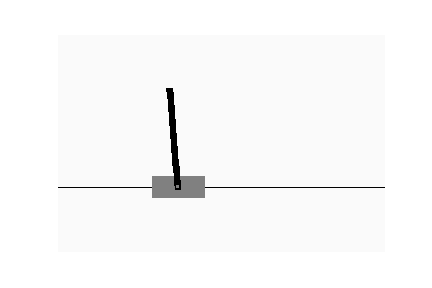
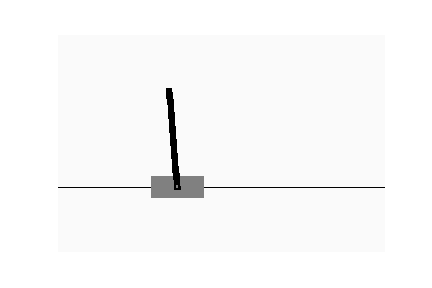
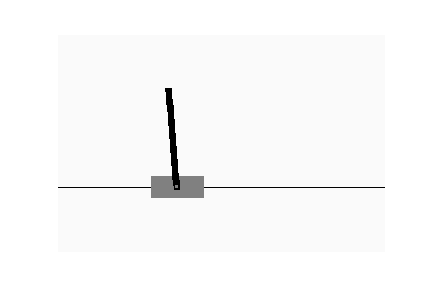
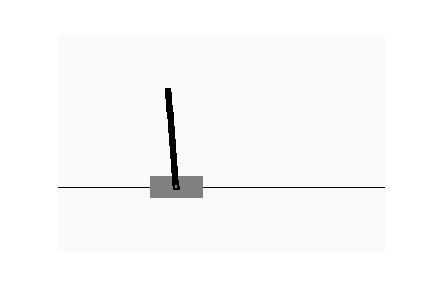
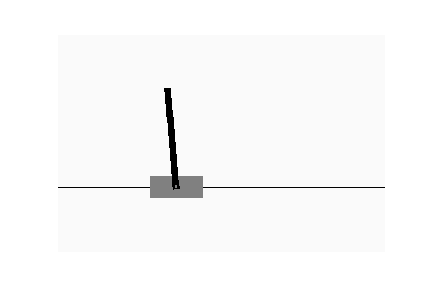
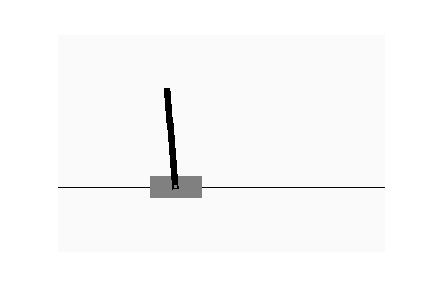
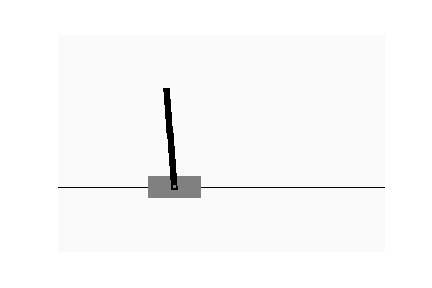
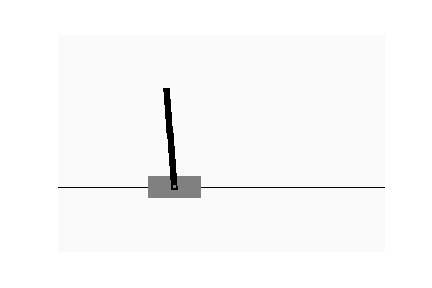
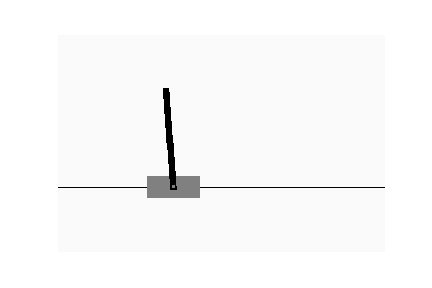
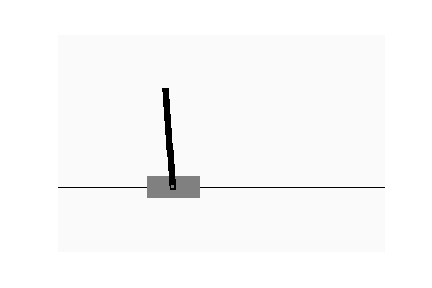
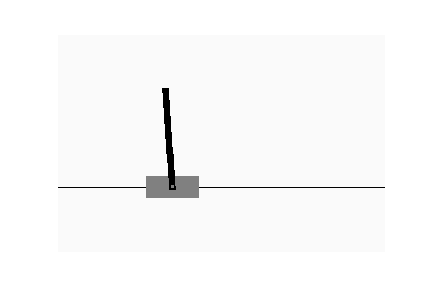
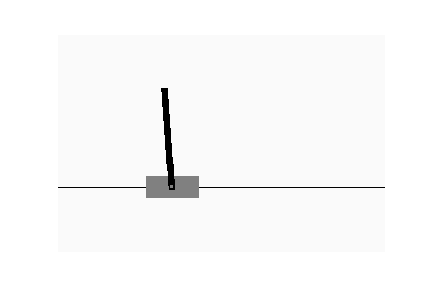
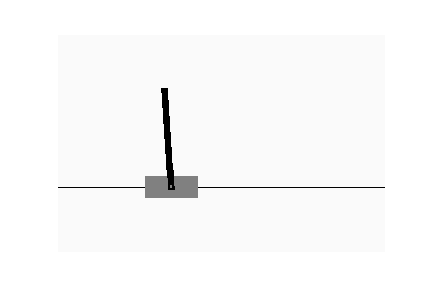
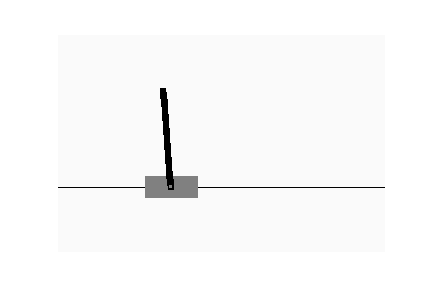
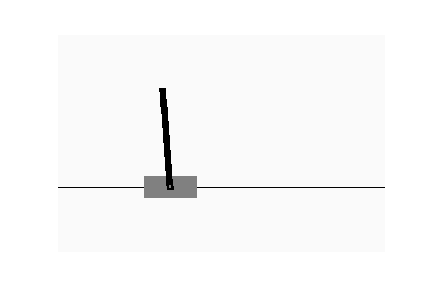
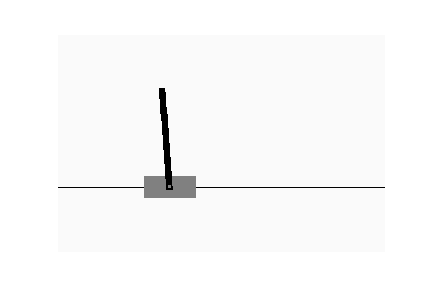
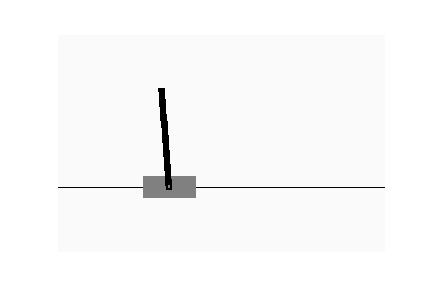
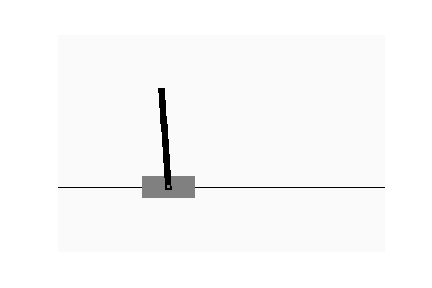
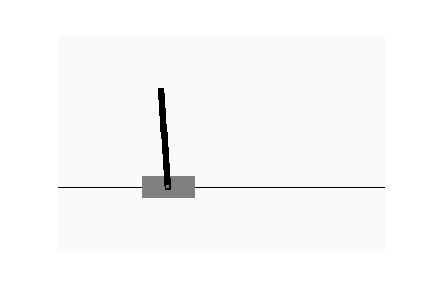
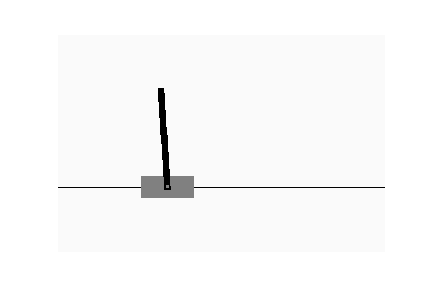
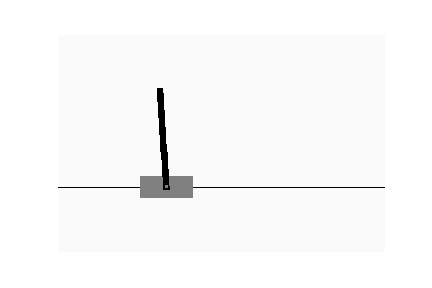
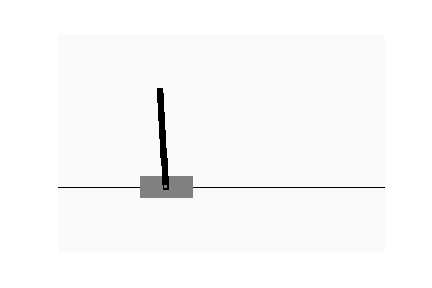
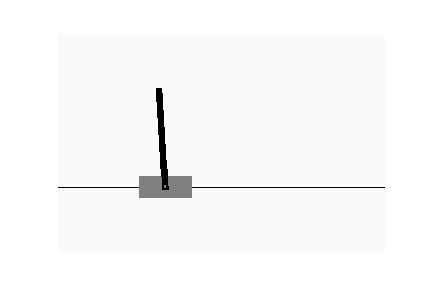
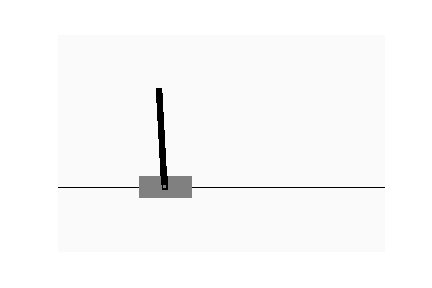
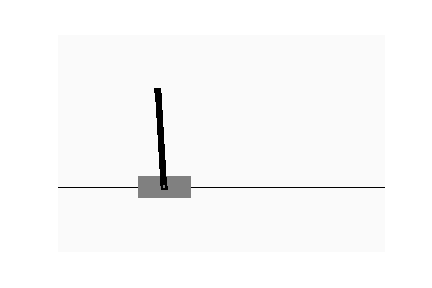
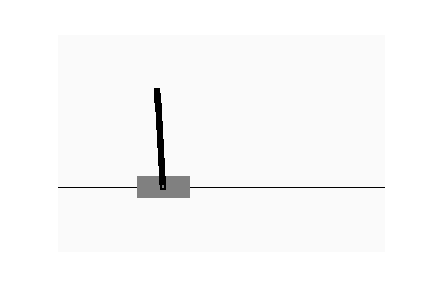
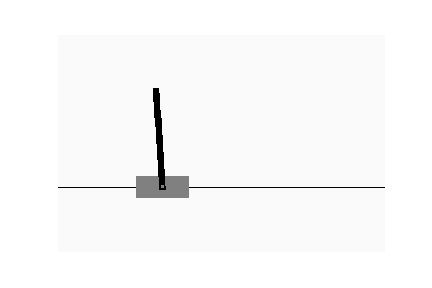
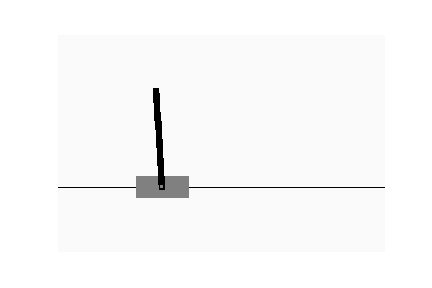
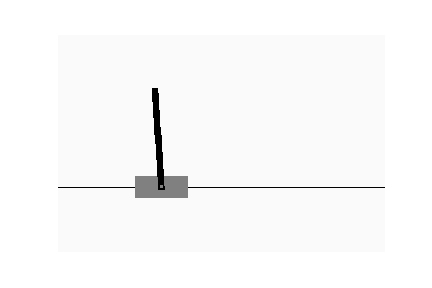
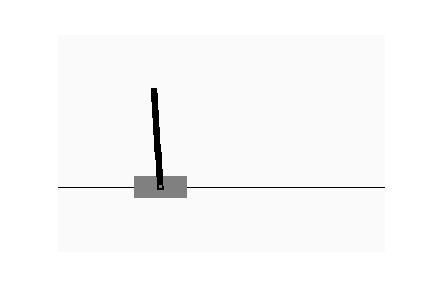
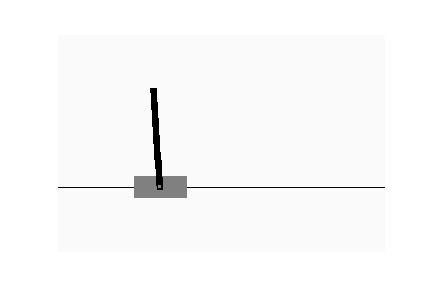
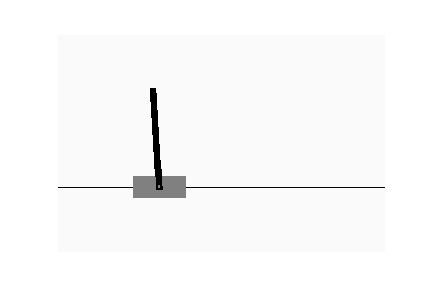
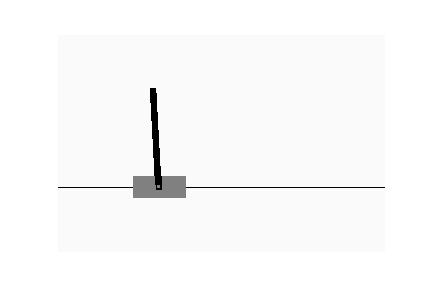
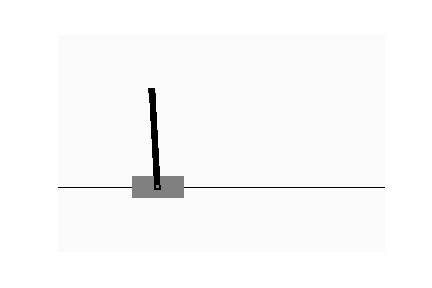
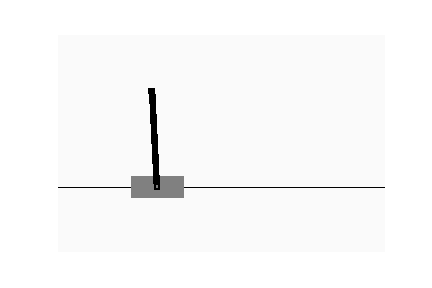
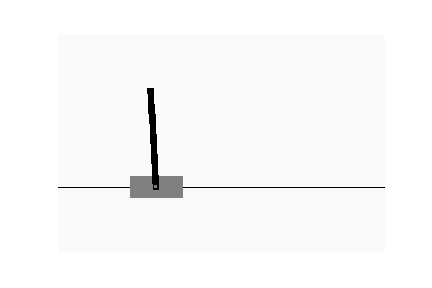
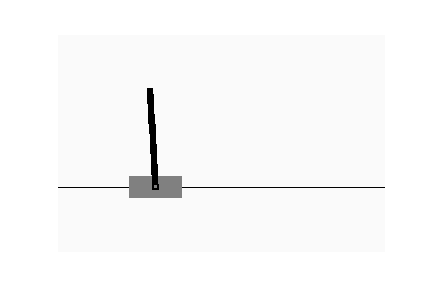
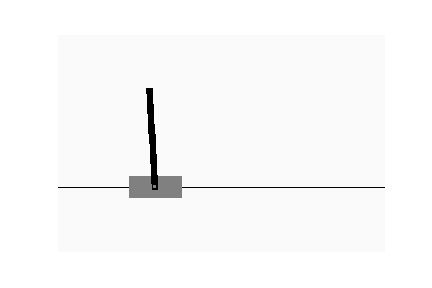
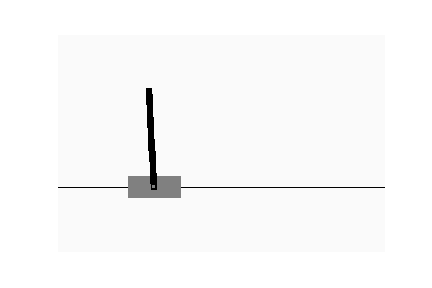
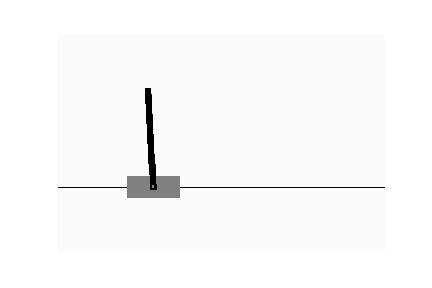
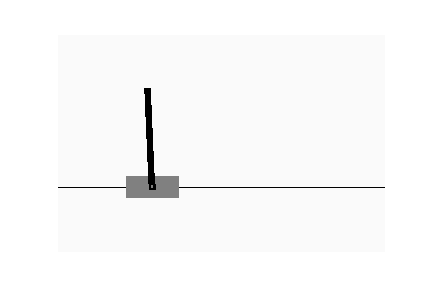
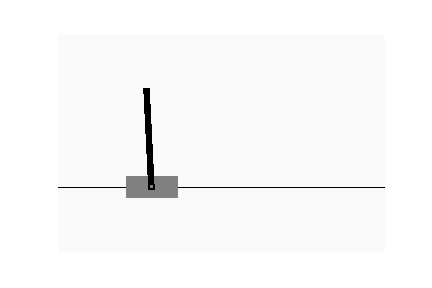
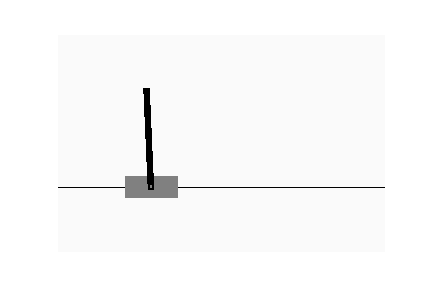
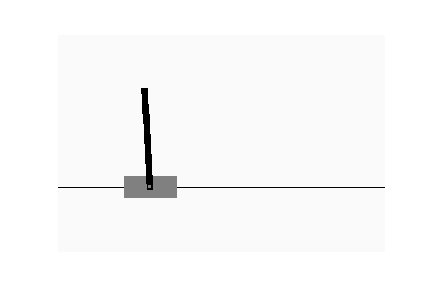
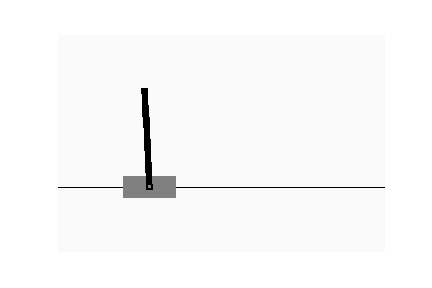
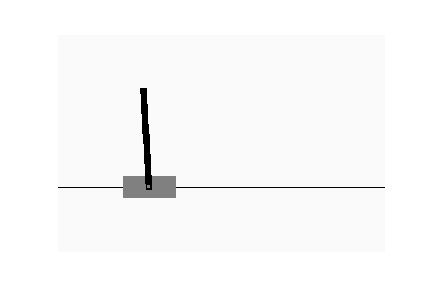
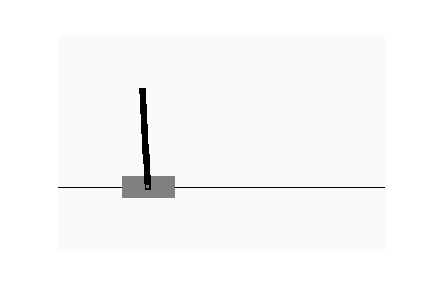
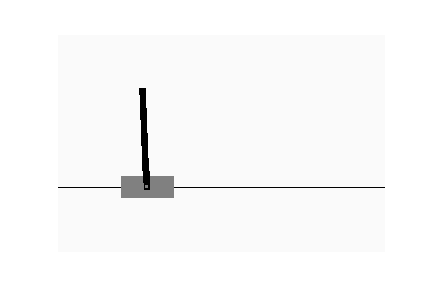
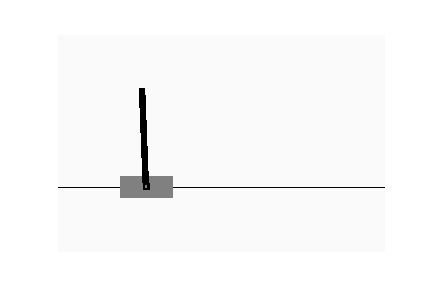
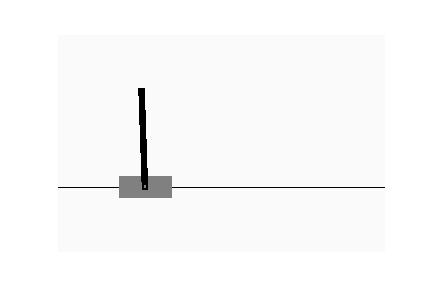
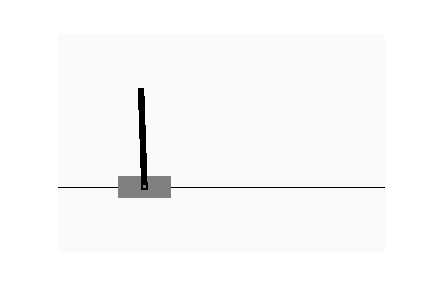
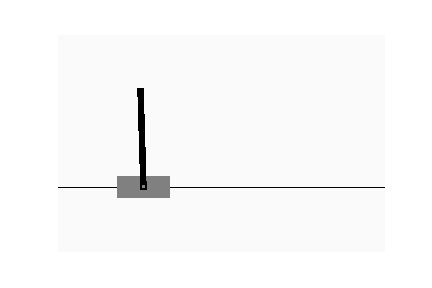
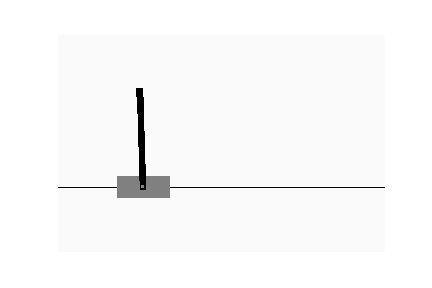
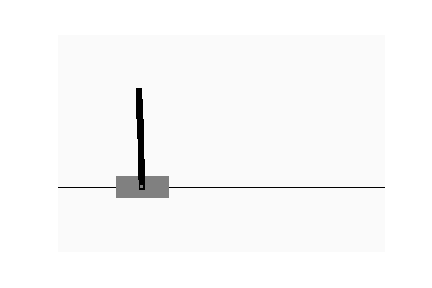
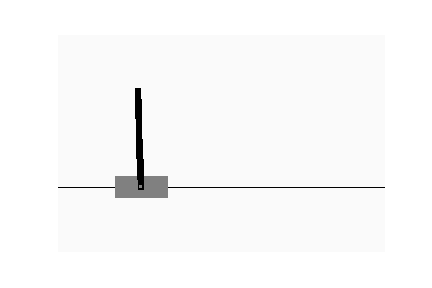
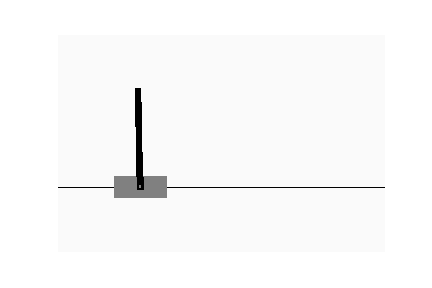
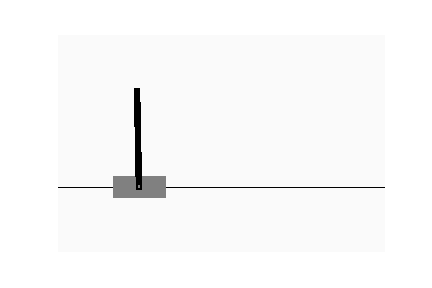
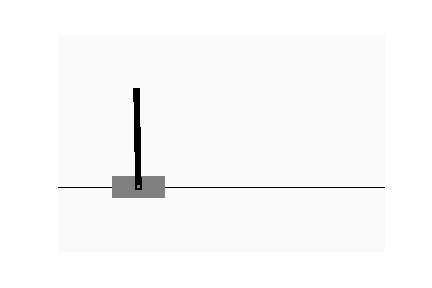
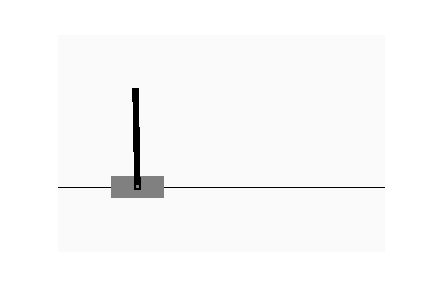
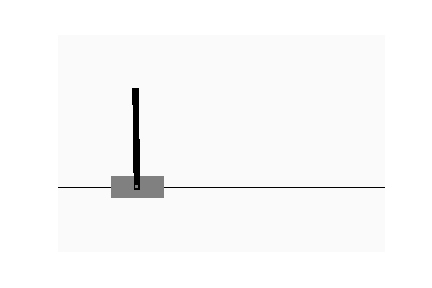
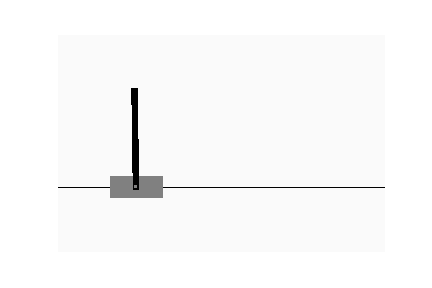
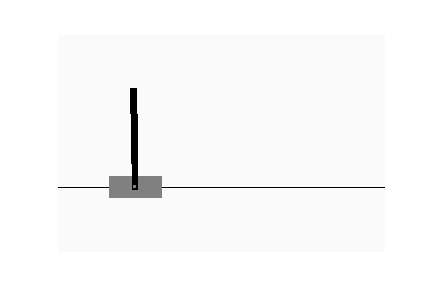
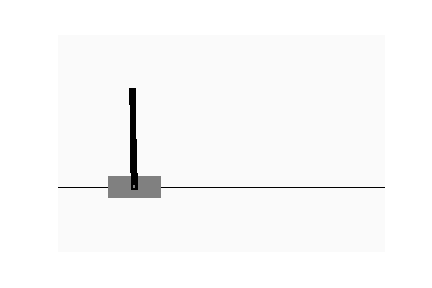
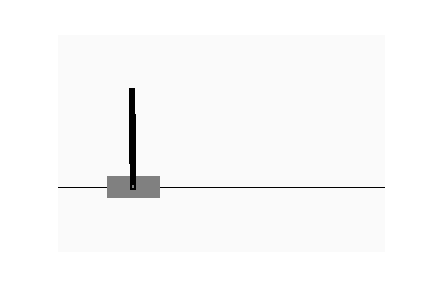
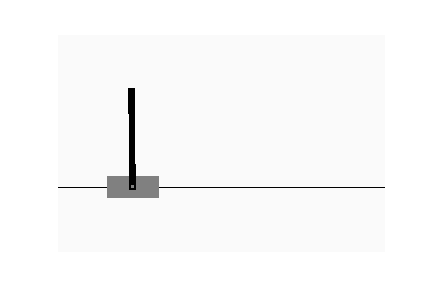
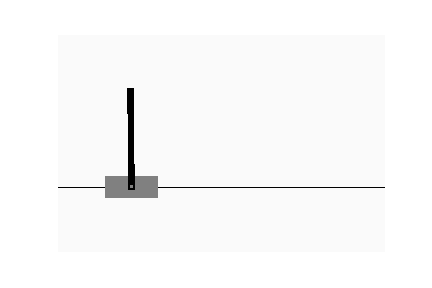
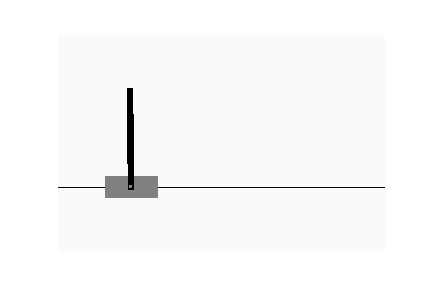
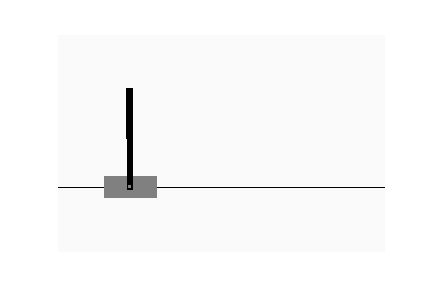
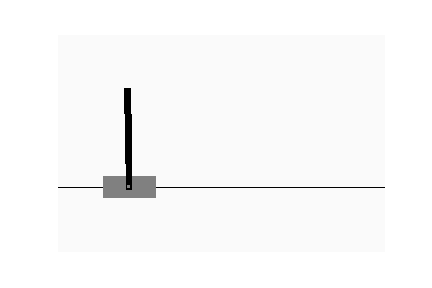
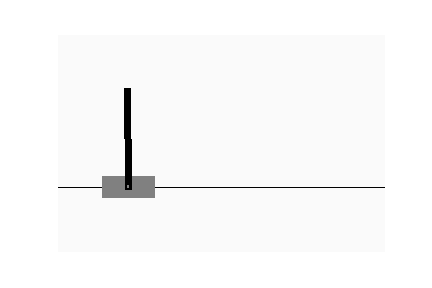
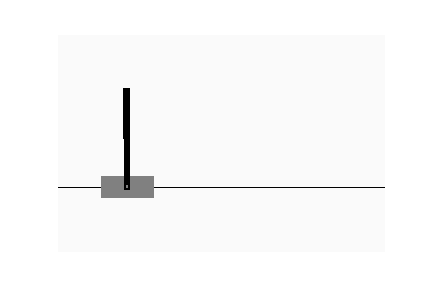
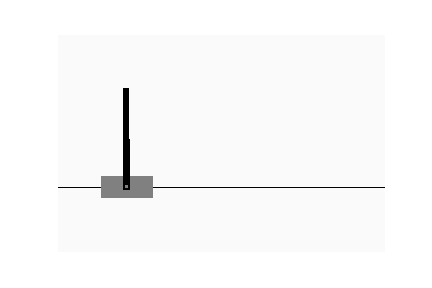
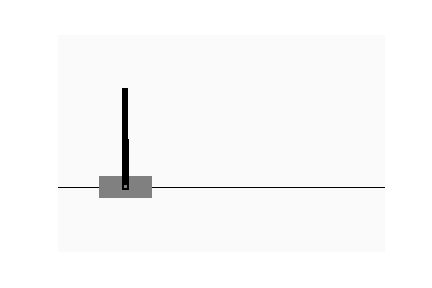
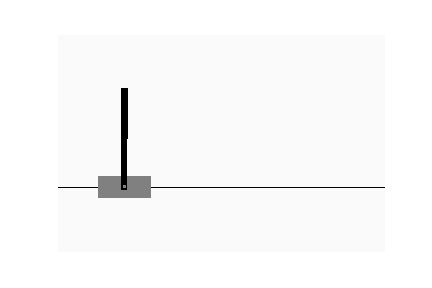
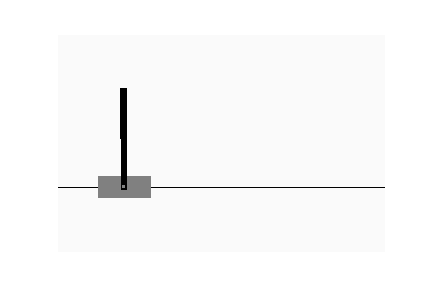
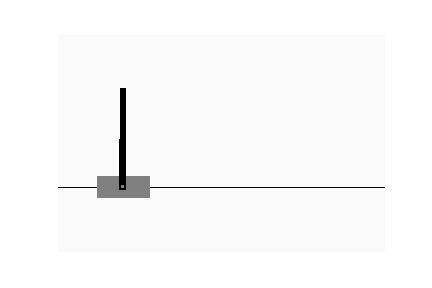
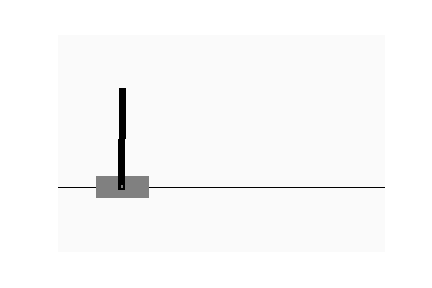
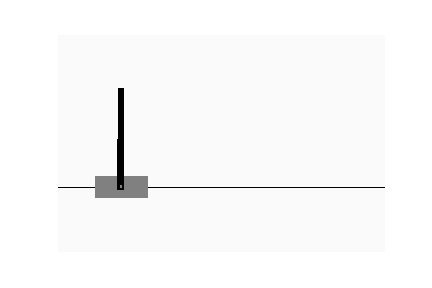
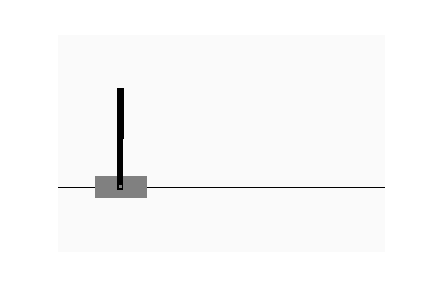
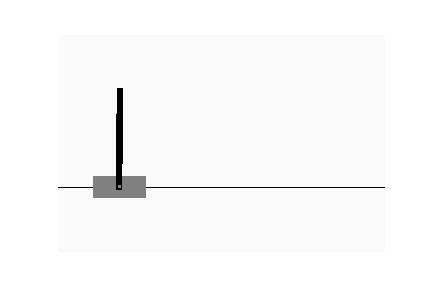
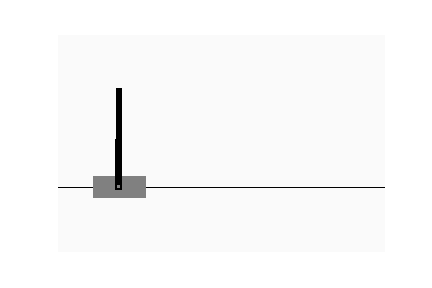
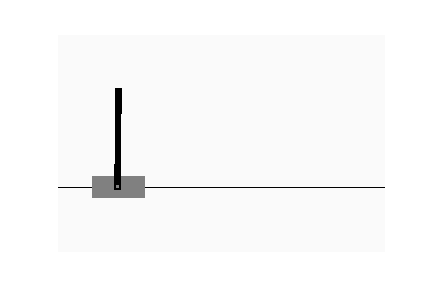
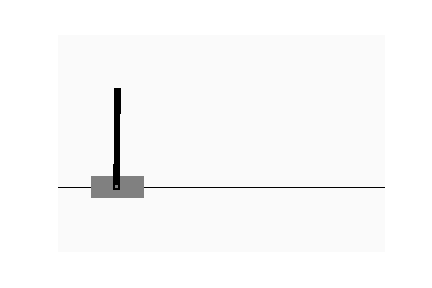
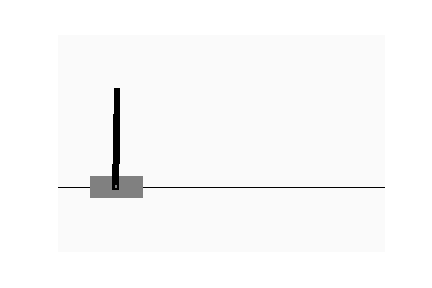
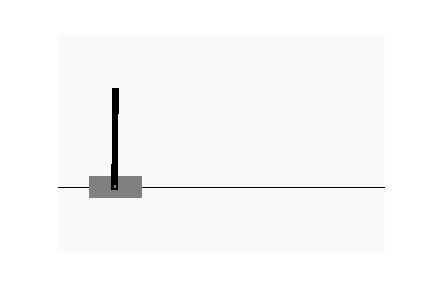
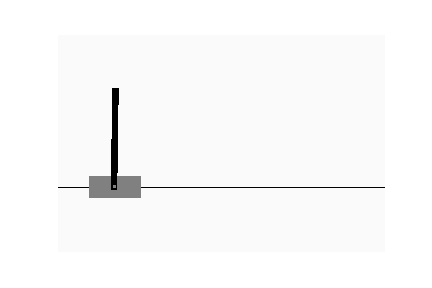
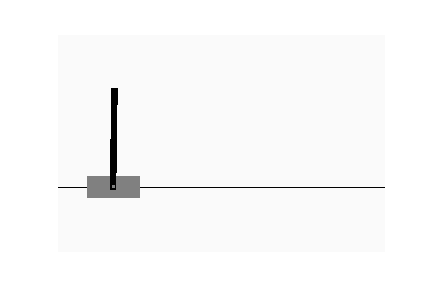
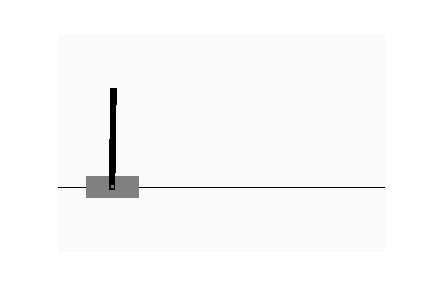
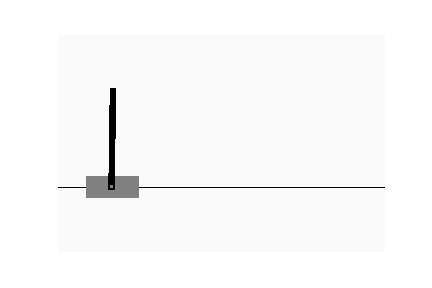
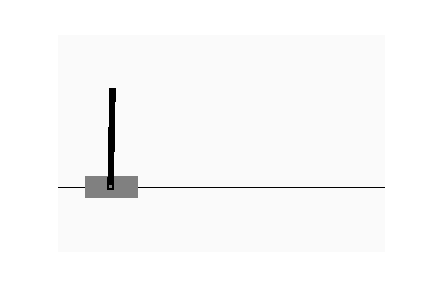
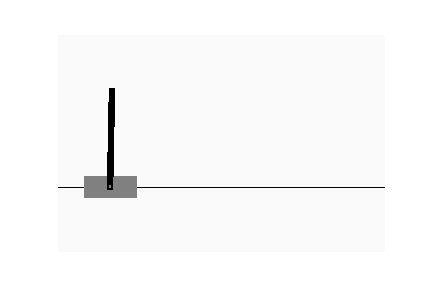
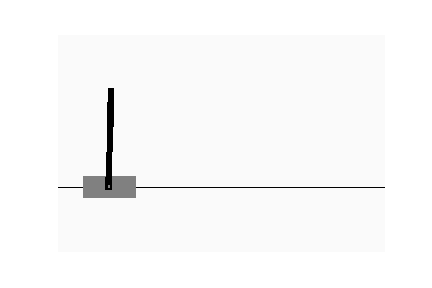
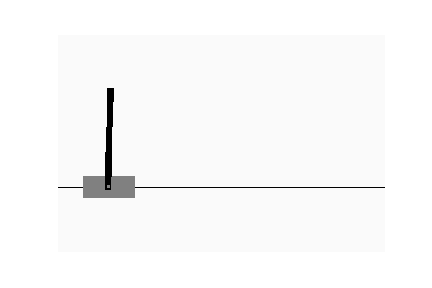
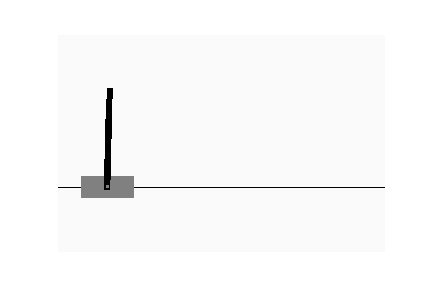
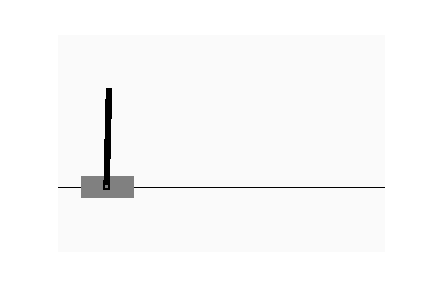
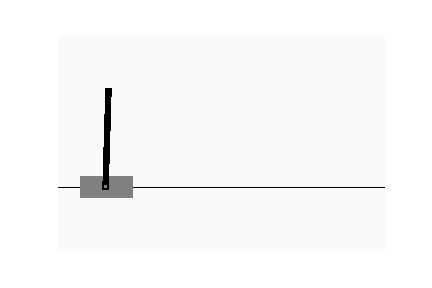
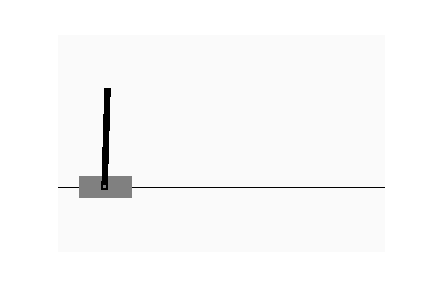
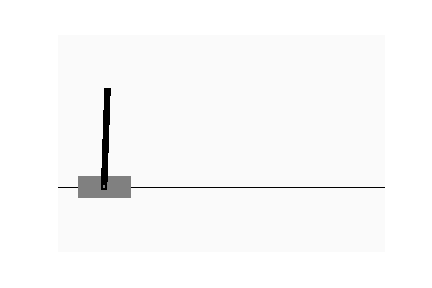
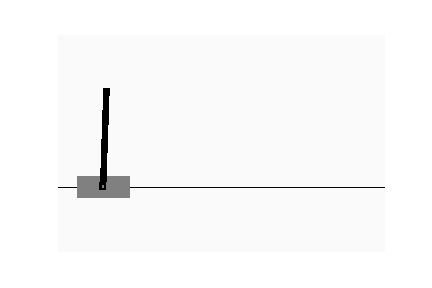
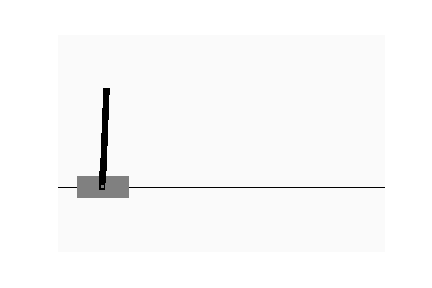
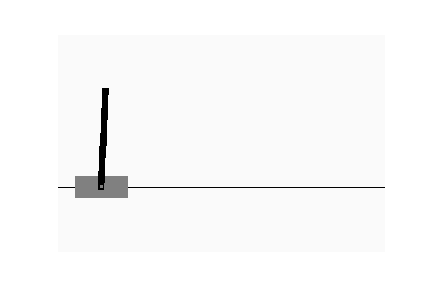
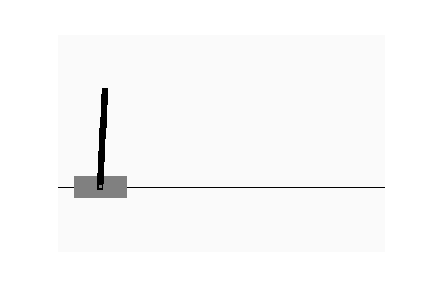
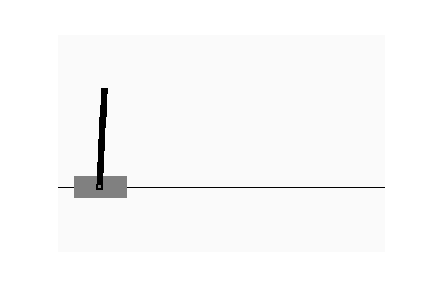
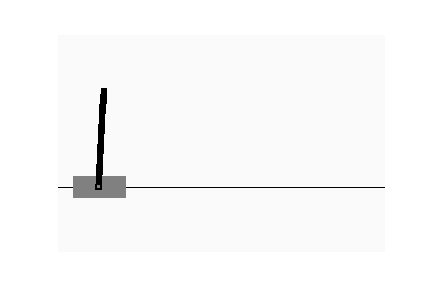
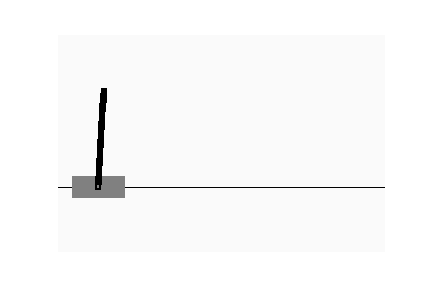
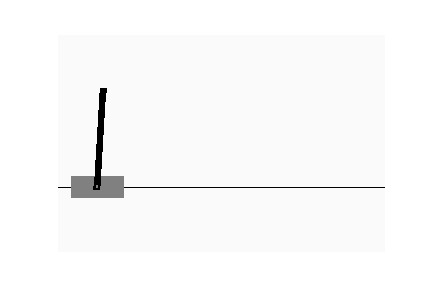
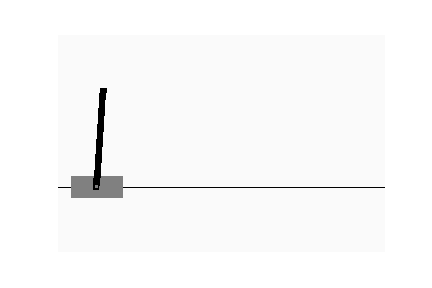
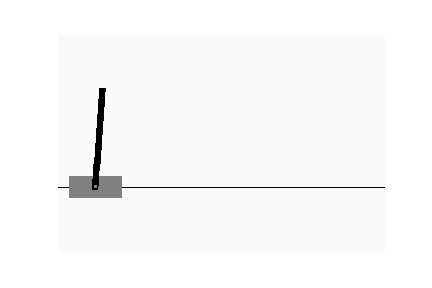
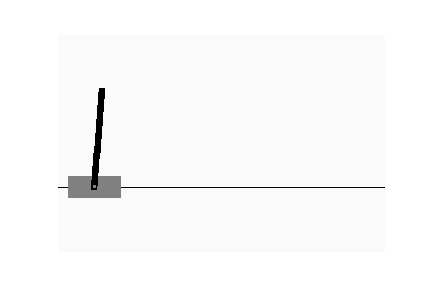
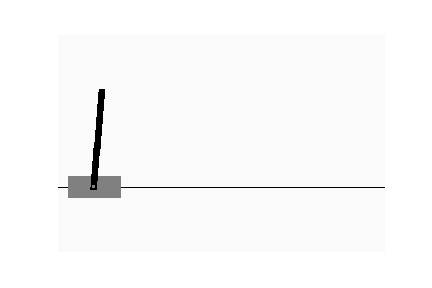
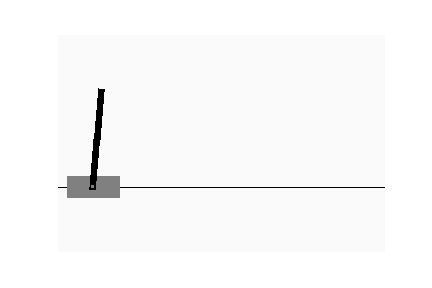
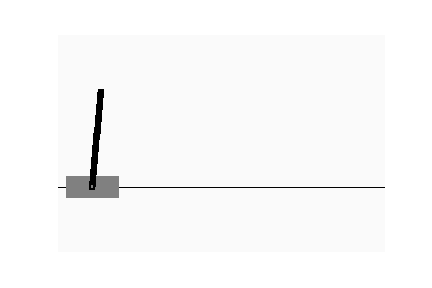
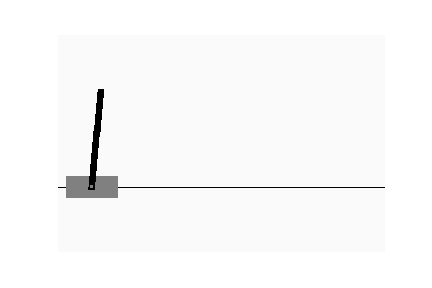
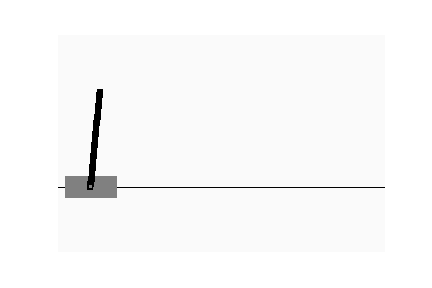
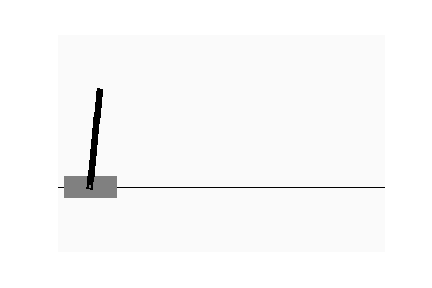
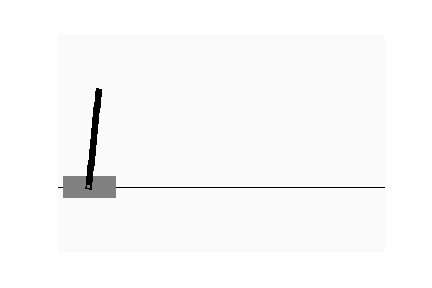
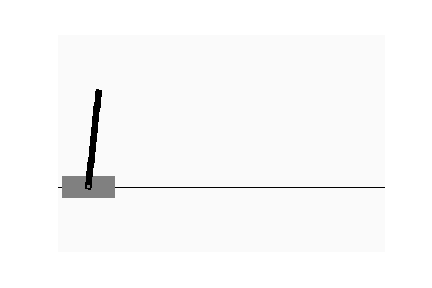
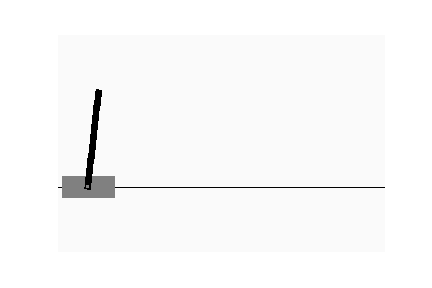
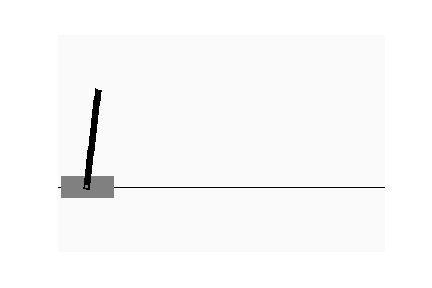
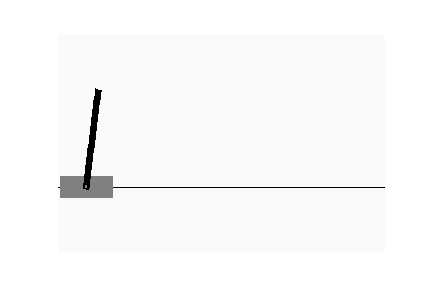
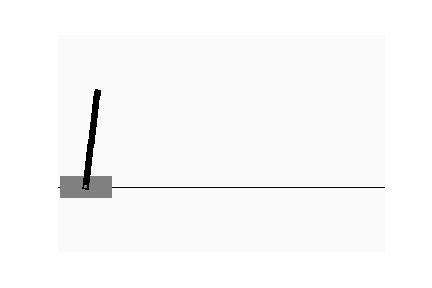
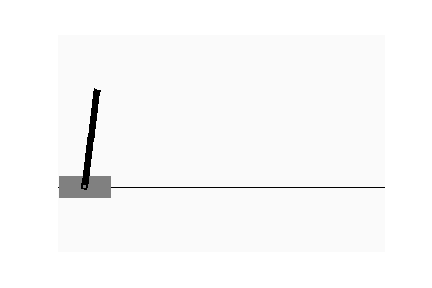
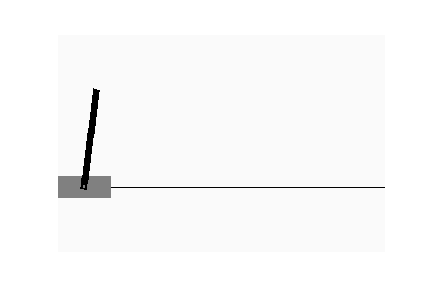
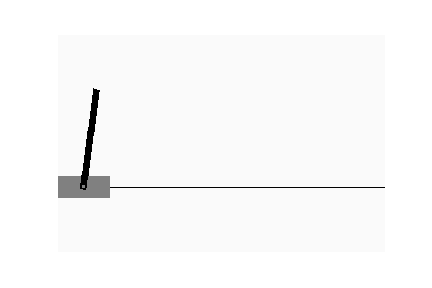
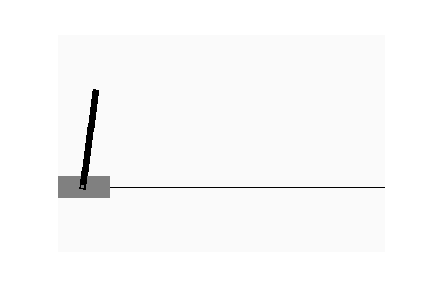
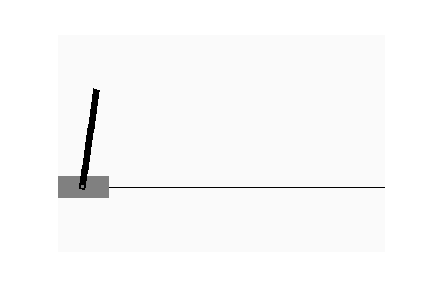
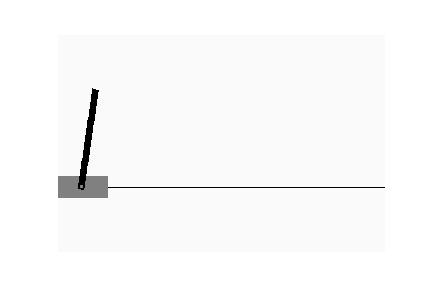
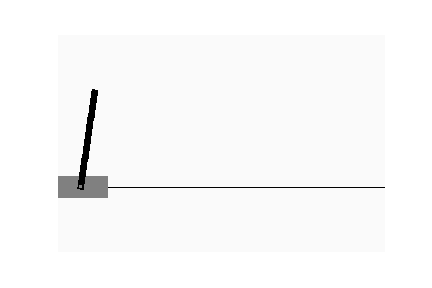
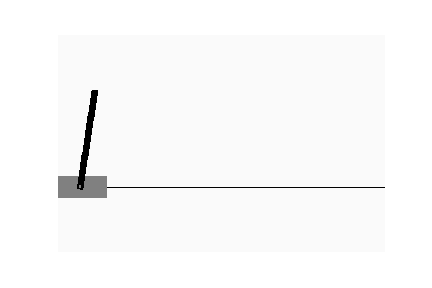
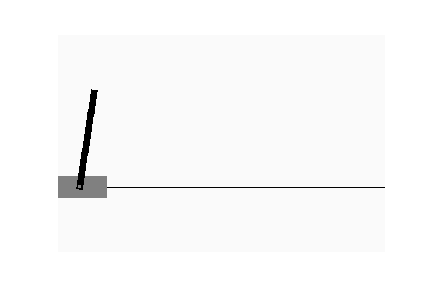
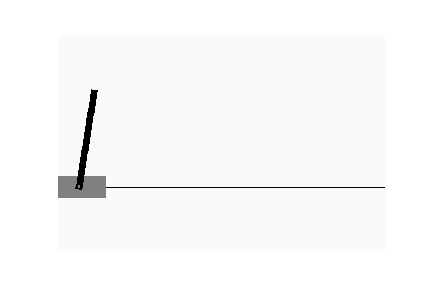
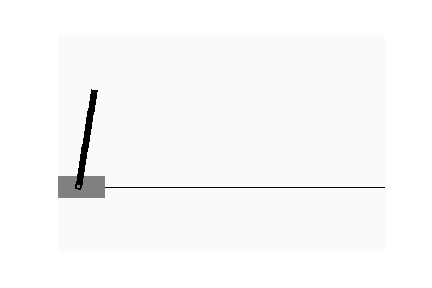
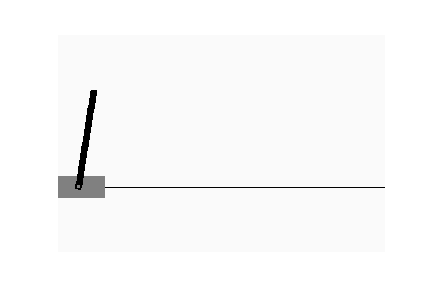
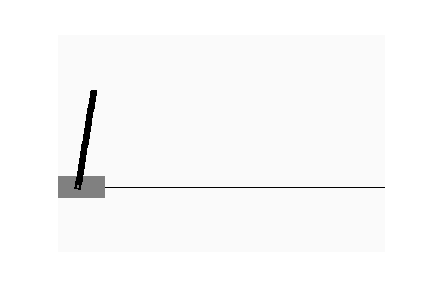
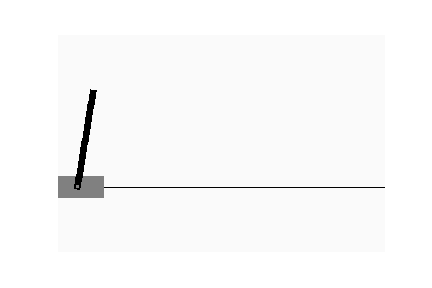
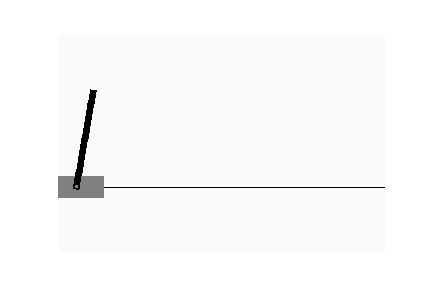
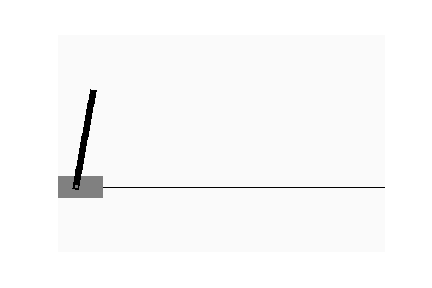
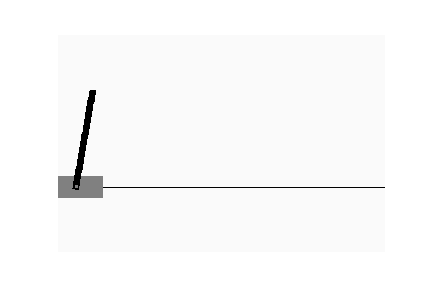
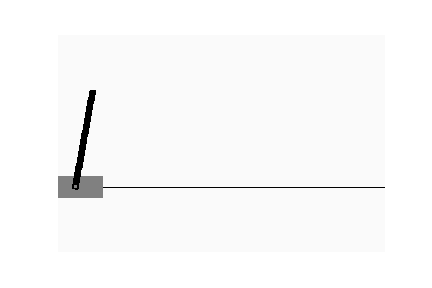
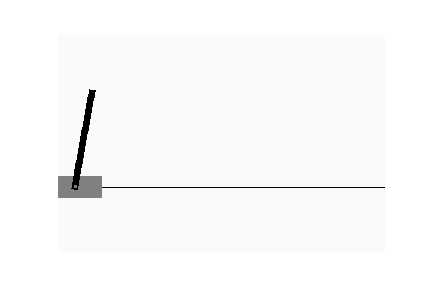
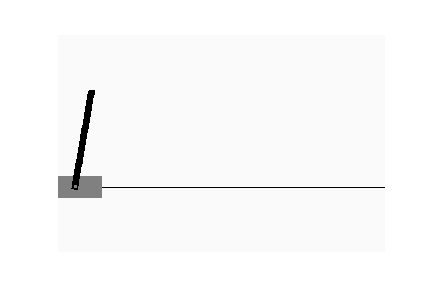
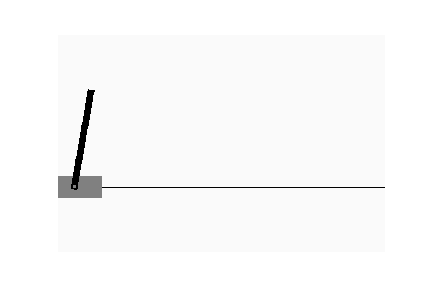
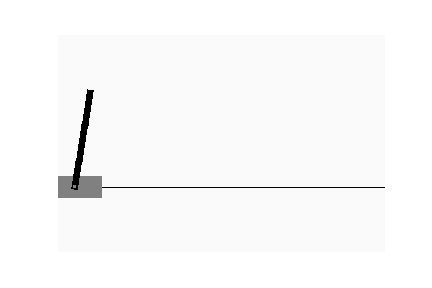
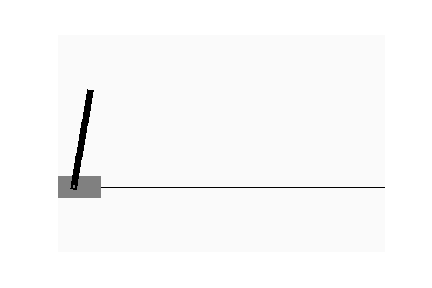
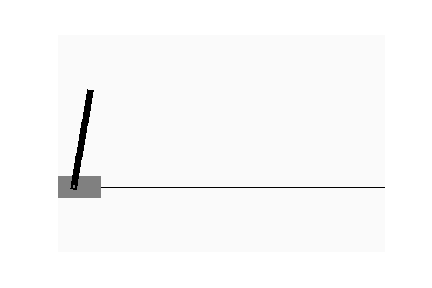
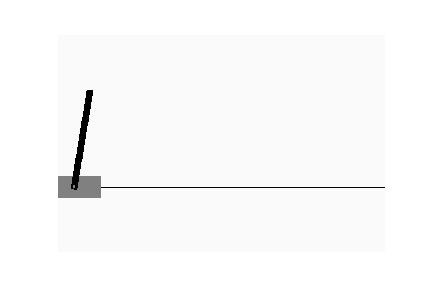
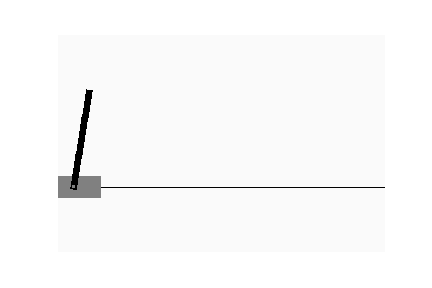
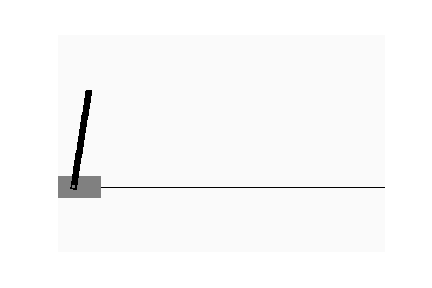
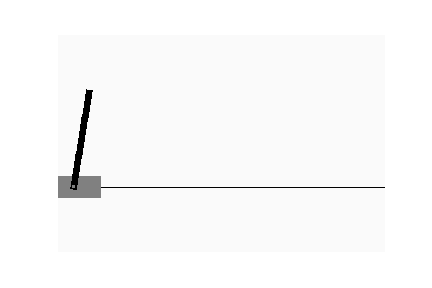
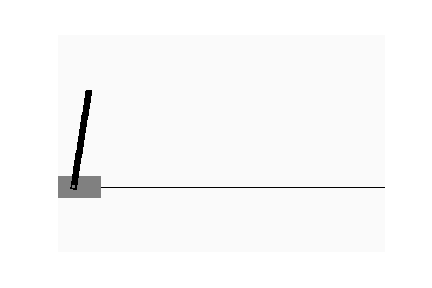
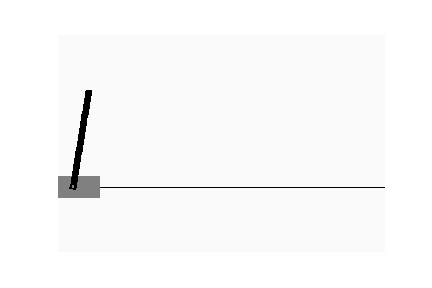
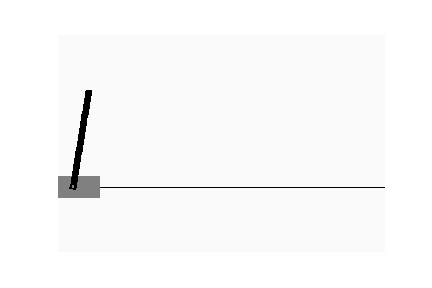
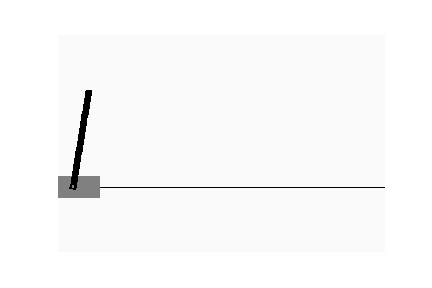
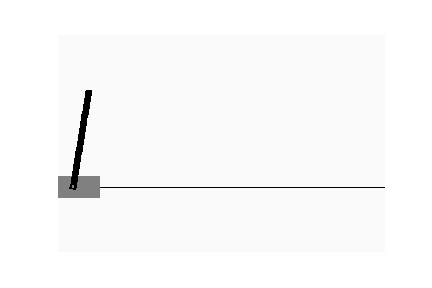
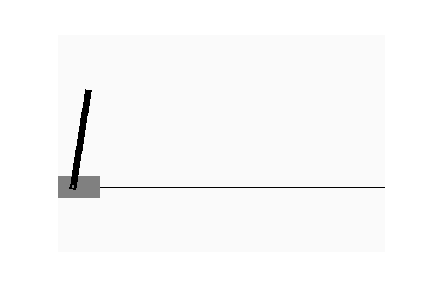
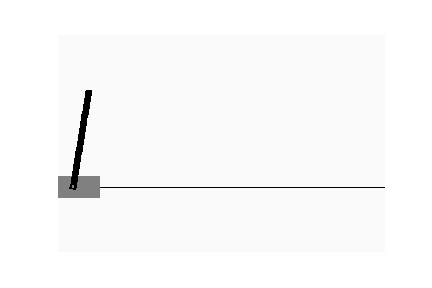
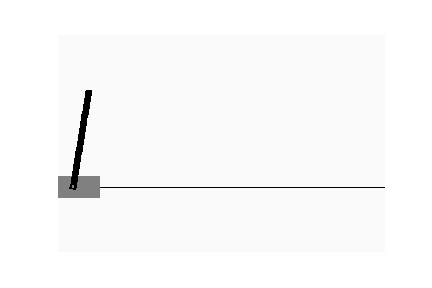
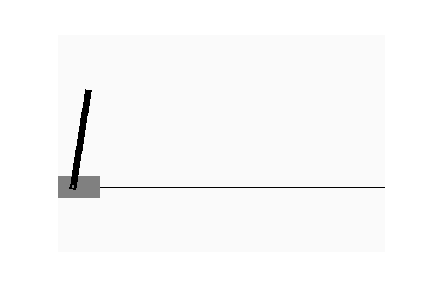
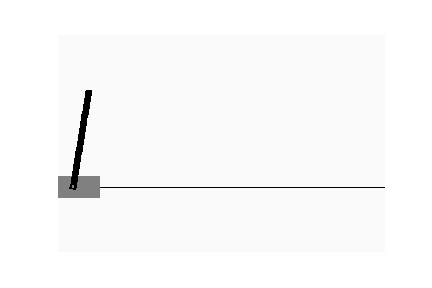
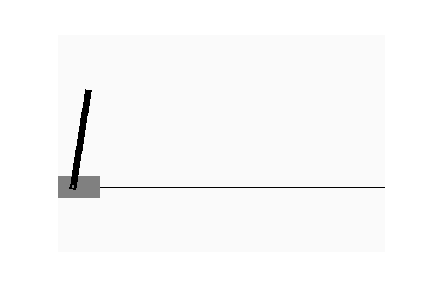
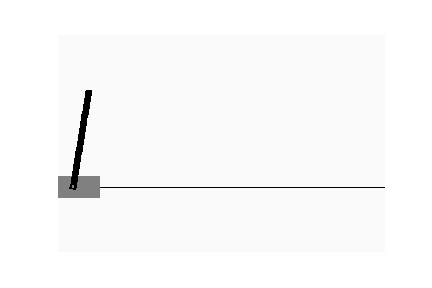
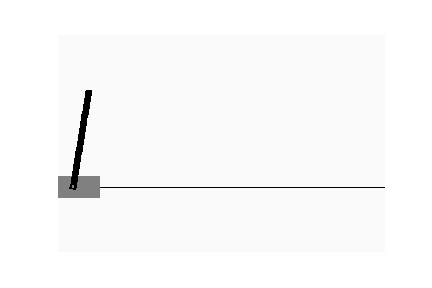
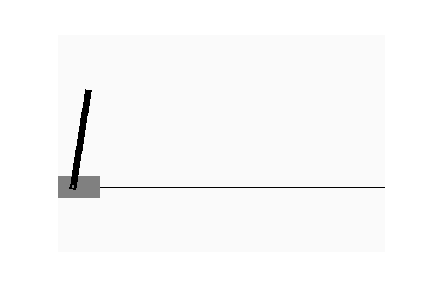
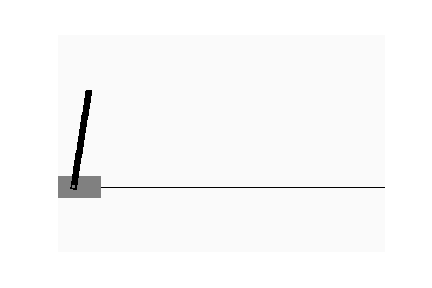
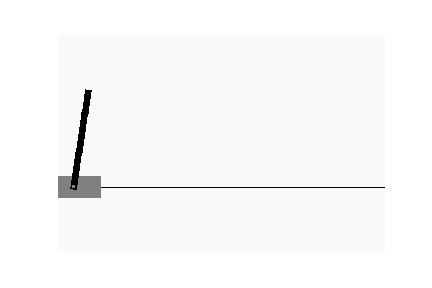
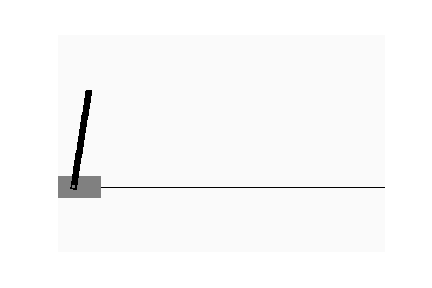
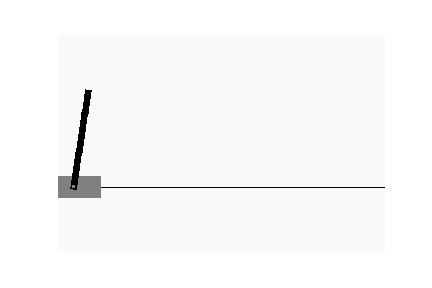
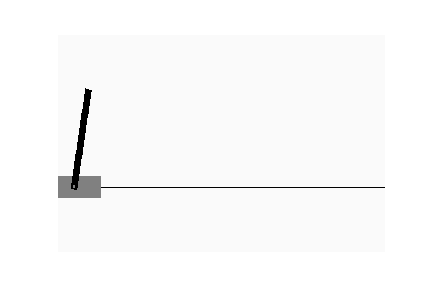
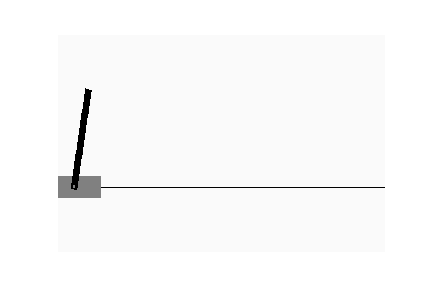
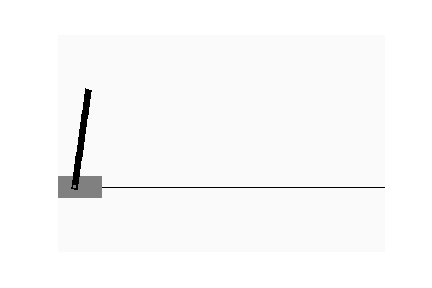
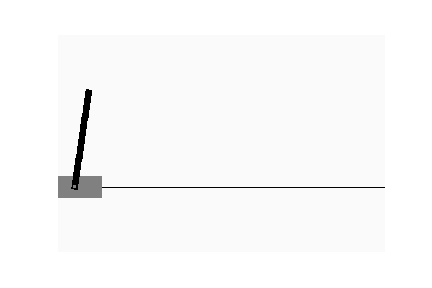
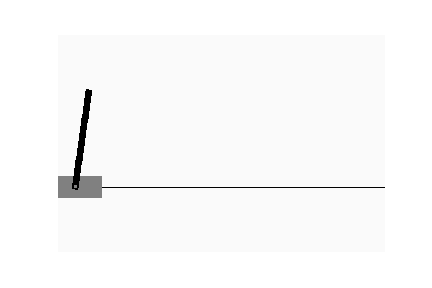
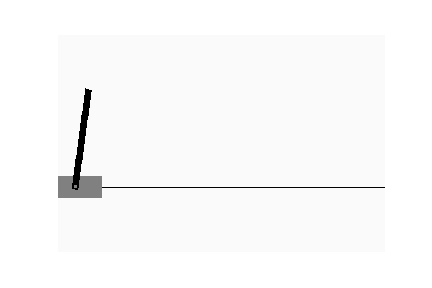
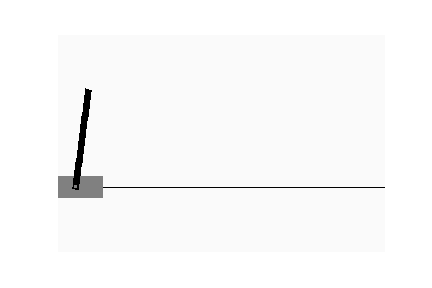
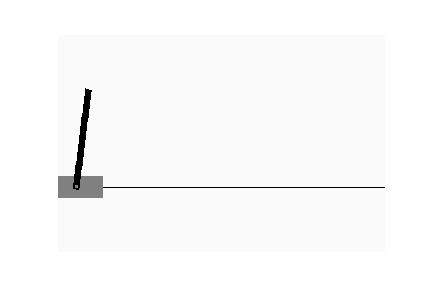
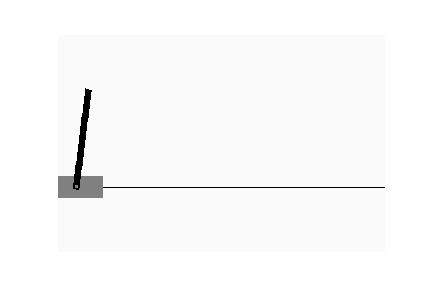
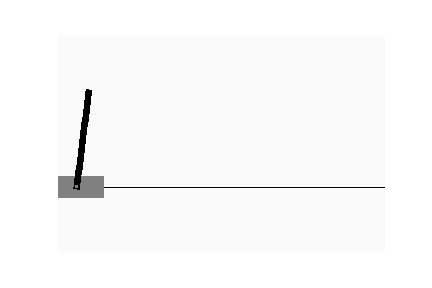
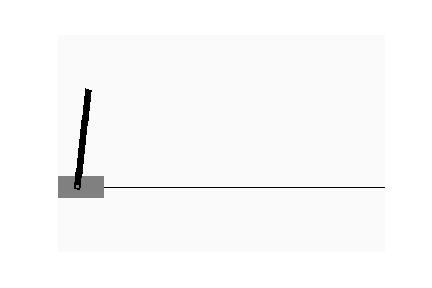
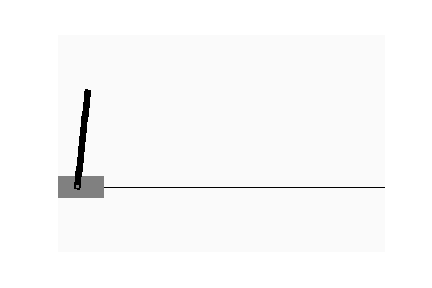
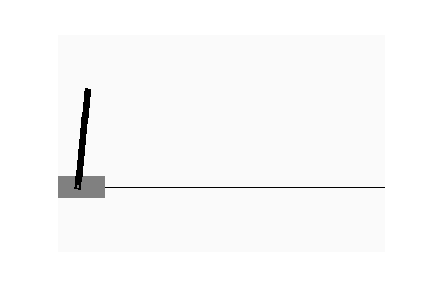
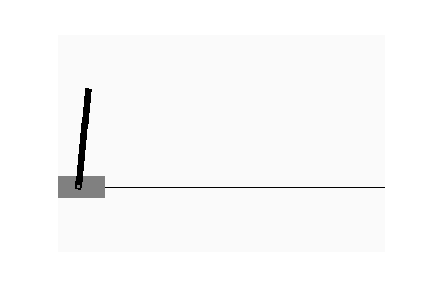
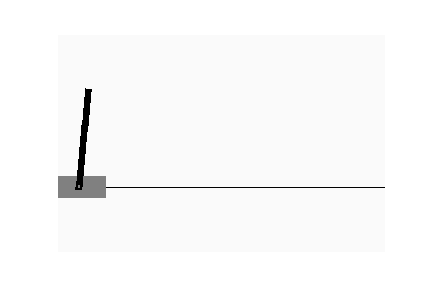
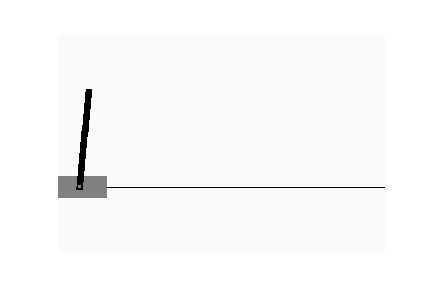
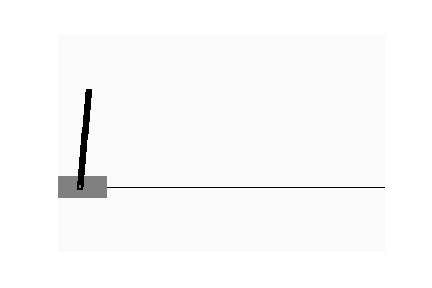
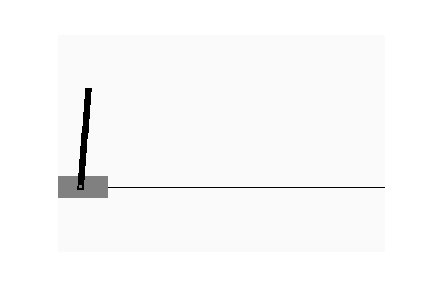
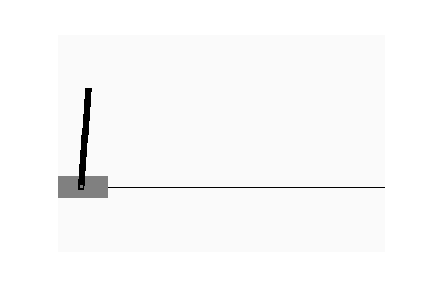
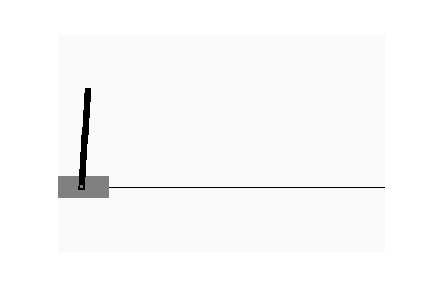
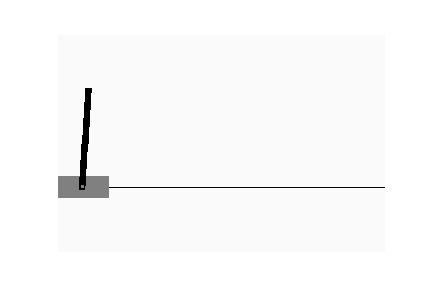
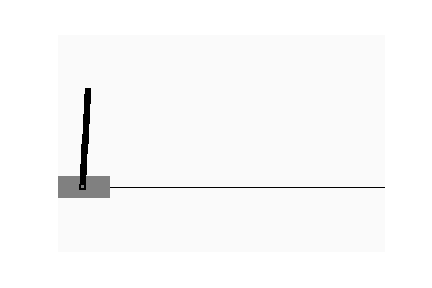
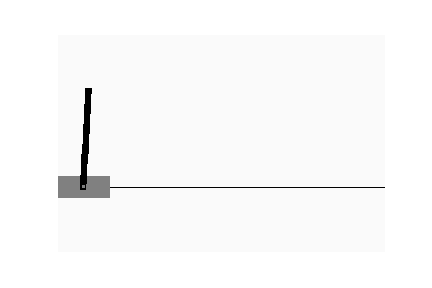
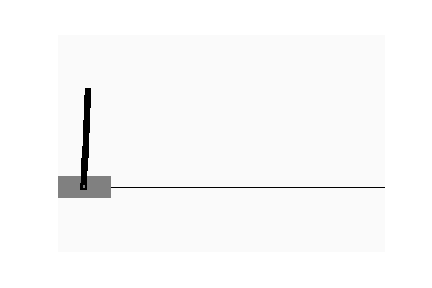
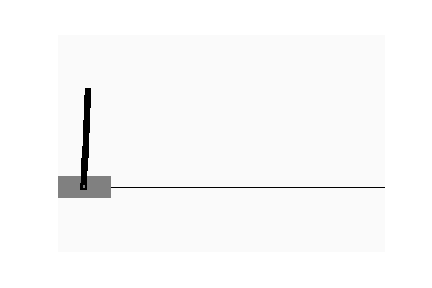
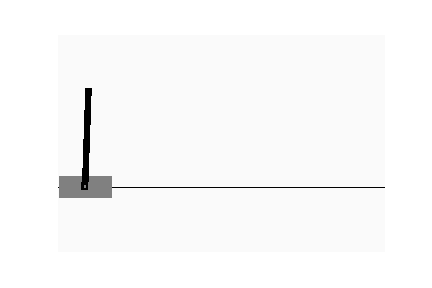
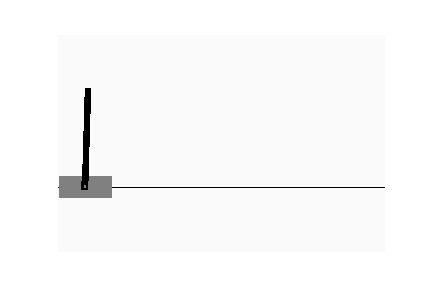
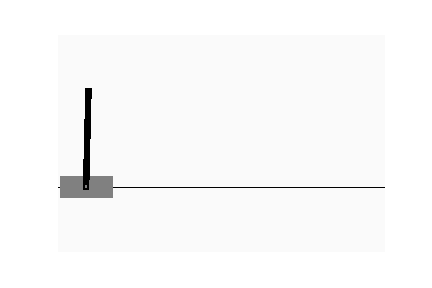
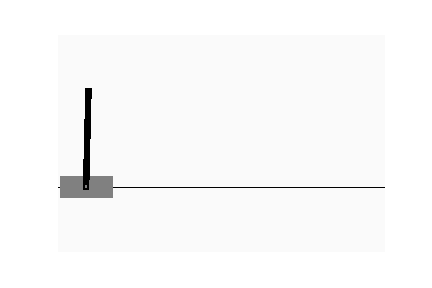
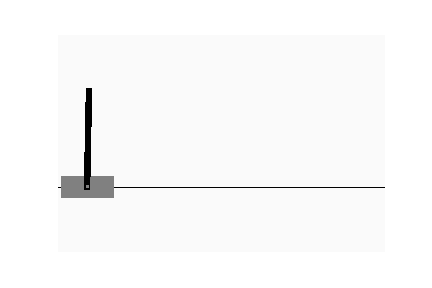
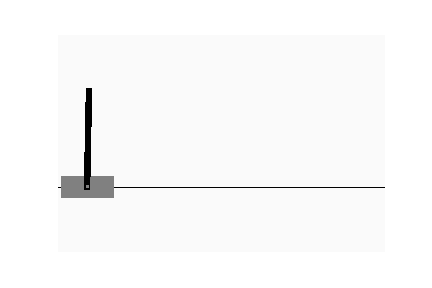
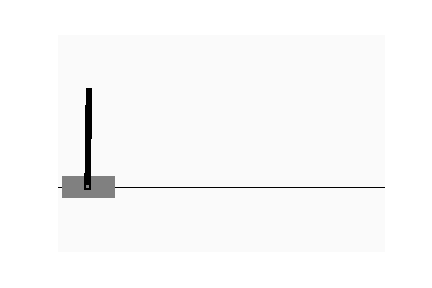
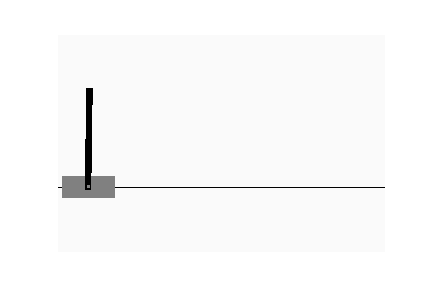
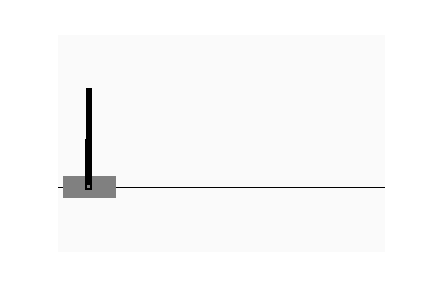
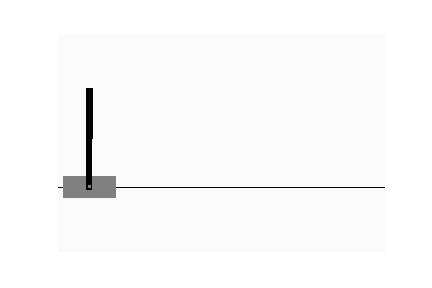
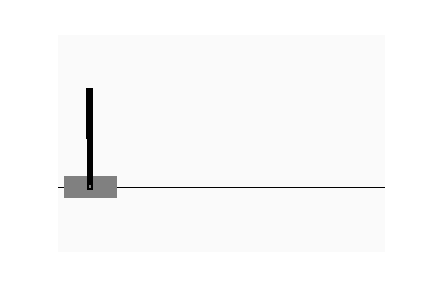
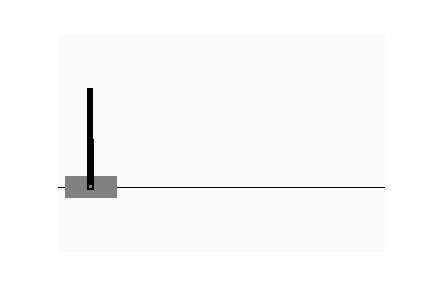
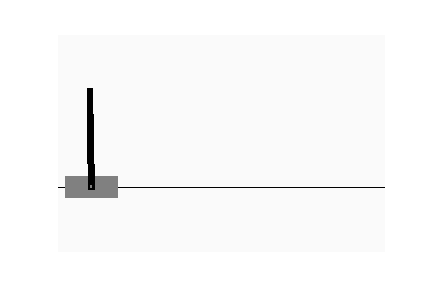

In [19]:
s = env.reset()
view = Viewer(env, custom_render=True)
for _ in range(500):
    view.render()
    a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
    s, r, done, _ = env.step(a)
view.render(close=True, display_gif=True)

## Reducing variance

By default, this gradient estimator has high variance and therefore variance reduction becomes important to learn more complex tasks.
We can reduce variance by subtracting a baseline from the returns, which is unbiased in expectation:

$$
\nabla_\theta \mathbb{E}[R|\theta] \approx \frac{1}{T} \sum_{t=0}^T \nabla_\theta \log p_\theta(a_t|s_t) (R_t-b_t) \ ,
$$

where the baseline, $b_t$, is estimated by the return a timestep $t$ averaged over $V$ rollouts.

$$
b_t = \frac{1}{V} \sum_{v=1}^V R_t^{(v)} \ .
$$

## Exercises

Now it is your turn! Make sure you read and understand the code, then play around with it and try to make it learn better and faster.

Experiment with the:

* number of episodes
* discount factor
* learning rate
* network layers


### Exercise 1 

*Describe any changes you made to the code and why you think they improve the agent. Are you able to get solutions consistently?*

**Answer:**

The default network on the notebook already does a good job at not letting the pole fall. Nevertheless, the cart does not move and thus needs some improvement.

1) When changing the discount factor from 1 to 0.9 I find that the network stops doing a good job and lets the pole fall. Also, the rewards (both training and validation) are considerably lower than the original case. I come back to 1 as a discount factor.

2) Dividing the learning rate by 10 also makes the network perform worse than the baseline network. Even though the performance is not as bad as in 1) I start to wonder whether changes to the network hyperparameters have to be done simoultaneously or not. In any case I return to the original learning rate.

3) Using more episodes, on the baseline network, make the cart move (although the pole falls) but seems to generate a greater reward both in training and validation. I will leave the number of episodes on 1000 and start modifying the network architecture.

4) As sometimes it does, increasing the size of the network, increases the reward for both the training and the validation. I added one layer with 40 hidden units. I will leave it this way and come back and explore with the learning rate and the discount factor again.

5) Decreasing the discount factor to 0.95 does not help the network by itself. However, using this same hyper-parameter and increasing the number of episodes to 2000, makes the first completely working solution. The variance of the loss and the rewards is extremelyhigh, though.

### Exercise 2 

*Consider the following sequence of rewards produced by an agent interacting with an environment for 10 timesteps:*

[0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

* *What is the total reward?*
* *What is the total future reward in each timestep?*
* *What is the discounted future reward in each timestep if $\gamma = 0.9$?*

*Hint: See introdution notebook.*

**Answer:**

1) The total reward is 5. The sum of the rewards.

2) The total future reward in each time step is the total reward minus the cumulative sum of the list: [5, 5, 4, 3, 3, 2, 1, 0, 0, 0]

3) The total discounted future reward is the list from 2) mutiplied by $\gamma^t$: [5, 4.5, 3.24, 2.187, 1.9683, 1.18098, 0.531441, 0,
 0, 0]



### Exercise 3

*In the training output, you will sometimes observe the validation reward starts out lower than the training reward but as training progresses they cross over and the validation reward becomes higher than the training reward. How can you explain this behavior?*

*Hint: Do we use the policy network in the same way during training and validation?*

**Answer:**

It could be explained by many things. First of all. During the validation, the weights are already updated from the previous step and since the policy is guaranteed to be at least as good as the previous one, the reward must be higher. Second, during training the action is sampled while on the validation step, the action is taken directly from the network. This, of course makes the deterministic action more effective when validating.

### Exercise 4

*How does the policy gradient method we have used address the exploration-exploitation dilemma?*

*Hint: See the introduction notebook about exploration-exploitation.*

**Answer:**

The method exploits the exploration-exploitation dilemma because when it decides which action to take, it chooses the argmax of the action and a draw from a uniform random distribution. If the draw is higher than the probability generated by the network, it will take another action, this is the exploring part. As the network is trained, it gets more confident of the actions it should take and therefore the probability of a certain action is high, the likelihood of this probability being smaller than a random draw becomes really small. This is the exploitation part.

### Exercise 5 [optional]

Extend the code above to reduce variance of the gradient estimator by computing and subtracting the baseline estimate. 

*Hint: You need to sample a batch of rollouts (now we sample just one) for each update in order to compute the baseline, $b_t$.*

## Michael Nielsen problem

**One gotcha with the cross-entropy is that it can be difficult at first to remember the respective roles of the ys and the as. It's easy to get confused about whether the right form is −[yln(a)+(1−y)ln(1−a)] or −[aln(y)+(1−a)ln(1−y)]. What happens to the second of these expressions when y=0 or 1? Does this problem afflict the first expression? Why or why not?**

**Answer**: When $y\in\{0,1\}$, the function is not defined because the natural logarithm is not defined for 0. Therefore the loss can't be computed. This doesn't affect the first equation because $a$ is never $0 or $1$. It might get extremely close but it will never be any of these values. In that case, the function is defined and there is no problem.

In [54]:
# Exercise 2
reward = np.array([5, 5, 4, 3, 3, 2, 1, 0, 0, 0])
discount = np.array([0.9**x for x in range(10)])
print(discount)
print(reward*discount)

[1.         0.9        0.81       0.729      0.6561     0.59049
 0.531441   0.4782969  0.43046721 0.38742049]
[5.       4.5      3.24     2.187    1.9683   1.18098  0.531441 0.
 0.       0.      ]


In [17]:
# Exercise 5
# training settings

num_episodes = 800 #Original 800
rollout_limit = env.spec.timestep_limit # max rollout length
discount_factor = 0.95 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 100 # validation frequency

# setup policy network

policy = PolicyNet(n_inputs, n_hidden_1, n_hidden_2, n_outputs, learning_rate)

# train policy network

try:
    training_rewards, losses = [], []
    print('start training')
    for i in range(num_episodes):
        rollout = []
        s = env.reset()
        for j in range(rollout_limit):
            # generate rollout by iteratively evaluating the current policy on the environment
            with torch.no_grad():
                a_prob = policy(torch.from_numpy(np.atleast_2d(s)).float())
            a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
            s1, r, done, _ = env.step(a)
            rollout.append((s, a, r))
            s = s1
            if done: break
        # prepare batch
        rollout = np.array(rollout)
        states = np.vstack(rollout[:,0])
        actions = np.vstack(rollout[:,1])
        rewards = np.array(rollout[:,2], dtype=float)
        returns = compute_returns(rewards, discount_factor)
        returns_cumsum = np.cumsum(returns) # Added cumulative sum
        returns_cummean = returns_cumsum/np.arange(start=1, stop=returns_cumsum.shape[0]+1) # Added cumulative mean
        # policy gradient update
        policy.optimizer.zero_grad()
        a_probs = policy(torch.from_numpy(states).float()).gather(1, torch.from_numpy(actions)).view(-1)
        loss = policy.loss(a_probs, torch.from_numpy(returns-returns_cummean).float())
        loss.backward()
        policy.optimizer.step()
        # bookkeeping
        training_rewards.append(sum(rewards))
        losses.append(loss.item())
        # print
        if (i+1) % val_freq == 0:
            # validation
            validation_rewards = []
            for _ in range(10):
                s = env.reset()
                reward = 0
                for _ in range(rollout_limit):
                    with torch.no_grad():
                        a = policy(torch.from_numpy(np.atleast_2d(s)).float()).argmax().item()
                    s, r, done, _ = env.step(a)
                    reward += r
                    if done: break
                validation_rewards.append(reward)
            print('{:4d}. mean training reward: {:6.2f}, mean validation reward: {:6.2f}, mean loss: {:7.4f}'.format(i+1, np.mean(training_rewards[-val_freq:]), np.mean(validation_rewards), np.mean(losses[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')    

start training
 100. mean training reward:  24.00, mean validation reward:  54.90, mean loss: -1.8818
 200. mean training reward:  31.01, mean validation reward:  91.30, mean loss: -2.0672
 300. mean training reward:  40.31, mean validation reward:  99.30, mean loss: -2.0705
 400. mean training reward:  52.38, mean validation reward: 142.10, mean loss: -2.1346
 500. mean training reward: 118.25, mean validation reward: 200.00, mean loss: -1.6565
 600. mean training reward: 184.88, mean validation reward: 200.00, mean loss: -1.1082
 700. mean training reward: 184.59, mean validation reward: 190.00, mean loss: -1.0466
 800. mean training reward: 189.99, mean validation reward: 200.00, mean loss: -1.0172
done


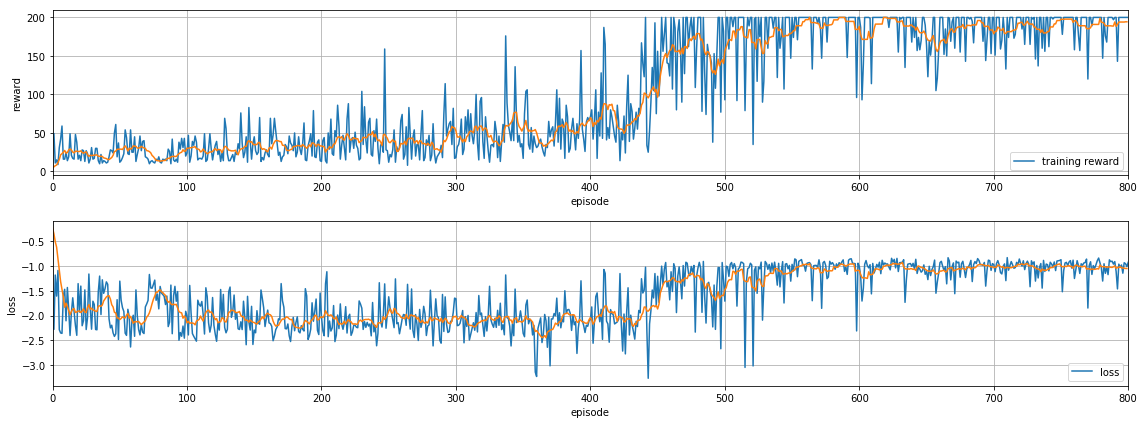

In [18]:
# plot results

def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16,6))
plt.subplot(211)
plt.plot(range(1, len(training_rewards)+1), training_rewards, label='training reward')
plt.plot(moving_average(training_rewards))
plt.xlabel('episode'); plt.ylabel('reward')
plt.xlim((0, len(training_rewards)))
plt.legend(loc=4); plt.grid()
plt.subplot(212)
plt.plot(range(1, len(losses)+1), losses, label='loss')
plt.plot(moving_average(losses))
plt.xlabel('episode'); plt.ylabel('loss')
plt.xlim((0, len(losses)))
plt.legend(loc=4); plt.grid()
plt.tight_layout(); plt.show()